# Test-time Training Exploration: Hindsight Experience Replay

## Goal

Can I solve tasks using test-time training?

I want to explore different TTT techniques such as hindsight experience replay and RL to see if a model can solve novel tasks that cannot be solve with the base model.

I have to focus on the techniques, not on efficiency.

## Imports

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from tqdm.auto import tqdm
from vllm import LLM, SamplingParams
from vllm.lora.request import LoRARequest
from transformers import AutoTokenizer, AutoConfig
import matplotlib.pyplot as plt
import matplotlib as mpl
from datasets import Dataset
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM, SFTConfig
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import logging
from IPython.display import Markdown, display
import torch


from arc25.training_tasks import *
from arc25.encoders import create_grid_encoder
from arc25.prompting import create_prompt_from_task, pretty_print_prompt
from arc25.plot import plot_task, plot_grids_with_shape, plot_grid
from arc25.code_execution import safe_code_execution
from arc25.utils import set_random_seed
from arc25.logging import configure_logging, log_execution_time

configure_logging()

import sys
sys.path.append(os.path.realpath("../scripts"))
from finetuning import get_data_collator


plt.plot()
plt.close('all')
plt.rcParams["figure.figsize"] = (20, 5)
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.size'] = 12

INFO 05-06 16:02:31 [__init__.py:239] Automatically detected platform cuda.


## Code

In [2]:
EpochResults = namedtuple("EpochResults", ["best_prediction", 'pixel_accuracies'])

@log_execution_time
def hindsight_experience_replay(task, cfg):
    """
    Use hindsight experience replay to try to solve new tasks
    """
    plot_task(task); plt.suptitle('Task to solve'); plt.tight_layout(); plt.show()
    model, tokenizer = load_model(cfg.base_model_path, cfg.lora_path)
    metrics = []
    for epoch in range(cfg.max_epochs):
        logging.info(f'Starting epoch {epoch}...')
        new_tasks, pixel_accuracies = inference(
            task, model, tokenizer, cfg.grid_encoder, cfg.prompt_version,
            n_predictions=cfg.n_predictions)
        metrics.append(EpochResults(best_prediction=new_tasks[-1], pixel_accuracies=pixel_accuracies))
        plot_metrics_evolution(metrics)
        if np.max(pixel_accuracies) == 1:
            logger.info(f'Found a perfect prediction at epoch {epoch}!')
            break
        finetuning(new_tasks, model, tokenizer, cfg.grid_encoder, cfg.prompt_version)
    display(Markdown(f'# Best prediction code\n\n```python\n{metrics[-1].best_prediction.code}\n```'))
    return metrics

@log_execution_time
def load_model(base_model_path, lora_path):
    logging.info(f"Loading model from {base_model_path} and LoRA from {lora_path}")
    torch.cuda.empty_cache()
    model = AutoModelForCausalLM.from_pretrained(
        base_model_path, torch_dtype="auto", device_map="auto")
    tokenizer = AutoTokenizer.from_pretrained(lora_path)
    model = PeftModel.from_pretrained(model, lora_path, is_trainable=True)
    return model, tokenizer

@log_execution_time
def inference(task, model, tokenizer, grid_encoder, prompt_version, n_predictions=256):
    prompt = create_prompt_from_task(
        task, prompt_version=prompt_version, grid_encoder=grid_encoder, tokenizer=tokenizer, is_train_prompt=False)
    model_inputs = tokenizer([prompt], return_tensors="pt").to(model.device)

    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=1024,
        do_sample=True,
        temperature=0.5,
        top_p=0.95,
        num_return_sequences=n_predictions
    )
    generated_ids = generated_ids[:, len(model_inputs.input_ids[0]):]
    predictions = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

    predicted_codes = [prediction.replace('\n```', '') for prediction in predictions]
    new_tasks = []
    pixel_accuracies = []
    for predicted_code in tqdm(predicted_codes):
        try:
            predicted_output = safe_code_execution(predicted_code, task.inputs)
            new_tasks.append(Task(inputs=task.inputs, outputs=predicted_output, code=predicted_code, name=task.name))
            pixel_accuracies.append(float(np.mean(new_tasks[-1].outputs[0] == task.outputs[0])))
        except Exception as e:
                print(f'Error executing code: {predicted_code}')
                print(e)

    new_tasks_with_unique_outputs = [new_tasks[0]]
    filtered_pixel_accuracies = []
    for new_task in new_tasks[1:]:
        if not any([np.all(new_task.outputs[0] == t.outputs[0]) for t in new_tasks_with_unique_outputs]):
            new_tasks_with_unique_outputs.append(new_task)
            filtered_pixel_accuracies.append(float(np.mean(new_task.outputs[0] == task.outputs[0])))
    logging.info(f'Number of unique outputs: {len(new_tasks_with_unique_outputs)}/{len(new_tasks)}')
    logging.info(f'Max pixel accuracy: {max(pixel_accuracies)}')
    new_tasks_with_unique_outputs = sorted(new_tasks_with_unique_outputs, key=lambda x: float(np.mean(x.outputs[0] == task.outputs[0])), reverse=False)
    return new_tasks_with_unique_outputs, pixel_accuracies

@log_execution_time
def finetuning(new_tasks, model, tokenizer, grid_encoder, prompt_version):
    prompts = []
    for task in new_tasks:
        prompts.append(create_prompt_from_task(
    task, prompt_version=prompt_version, grid_encoder=grid_encoder, tokenizer=tokenizer, is_train_prompt=True))
    train_dataset = Dataset.from_dict({'text': prompts})

    training_arguments = SFTConfig(
        output_dir=None, #'/mnt/hdd0/Kaggle/arc25/trainings/20250505_TTT/debug',
        save_strategy='no',
        num_train_epochs=1,
        warmup_ratio=0.1,
        learning_rate=1e-5,
        lr_scheduler_type='constant_with_warmup', #constant_with_warmup, cosine, cosine_with_restarts
        # lr_scheduler_kwargs=lr_scheduler_kwargs,
        gradient_checkpointing=False,
        optim="paged_adamw_8bit",
        max_grad_norm=1.0,

        dataset_text_field="text",
        max_seq_length=4096,

        do_eval=True,
        eval_strategy="no", #TODO: previously it was steps
        # save_steps=cfg.save_steps or cfg.eval_steps,
        logging_steps=10, #50,
        log_level="info",
        report_to='none',

        # parameters added to make the code work with accelerate
        # dispatch_batches=False,
        # https://huggingface.co/transformers/v4.9.1/main_classes/trainer.html#trainingarguments
        ddp_find_unused_parameters=False, # only used with accelerate, got a warning saying that it slows down if True

        ignore_data_skip=True, # otherwise it takes too long to start training when resuming from checkpoint

        per_device_train_batch_size=1,
        gradient_accumulation_steps=1,
    )

    trainer = SFTTrainer(
        model=model,
        processing_class=tokenizer,
        train_dataset=train_dataset,
        data_collator=get_data_collator(tokenizer),
        args=training_arguments,
    )
    trainer.train()


def plot_best_prediction(task, best_prediction, accuracy):
    plot_grids_with_shape(task.outputs + best_prediction.outputs, suptitle=f'Best prediction accuracy: {accuracy:.1%}')
    display(Markdown(f'```python\n{best_prediction.code}\n```'))


def plot_metrics_evolution(metrics):
    plot_score_histograms(metrics)

    for epoch, epoch_results in enumerate(metrics):
        plt.subplot(1, len(metrics), epoch + 1)
        plot_grid(epoch_results.best_prediction.outputs[0])
        plt.title(f'Epoch {epoch} acc: {max(epoch_results.pixel_accuracies):.1%}')
    plt.suptitle('Evolution of best predictions')
    plt.tight_layout()
    plt.show()


def plot_score_histograms(metrics, offset_scale=1):
    """
    Plots stacked (y-offset) histograms
    """
    cmap = mpl.colormaps['viridis']#get_cmap("viridis")
    norm = plt.Normalize(0, len(metrics) - 1)
    bins = np.linspace(0, 1, 100)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    plt.figure(figsize=(10, 6))
    for i, epoch_results in enumerate(metrics):
        color = cmap(norm(i))
        counts, _ = np.histogram(epoch_results.pixel_accuracies, bins=bins)
        counts = np.log1p(counts)
        offset = i * np.max(counts) * offset_scale  # Add spacing between histograms
        plt.fill_between(bin_centers, offset, counts + offset, color=color, label=f'Epoch {i}', alpha=0.5)

    plt.xlabel("Pixel accuracy")
    plt.ylabel("Epoch ->")
    plt.title("Evolution of pixel accuracy")
    plt.yticks([])  # Hide y-ticks since they don't represent absolute values
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

## First experiments

In [3]:
@dataclass
class Config:
    base_model_path: str = '/home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct'
    lora_path: str = '/mnt/hdd0/Kaggle/arc25/trainings/20250430_first_trainings/steps_6400/checkpoint-6400'
    prompt_version: str = 'code-from-examples-v3'
    grid_encoder = create_grid_encoder('GridShapeEncoder(RowNumberEncoder(MinimalGridEncoder()))')
    max_epochs: int = 10
    n_predictions: int = 256 # 256 seems to be the best for my hardware

2025-05-06 16:02:35,243 - arc25.encoders - INFO - create_grid_encoder - Created `GridShapeEncoder(RowNumberEncoder(MinimalGridEncoder()))` as grid encoder


### Vertical lines

2025-05-06 16:02:35,293 - arc25.logging - INFO - wrapper - Executing hindsight_experience_replay...


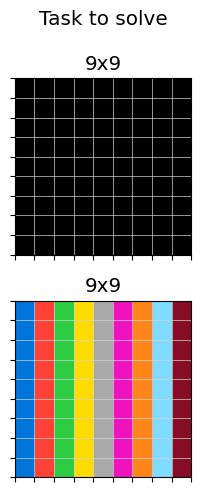

2025-05-06 16:02:35,494 - arc25.logging - INFO - wrapper - Executing load_model...
2025-05-06 16:02:35,495 - root - INFO - load_model - Loading model from /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct and LoRA from /mnt/hdd0/Kaggle/arc25/trainings/20250430_first_trainings/steps_6400/checkpoint-6400
Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.
2025-05-06 16:02:35,847 - accelerate.utils.modeling - INFO - get_balanced_memory - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
2025-05-06 16:02:36,872 - arc25.logging - INFO - wrapper - Executed load_model in 1.3771 seconds
2025-05-06 16:02:36,873 - root - INFO - hindsight_experience_replay - Starting epoch 0...
2025-05-06 16:02:36,874 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 16:02:54,127 - root - INFO - inference - Number of unique outputs: 186/256
2025-05-06 16:02:54,127 - root - INFO - inference - Max pixel accuracy: 0.8888888888888888
2025-05-06 16:02:54,130 - arc25.logging - INFO - wrapper - Executed inference in 17.2552 seconds


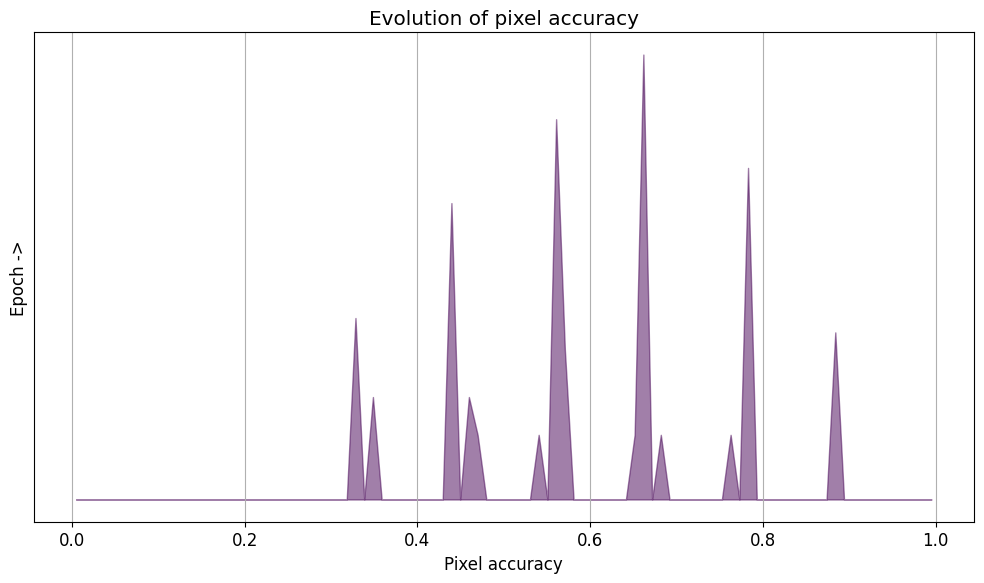

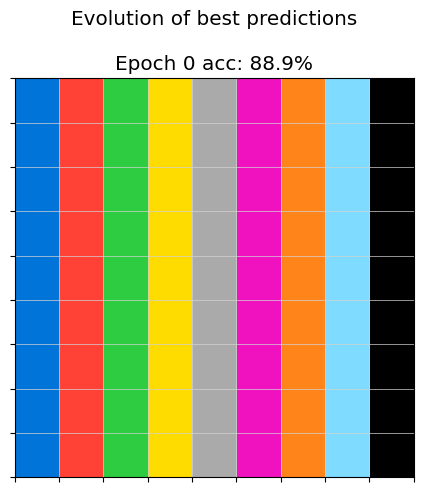

2025-05-06 16:02:54,323 - arc25.logging - INFO - wrapper - Executing finetuning...
2025-05-06 16:02:54,394 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/186 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/186 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/186 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/186 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 186
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 186
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 16:03:28,298 - arc25.logging - INFO - wrapper - Executed finetuning in 33.9749 seconds
2025-05-06 16:03:28,299 - root - INFO - hindsight_experience_replay - Starting epoch 1...
2025-05-06 16:03:28,300 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 16:03:45,974 - root - INFO - inference - Number of unique outputs: 57/256
2025-05-06 16:03:45,974 - root - INFO - inference - Max pixel accuracy: 1.0
2025-05-06 16:03:45,976 - arc25.logging - INFO - wrapper - Executed inference in 17.6756 seconds


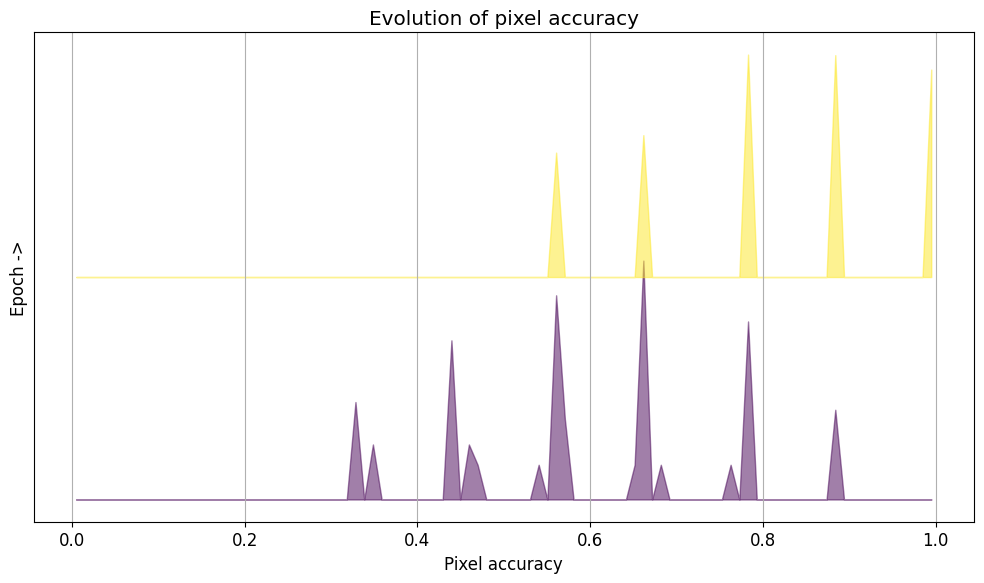

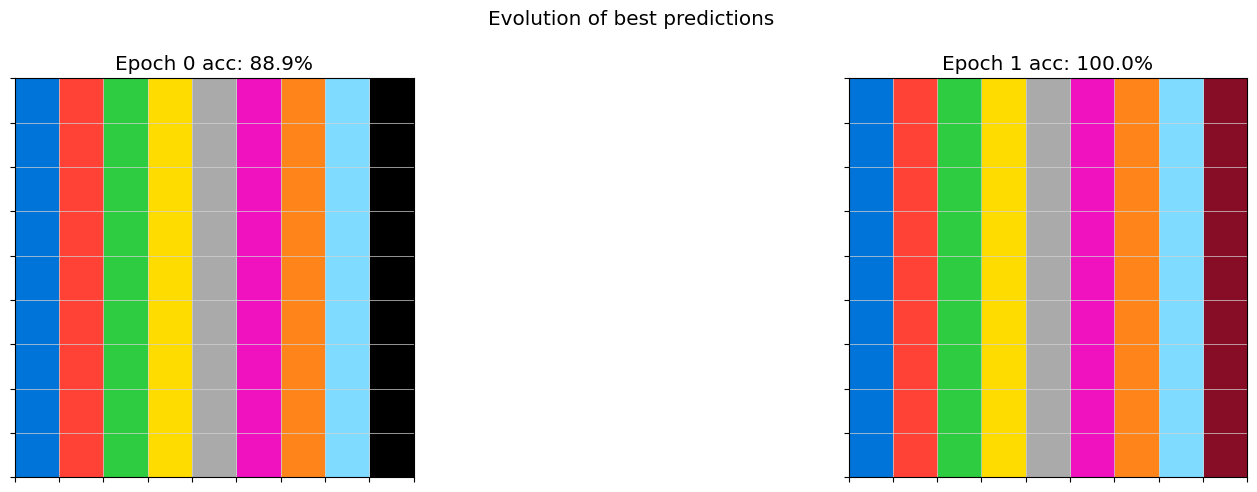

2025-05-06 16:03:46,208 - arc25.input_generation - INFO - hindsight_experience_replay - Found a perfect prediction at epoch 1!


# Best prediction code

```python
def task(img):
    draw_rectangle(img, point1=(0, 4), point2=(8, 7), color=8)
    draw_vertical_line(img, x=0, color=1)
    draw_vertical_line(img, x=2, color=3)
    draw_vertical_line(img, x=4, color=5)
    draw_vertical_line(img, x=3, color=4)
    draw_vertical_line(img, x=5, color=6)
    draw_vertical_line(img, x=6, color=7)
    draw_vertical_line(img, x=1, color=2)
    draw_vertical_line(img, x=8, color=9)
    return img
```

2025-05-06 16:03:46,261 - arc25.logging - INFO - wrapper - Executed hindsight_experience_replay in 70.9669 seconds


In [4]:
input_img = create_img((9, 9), color=0)
output_img = input_img.copy()
for x in range(0, input_img.shape[1], 1):
    draw_vertical_line(output_img, x, color=x+1)

task = Task(inputs=[input_img], outputs=[output_img], code='', name='manual')
hindsight_experience_replay(task, Config());

### Squares

#### 9 squares

2025-05-06 16:03:46,293 - arc25.logging - INFO - wrapper - Executing hindsight_experience_replay...


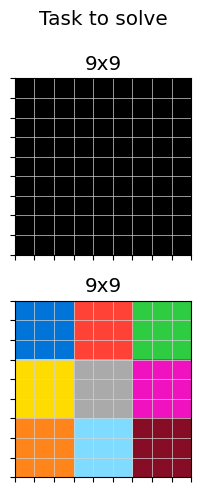

2025-05-06 16:03:46,448 - arc25.logging - INFO - wrapper - Executing load_model...
2025-05-06 16:03:46,449 - root - INFO - load_model - Loading model from /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct and LoRA from /mnt/hdd0/Kaggle/arc25/trainings/20250430_first_trainings/steps_6400/checkpoint-6400
loading configuration file /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct/config.json
Model config Qwen2Config {
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 896,
  "initializer_range": 0.02,
  "intermediate_size": 4864,
  "max_position_embeddings": 32768,
  "max_window_layers": 24,
  "model_type": "qwen2",
  "num_attention_heads": 14,
  "num_hidden_layers": 24,
  "num_key_value_heads": 2,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 1000000.0,
  "sliding_window": 32768,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "tra

  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 16:04:12,500 - root - INFO - inference - Number of unique outputs: 254/256
2025-05-06 16:04:12,502 - root - INFO - inference - Max pixel accuracy: 0.7777777777777778
2025-05-06 16:04:12,513 - arc25.logging - INFO - wrapper - Executed inference in 24.9404 seconds


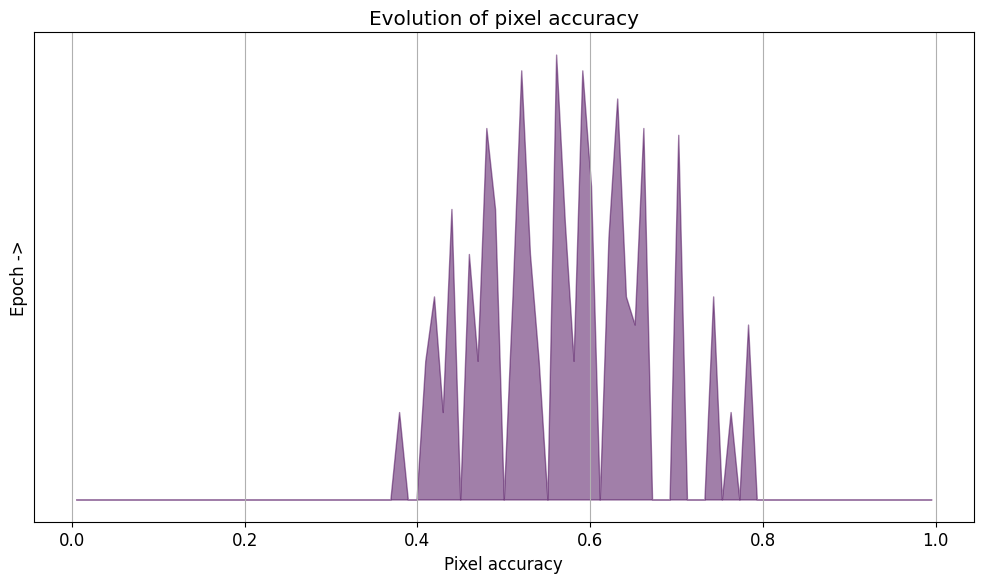

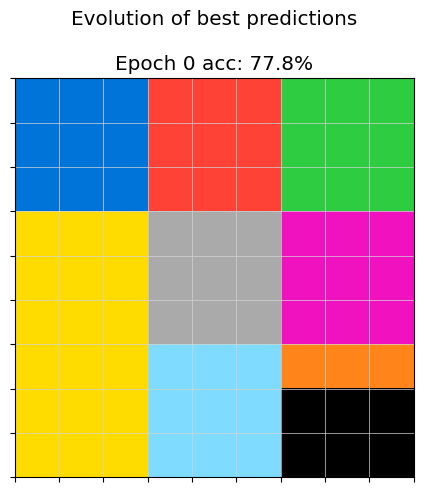

2025-05-06 16:04:12,705 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 16:04:12,790 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/254 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/254 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/254 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/254 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 254
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 254
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 16:05:02,117 - arc25.logging - INFO - wrapper - Executed finetuning in 49.4110 seconds
2025-05-06 16:05:02,118 - root - INFO - hindsight_experience_replay - Starting epoch 1...
2025-05-06 16:05:02,119 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 16:05:29,568 - root - INFO - inference - Number of unique outputs: 164/256
2025-05-06 16:05:29,569 - root - INFO - inference - Max pixel accuracy: 1.0
2025-05-06 16:05:29,573 - arc25.logging - INFO - wrapper - Executed inference in 27.4533 seconds


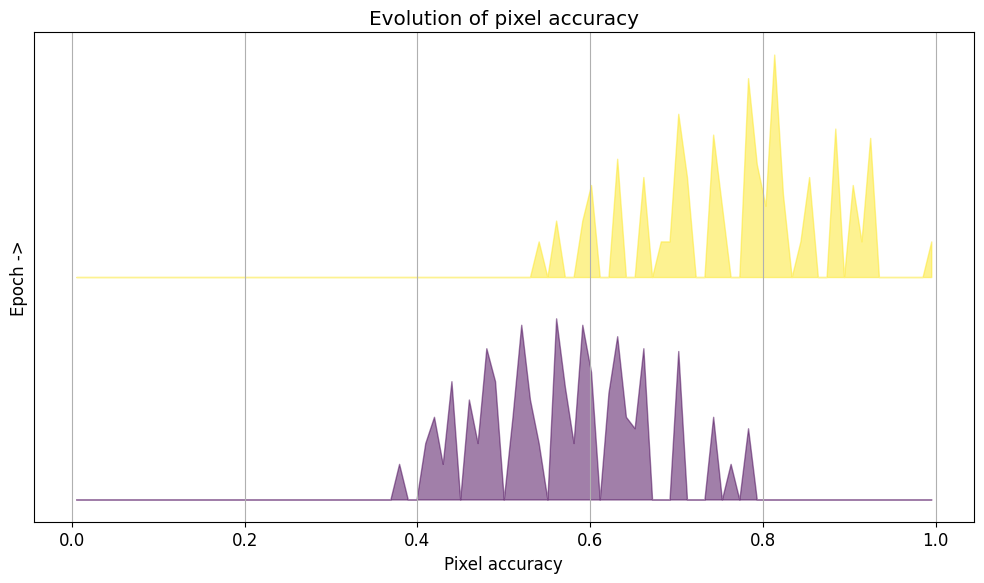

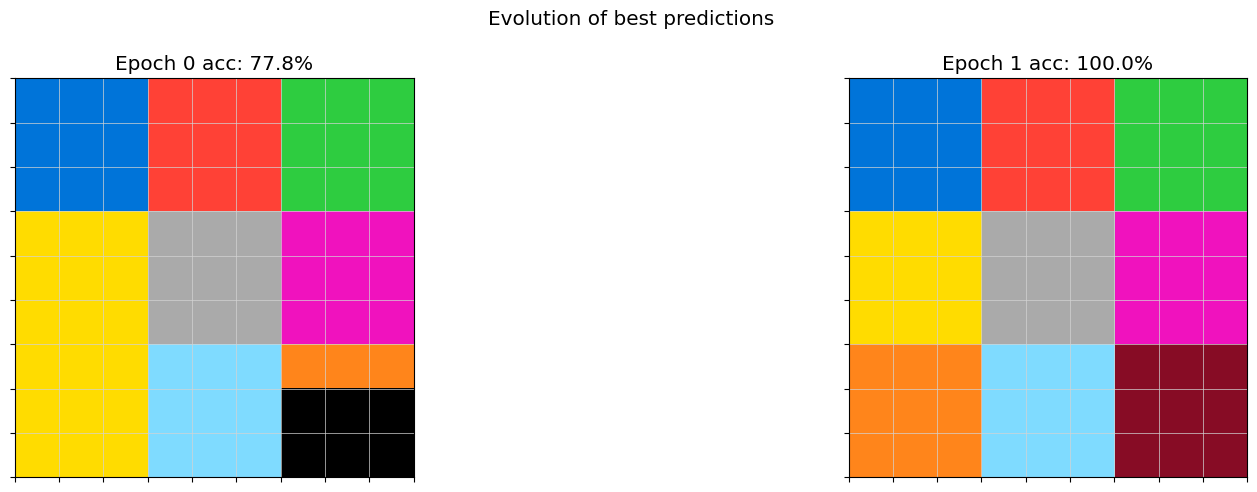

2025-05-06 16:05:29,832 - arc25.input_generation - INFO - hindsight_experience_replay - Found a perfect prediction at epoch 1!


# Best prediction code

```python
def task(img):
    draw_horizontal_line(img, y=0, color=1)
    draw_rectangle(img, point1=(0, 0), point2=(2, 8), color=1)
    draw_rectangle(img, point1=(3, 0), point2=(5, 7), color=4)
    draw_rectangle(img, point1=(6, 3), point2=(8, 8), color=8)
    draw_rectangle(img, point1=(0, 3), point2=(2, 6), color=2)
    draw_rectangle(img, point1=(6, 6), point2=(8, 8), color=9)
    draw_rectangle(img, point1=(3, 3), point2=(5, 5), color=5)
    draw_rectangle(img, point1=(0, 6), point2=(2, 8), color=3)
    draw_rectangle(img, point1=(3, 6), point2=(5, 8), color=6)
    draw_rectangle(img, point1=(6, 0), point2=(8, 2), color=7)
    return img
```

2025-05-06 16:05:29,892 - arc25.logging - INFO - wrapper - Executed hindsight_experience_replay in 103.5976 seconds


In [5]:
input_img = create_img((9, 9), color=0)
output_img = input_img.copy()
color = 0
for x in range(0, input_img.shape[1], 3):
    for y in range(0, input_img.shape[0], 3):
        color += 1
        draw_rectangle(output_img, (x, y), (x+2, y+2), color=color)
task = Task(inputs=[input_img], outputs=[output_img], code='', name='manual')
metrics = hindsight_experience_replay(task, Config())

#### 16 squares

2025-05-06 16:05:29,922 - arc25.logging - INFO - wrapper - Executing hindsight_experience_replay...


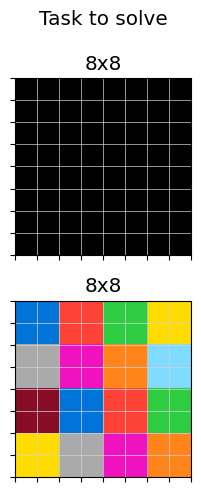

2025-05-06 16:05:30,135 - arc25.logging - INFO - wrapper - Executing load_model...
2025-05-06 16:05:30,137 - root - INFO - load_model - Loading model from /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct and LoRA from /mnt/hdd0/Kaggle/arc25/trainings/20250430_first_trainings/steps_6400/checkpoint-6400
loading configuration file /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct/config.json
Model config Qwen2Config {
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 896,
  "initializer_range": 0.02,
  "intermediate_size": 4864,
  "max_position_embeddings": 32768,
  "max_window_layers": 24,
  "model_type": "qwen2",
  "num_attention_heads": 14,
  "num_hidden_layers": 24,
  "num_key_value_heads": 2,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 1000000.0,
  "sliding_window": 32768,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "tra

  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 16:06:06,255 - root - INFO - inference - Number of unique outputs: 255/255
2025-05-06 16:06:06,257 - root - INFO - inference - Max pixel accuracy: 0.609375
2025-05-06 16:06:06,262 - arc25.logging - INFO - wrapper - Executed inference in 35.0348 seconds


Error executing code: def task(img):
    draw_horizontal_line(img, y=0, value=1)
    draw_rectangle(img, point1=(0, 4), point2=(7, 7), color=3)
    draw_rectangle(img, point1=(6, 0), point2=(7, 3), color=4)
    draw_rectangle(img, point1=(4, 2), point2=(7, 5), color=6)
    draw_vertical_line(img, x=2, color=5)
    draw_rectangle(img, point1=(2, 0), point2=(3, 1), color=5)
    draw_pixel(img, point=(6, 6), color=7)
    draw_rectangle(img, point1=(0, 2), point2=(1, 5), color=2)
    draw_pixel(img, point=(2, 4), color=7)
    return img
draw_horizontal_line() got an unexpected keyword argument 'value'


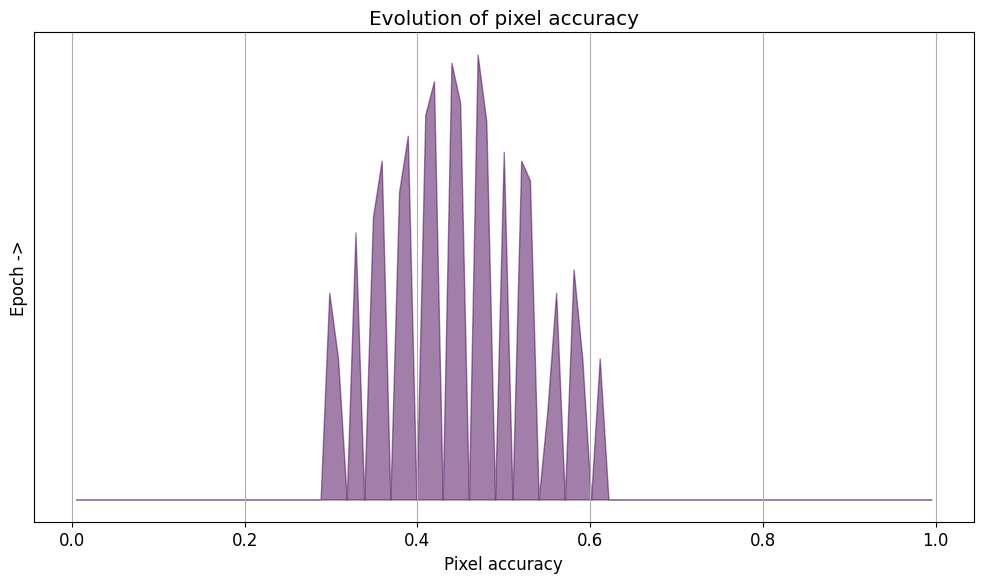

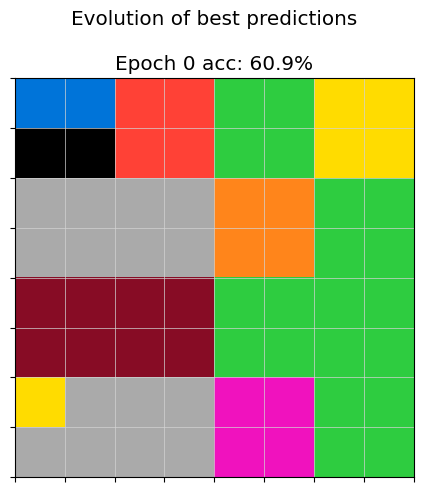

2025-05-06 16:06:06,418 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 16:06:06,494 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/255 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/255 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/255 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/255 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 255
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 255
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 16:06:54,691 - arc25.logging - INFO - wrapper - Executed finetuning in 48.2723 seconds
2025-05-06 16:06:54,692 - root - INFO - hindsight_experience_replay - Starting epoch 1...
2025-05-06 16:06:54,692 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 16:07:27,624 - root - INFO - inference - Number of unique outputs: 254/256
2025-05-06 16:07:27,625 - root - INFO - inference - Max pixel accuracy: 0.671875
2025-05-06 16:07:27,629 - arc25.logging - INFO - wrapper - Executed inference in 32.9359 seconds


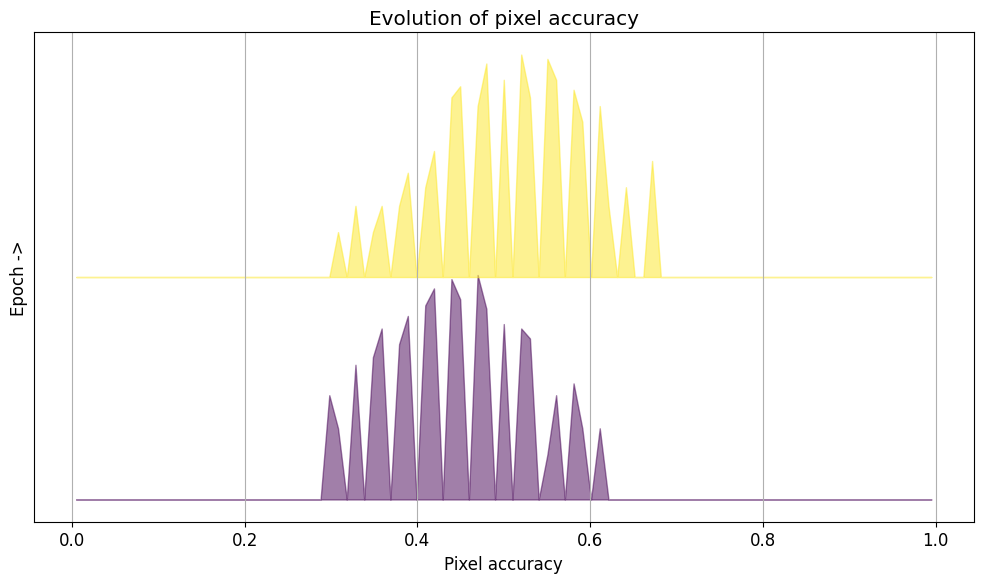

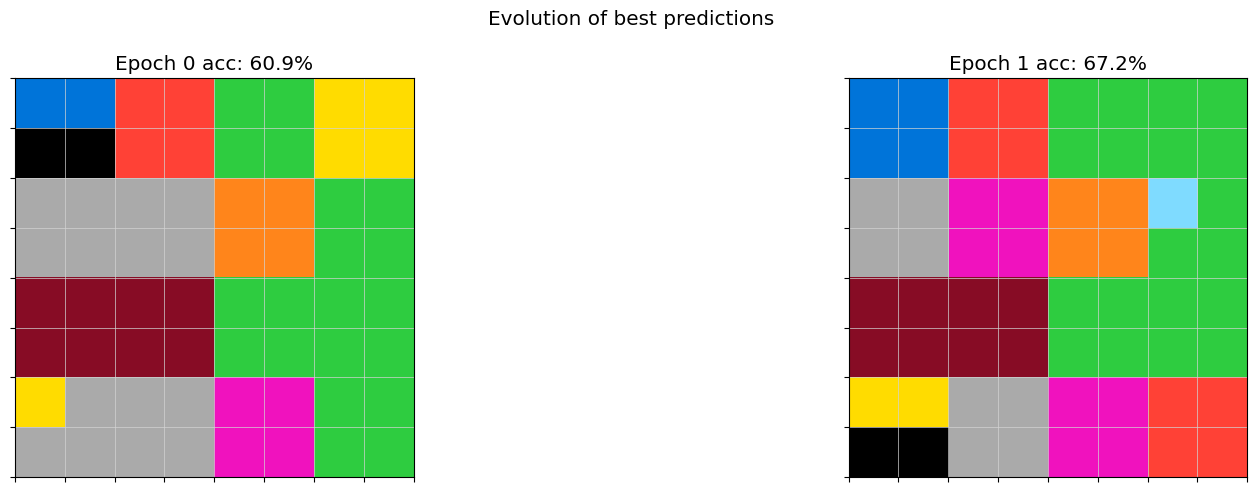

2025-05-06 16:07:27,860 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 16:07:27,996 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/254 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/254 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/254 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/254 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 254
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 254
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 16:08:15,150 - arc25.logging - INFO - wrapper - Executed finetuning in 47.2884 seconds
2025-05-06 16:08:15,151 - root - INFO - hindsight_experience_replay - Starting epoch 2...
2025-05-06 16:08:15,152 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 16:08:53,971 - root - INFO - inference - Number of unique outputs: 254/256
2025-05-06 16:08:53,972 - root - INFO - inference - Max pixel accuracy: 0.78125
2025-05-06 16:08:53,975 - arc25.logging - INFO - wrapper - Executed inference in 38.8226 seconds


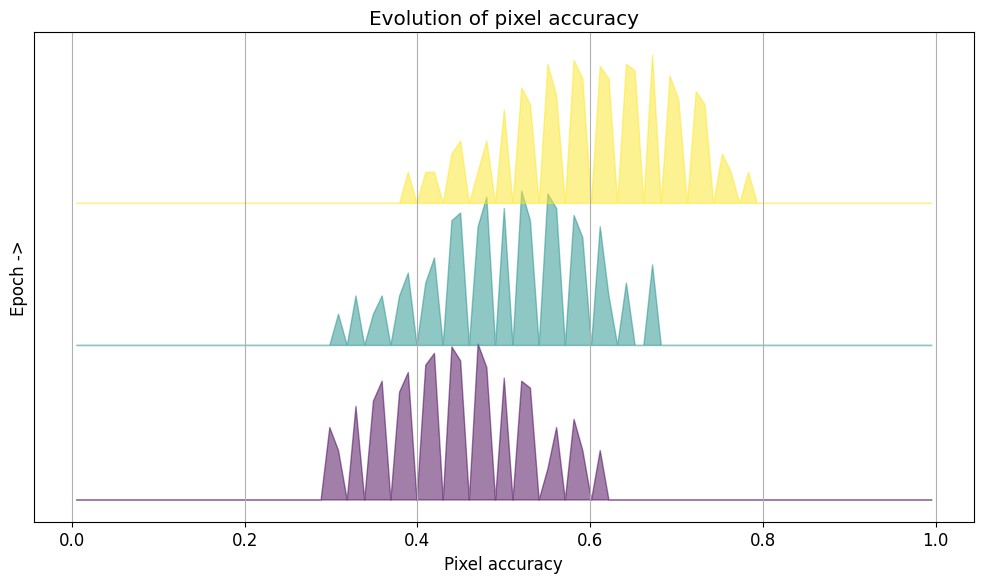

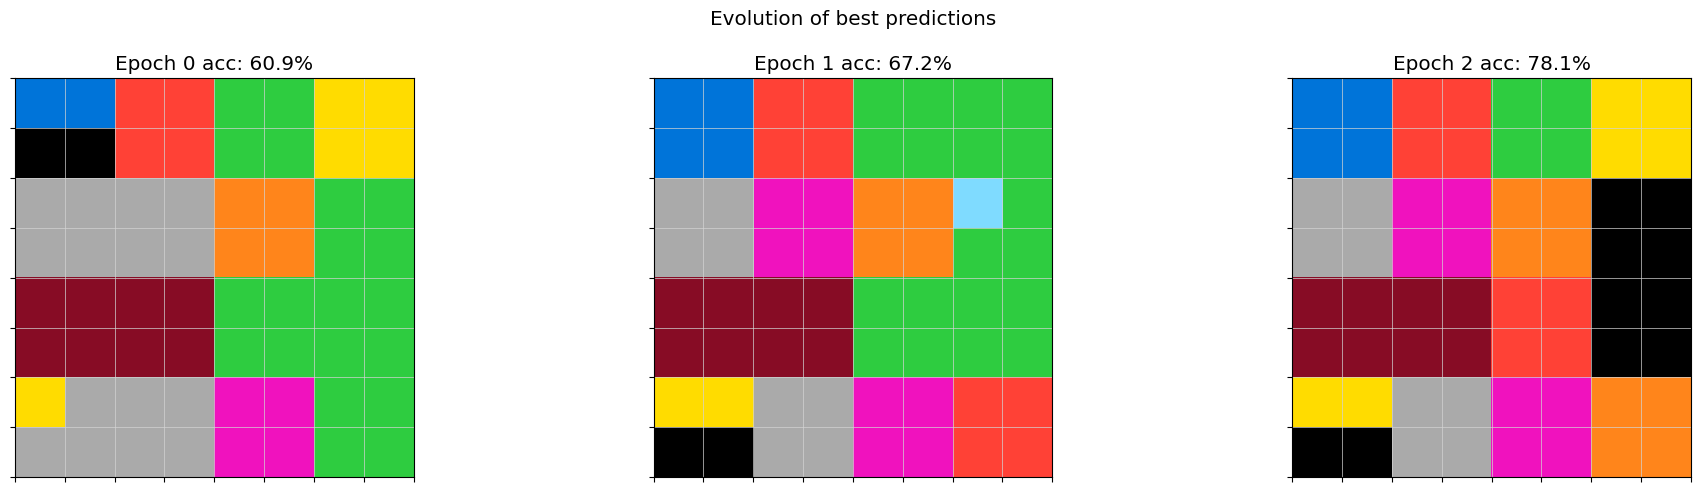

2025-05-06 16:08:54,269 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 16:08:54,409 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/254 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/254 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/254 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/254 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 254
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 254
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 16:09:42,760 - arc25.logging - INFO - wrapper - Executed finetuning in 48.4899 seconds
2025-05-06 16:09:42,761 - root - INFO - hindsight_experience_replay - Starting epoch 3...
2025-05-06 16:09:42,762 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 16:10:28,298 - root - INFO - inference - Number of unique outputs: 219/256
2025-05-06 16:10:28,299 - root - INFO - inference - Max pixel accuracy: 0.875
2025-05-06 16:10:28,308 - arc25.logging - INFO - wrapper - Executed inference in 45.5452 seconds


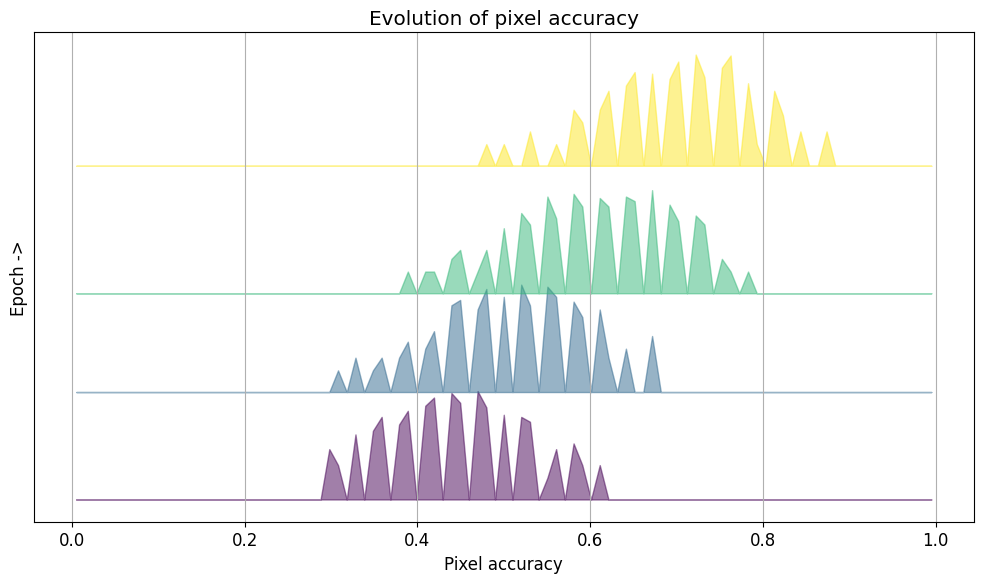

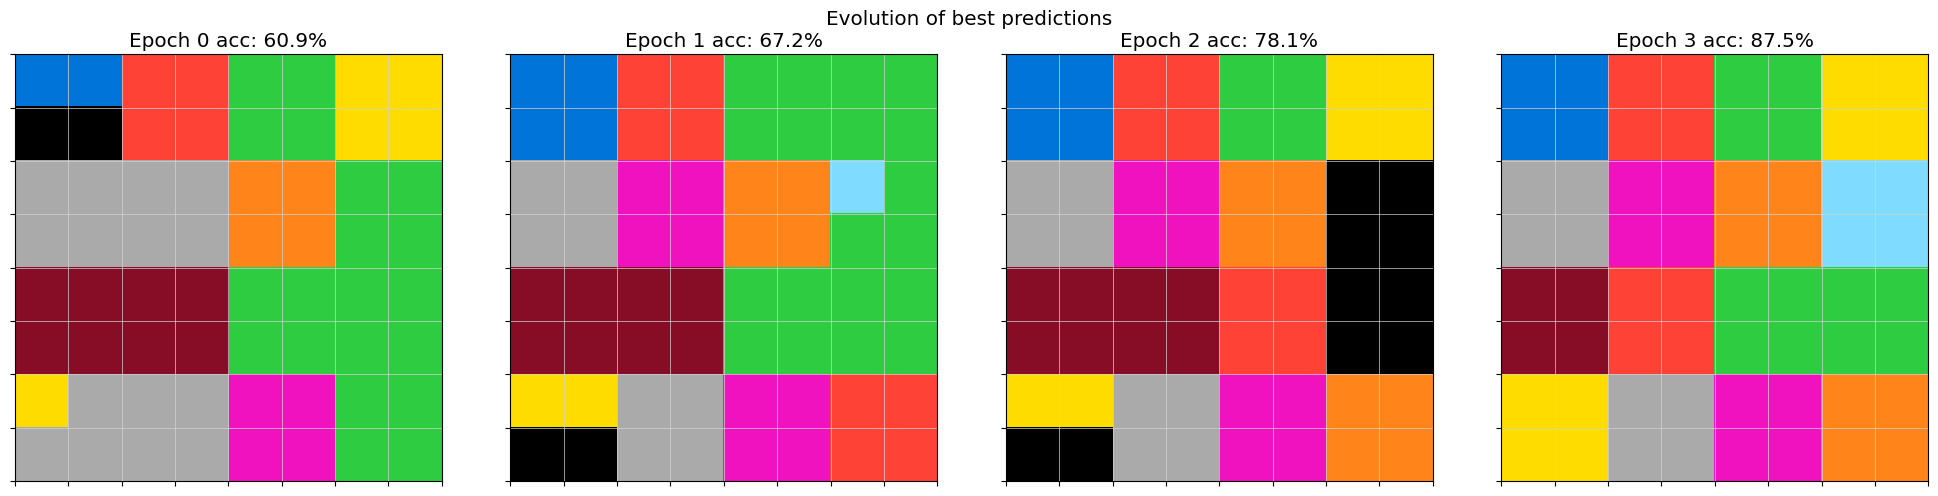

2025-05-06 16:10:28,755 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 16:10:28,849 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/219 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/219 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/219 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/219 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 219
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 219
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 16:11:19,268 - arc25.logging - INFO - wrapper - Executed finetuning in 50.5125 seconds
2025-05-06 16:11:19,270 - root - INFO - hindsight_experience_replay - Starting epoch 4...
2025-05-06 16:11:19,270 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 16:12:11,277 - root - INFO - inference - Number of unique outputs: 98/256
2025-05-06 16:12:11,279 - root - INFO - inference - Max pixel accuracy: 0.9375
2025-05-06 16:12:11,283 - arc25.logging - INFO - wrapper - Executed inference in 52.0118 seconds


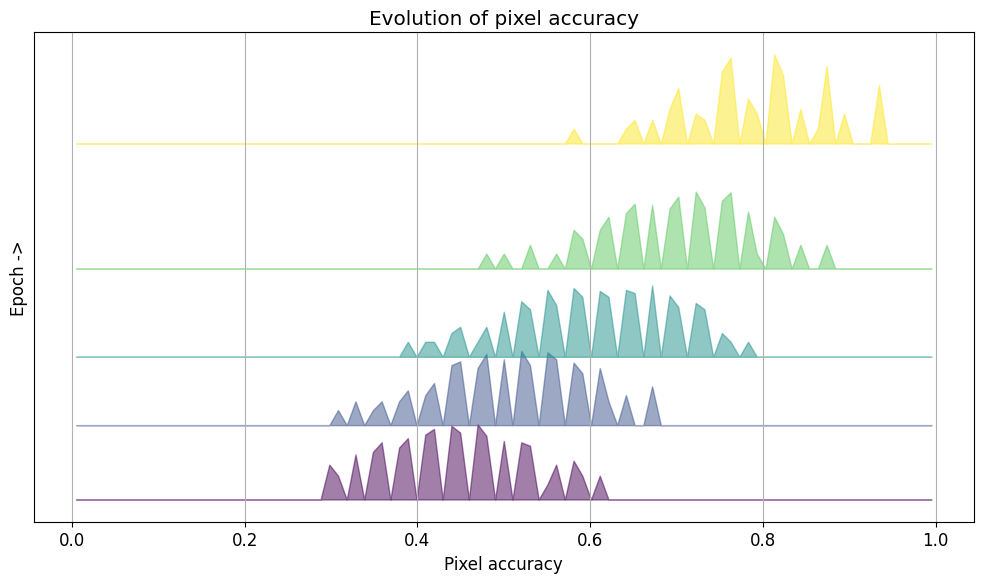

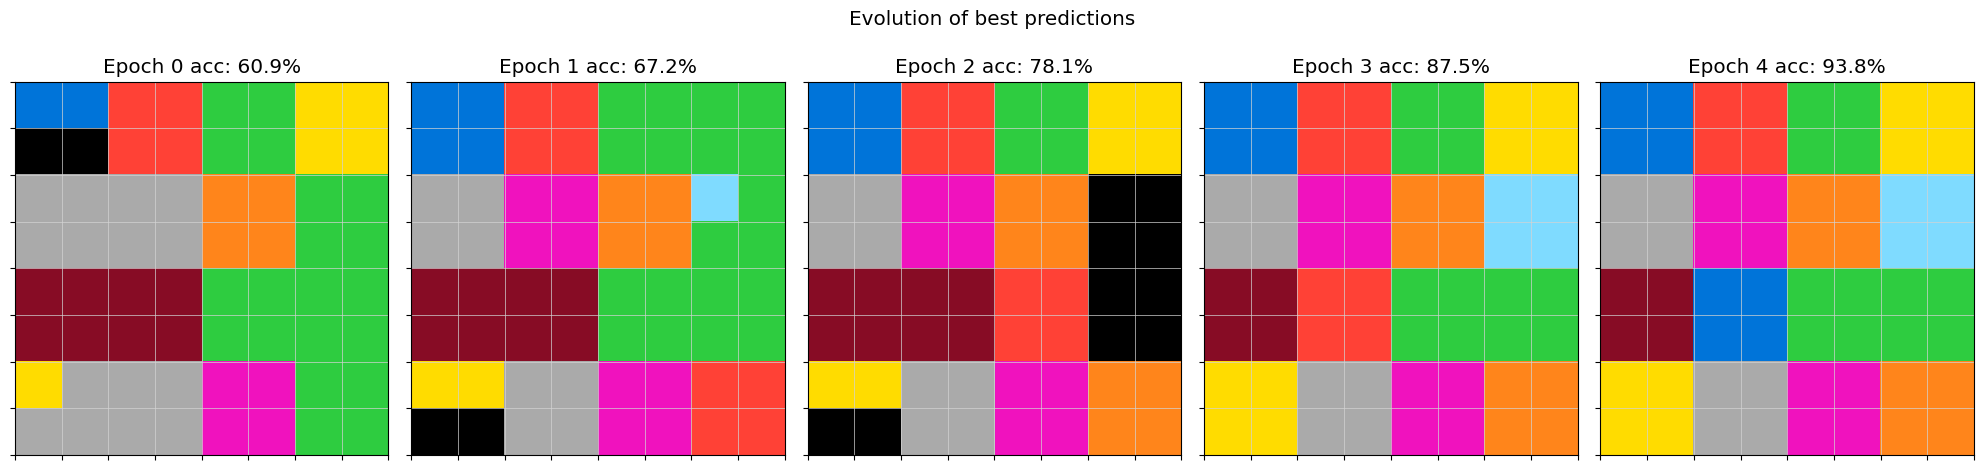

2025-05-06 16:12:11,697 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 16:12:11,760 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/98 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/98 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/98 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/98 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 98
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 98
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 16:12:31,670 - arc25.logging - INFO - wrapper - Executed finetuning in 19.9725 seconds
2025-05-06 16:12:31,672 - root - INFO - hindsight_experience_replay - Starting epoch 5...
2025-05-06 16:12:31,673 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 16:13:26,517 - root - INFO - inference - Number of unique outputs: 71/256
2025-05-06 16:13:26,518 - root - INFO - inference - Max pixel accuracy: 0.9375
2025-05-06 16:13:26,520 - arc25.logging - INFO - wrapper - Executed inference in 54.8468 seconds


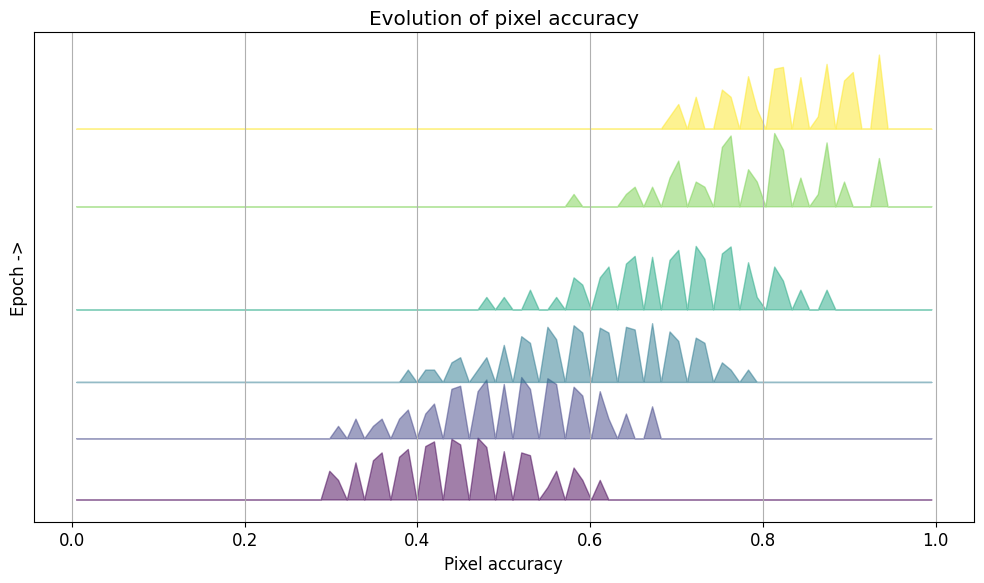

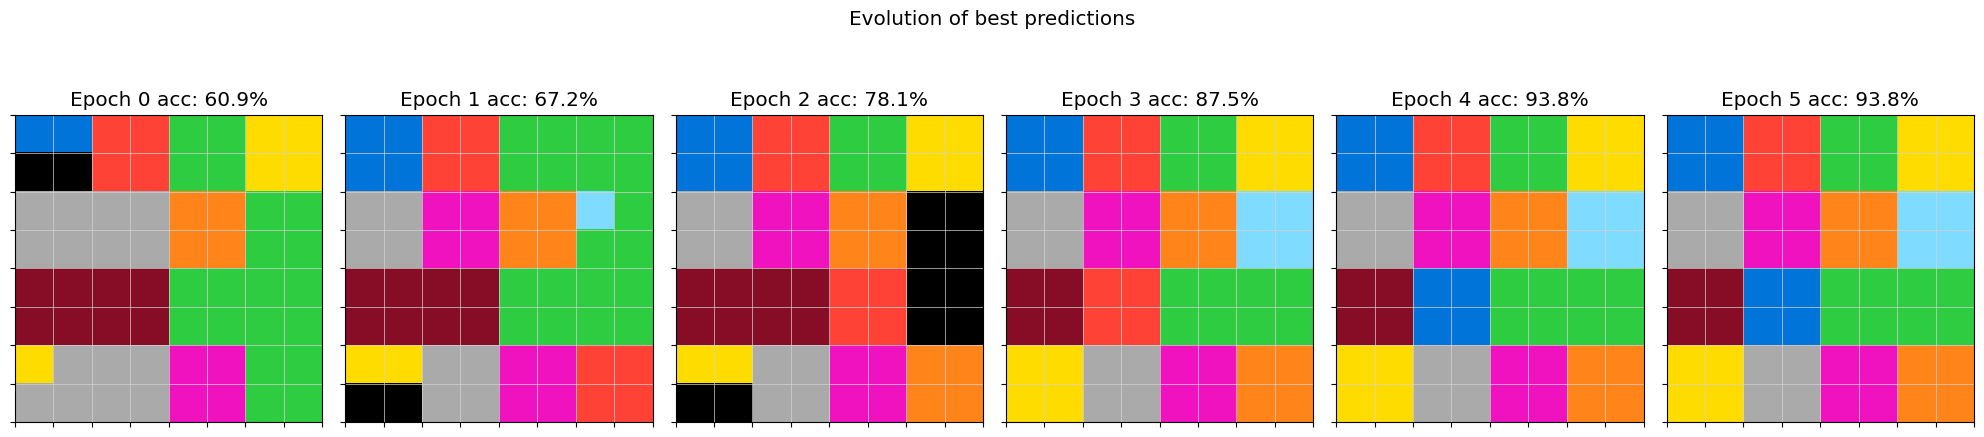

2025-05-06 16:13:26,992 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 16:13:27,047 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/71 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/71 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/71 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/71 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 71
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 71
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 16:13:41,359 - arc25.logging - INFO - wrapper - Executed finetuning in 14.3661 seconds
2025-05-06 16:13:41,360 - root - INFO - hindsight_experience_replay - Starting epoch 6...
2025-05-06 16:13:41,361 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 16:14:32,663 - root - INFO - inference - Number of unique outputs: 33/255
2025-05-06 16:14:32,664 - root - INFO - inference - Max pixel accuracy: 0.9375
2025-05-06 16:14:32,666 - arc25.logging - INFO - wrapper - Executed inference in 51.3042 seconds


Error executing code: def task(img):
    draw_horizontal_line(img, y=0, color=4)
    draw_rectangle(img, point1=(0, 2), point2=(5, 5), color=2)
    draw_vertical_line(img, x=4, color=6)
    draw_rectangle(img, point1=(0, 0), point2=(1, 1), color=1)
    draw_rectangle(img, point1=(0, 4), point2=(5, 7), color=3)
    draw_rectangle(img, point1=(2, 0), point2=(3, 3), color=5)
    draw_pixel(img, point=(6, 0), color=4)
    draw.square(img, point=(2, 4), color=7)
    draw_rectangle(img, point1=(6, 2), point2=(7, 5), color=6)
    draw_rectangle(img, point1=(6, 6), point2=(7, 7), color=7)
    draw_rectangle(img, point1=(4, 2), point2=(5, 3), color=1)
    draw_rectangle(img, point1=(6, 0), point2=(7, 1), color=4)
    draw_rectangle(img, point1=(2, 2), point2=(3, 5), color=6)
    draw_rectangle(img, point1=(0, 6), point2=(1, 7), color=4)
    draw_rectangle(img, point1=(2, 6), point2=(3, 7), color=8)
    draw_pixel(img, point=(2, 0), color=5)
    draw_rectangle(img, point1=(4, 0), point2=(5, 1), 

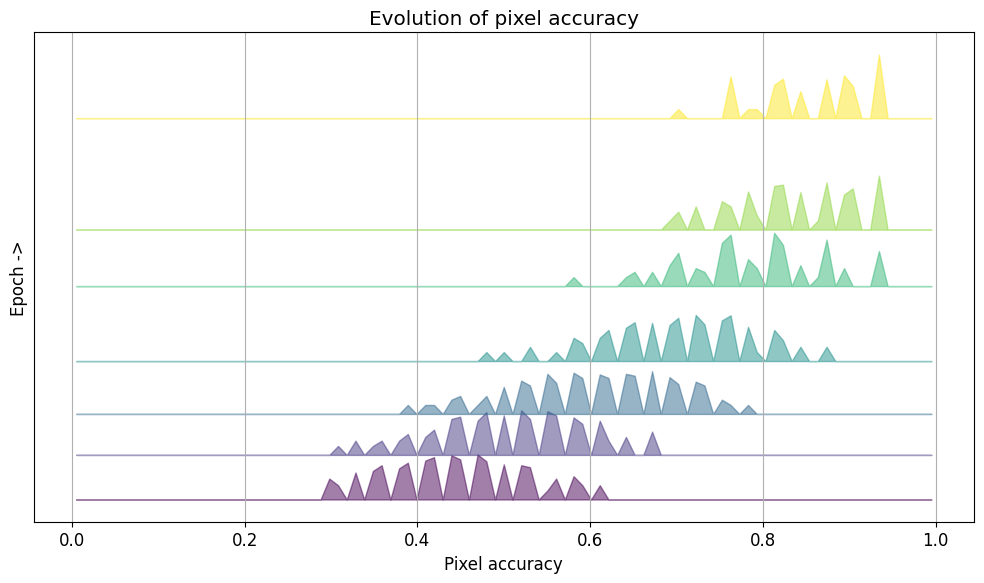

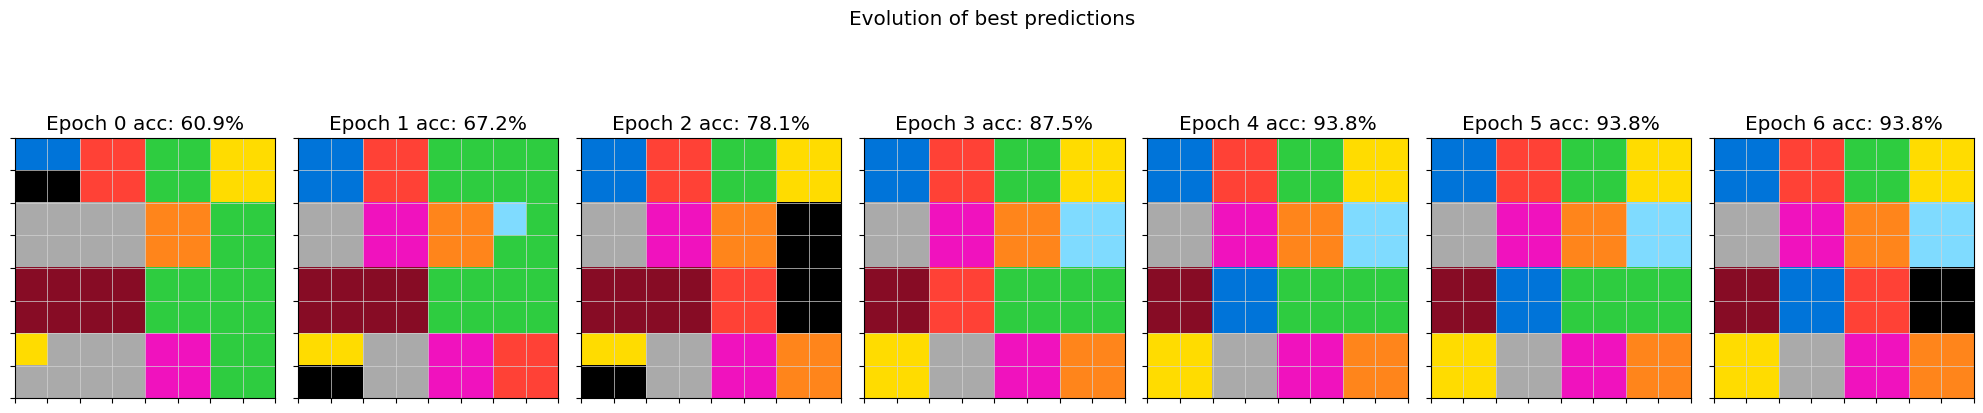

2025-05-06 16:14:33,160 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 16:14:33,219 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/33 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/33 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/33 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/33 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 33
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 33
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 16:14:40,204 - arc25.logging - INFO - wrapper - Executed finetuning in 7.0434 seconds
2025-05-06 16:14:40,206 - root - INFO - hindsight_experience_replay - Starting epoch 7...
2025-05-06 16:14:40,207 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 16:15:51,349 - root - INFO - inference - Number of unique outputs: 19/256
2025-05-06 16:15:51,350 - root - INFO - inference - Max pixel accuracy: 0.9375
2025-05-06 16:15:51,351 - arc25.logging - INFO - wrapper - Executed inference in 71.1438 seconds


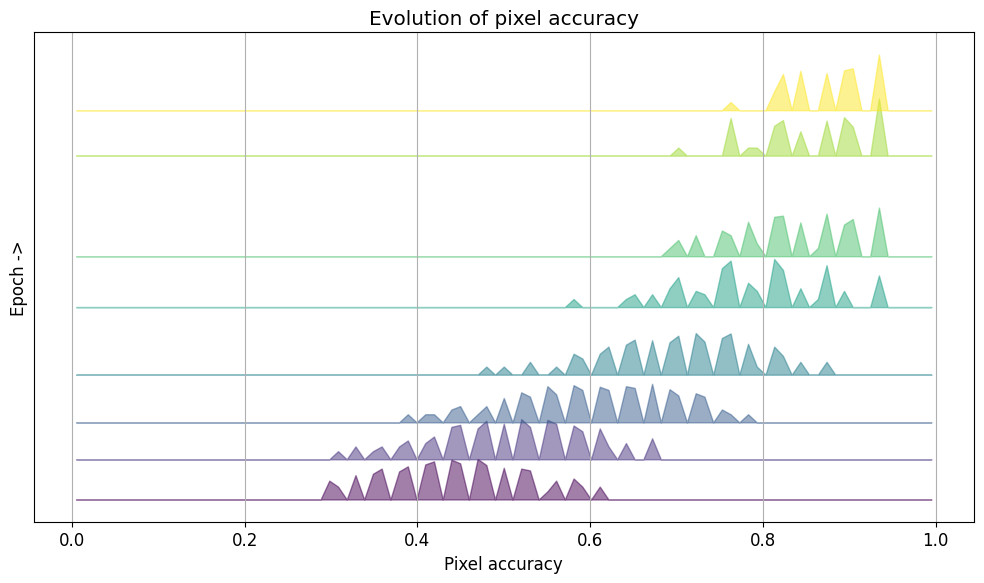

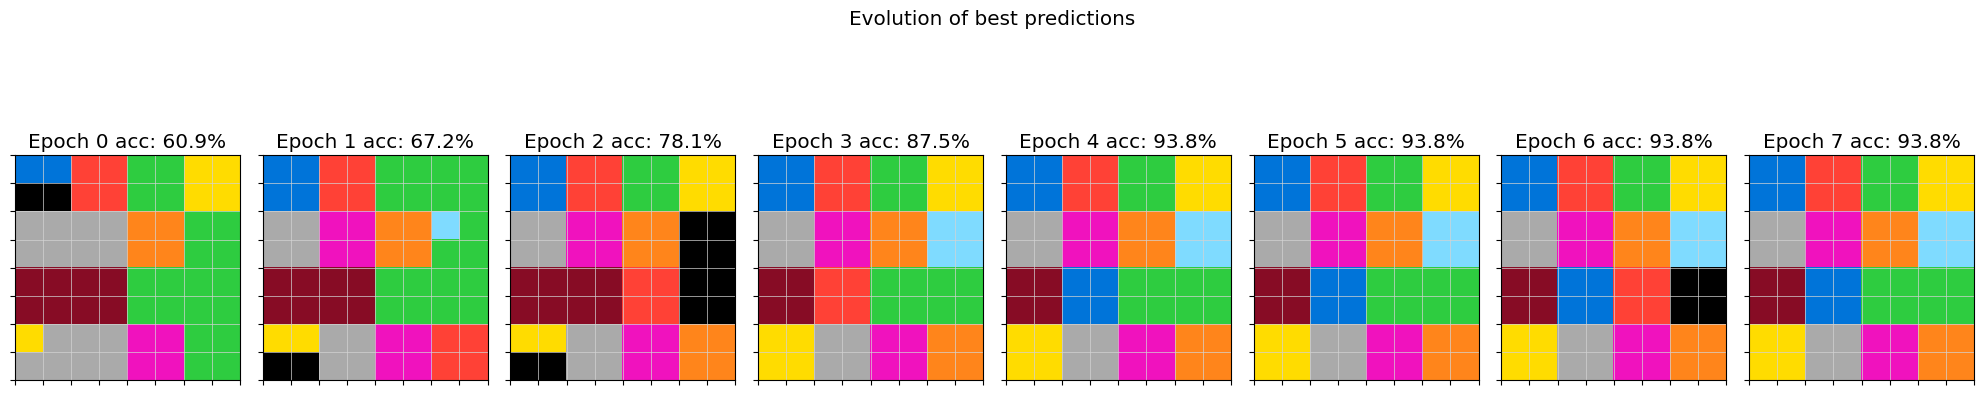

2025-05-06 16:15:51,906 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 16:15:51,945 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/19 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/19 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/19 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/19 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 19
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 19
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 16:15:56,982 - arc25.logging - INFO - wrapper - Executed finetuning in 5.0750 seconds
2025-05-06 16:15:56,983 - root - INFO - hindsight_experience_replay - Starting epoch 8...
2025-05-06 16:15:56,984 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 16:17:05,680 - root - INFO - inference - Number of unique outputs: 35/256
2025-05-06 16:17:05,682 - root - INFO - inference - Max pixel accuracy: 0.9375
2025-05-06 16:17:05,684 - arc25.logging - INFO - wrapper - Executed inference in 68.6996 seconds


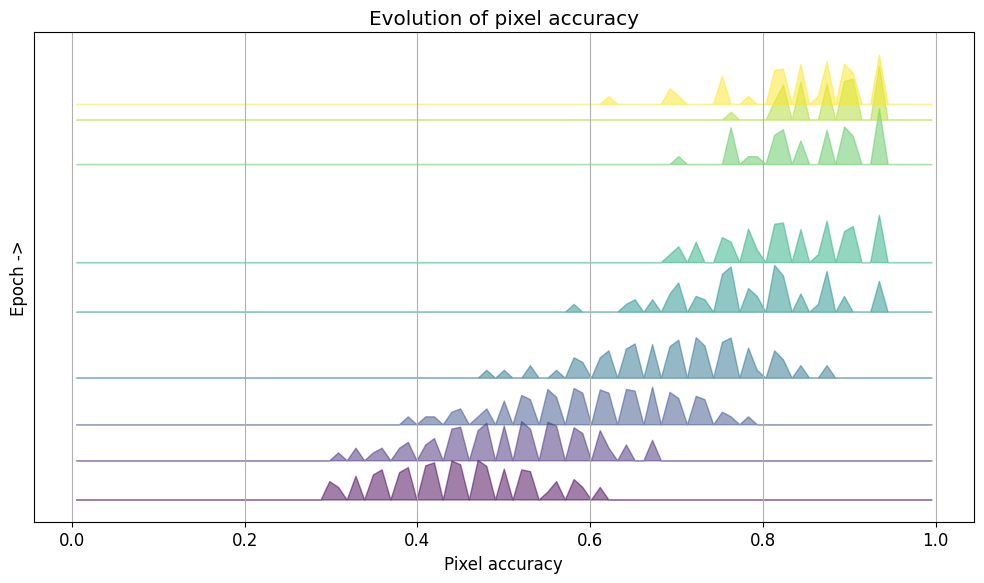

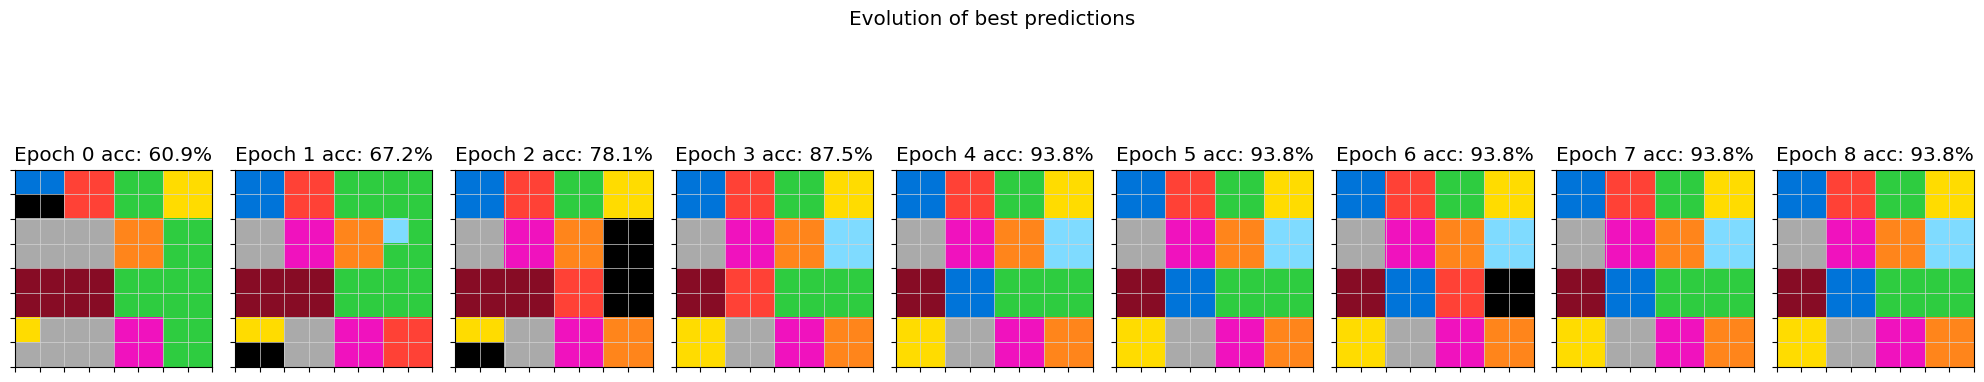

2025-05-06 16:17:06,325 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 16:17:06,383 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/35 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/35 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/35 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/35 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 35
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 35
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 16:17:14,894 - arc25.logging - INFO - wrapper - Executed finetuning in 8.5681 seconds
2025-05-06 16:17:14,896 - root - INFO - hindsight_experience_replay - Starting epoch 9...
2025-05-06 16:17:14,897 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 16:18:41,569 - root - INFO - inference - Number of unique outputs: 43/256
2025-05-06 16:18:41,569 - root - INFO - inference - Max pixel accuracy: 0.9375
2025-05-06 16:18:41,571 - arc25.logging - INFO - wrapper - Executed inference in 86.6739 seconds


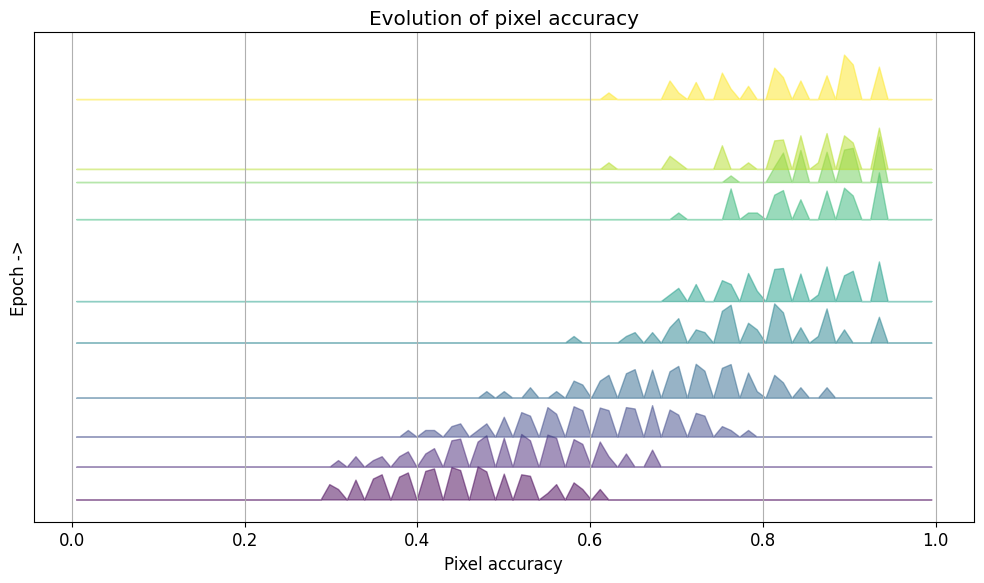

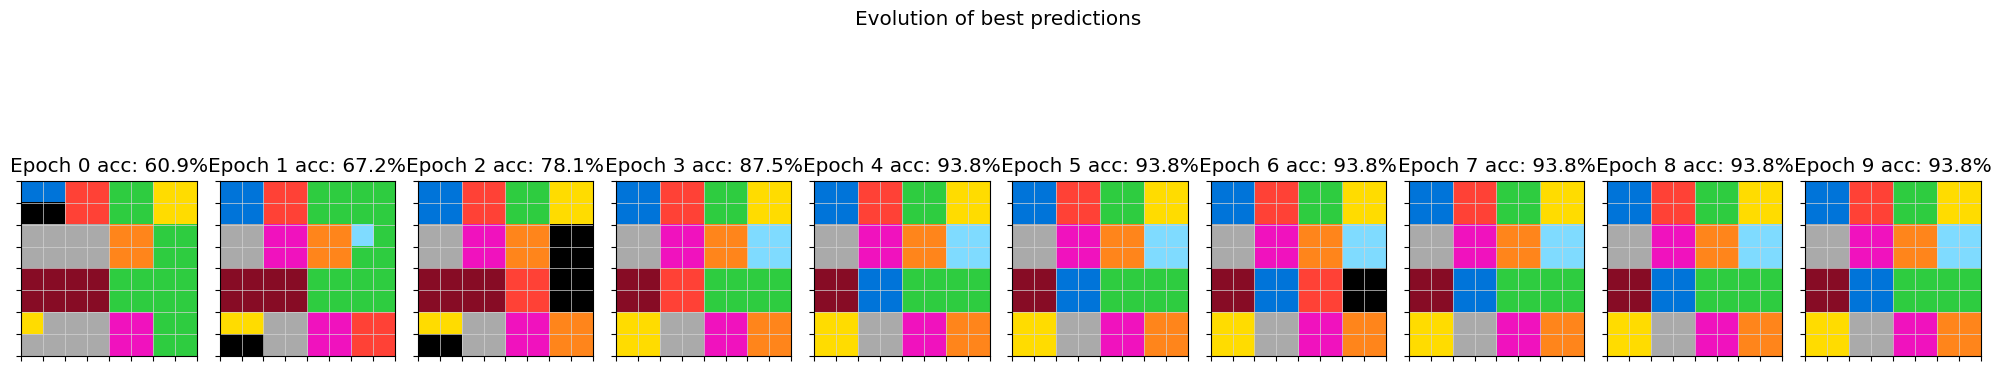

2025-05-06 16:18:42,206 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 16:18:42,267 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/43 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/43 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/43 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/43 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 43
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 16:18:52,062 - arc25.logging - INFO - wrapper - Executed finetuning in 9.8553 seconds


# Best prediction code

```python
def task(img):
    draw_rectangle(img, point1=(0, 0), point2=(1, 1), color=1)
    draw_horizontal_line(img, y=6, color=7)
    draw_vertical_line(img, x=4, color=6)
    draw_rectangle(img, point1=(0, 2), point2=(5, 5), color=2)
    draw_rectangle(img, point1=(0, 4), point2=(5, 7), color=3)
    draw_rectangle(img, point1=(2, 0), point2=(3, 3), color=5)
    draw_pixel(img, point=(6, 0), color=4)
    draw_rectangle(img, point1=(6, 2), point2=(7, 5), color=6)
    draw_rectangle(img, point1=(2, 4), point2=(3, 5), color=7)
    draw_rectangle(img, point1=(6, 2), point2=(7, 3), color=5)
    draw_rectangle(img, point1=(0, 6), point2=(1, 7), color=4)
    draw_rectangle(img, point1=(4, 0), point2=(5, 1), color=9)
    draw_rectangle(img, point1=(6, 6), point2=(7, 7), color=7)
    draw_rectangle(img, point1=(4, 2), point2=(5, 3), color=1)
    draw_rectangle(img, point1=(2, 2), point2=(3, 3), color=6)
    draw_rectangle(img, point1=(6, 0), point2=(7, 1), color=4)
    draw_rectangle(img, point1=(0, 2), point2=(1, 3), color=2)
    draw_rectangle(img, point1=(2, 6), point2=(3, 7), color=8)
    draw_pixel(img, point=(2, 0), color=5)
    return img
```

2025-05-06 16:18:52,127 - arc25.logging - INFO - wrapper - Executed hindsight_experience_replay in 802.2031 seconds


In [6]:
input_img = create_img((8, 8), color=0)
output_img = input_img.copy()
color = 0
for x in range(0, input_img.shape[1], 2):
    for y in range(0, input_img.shape[0], 2):
        color = (color + 1) % 10
        if color == 0: color = 1
        draw_rectangle(output_img, (x, y), (x+1, y+1), color=color)
task = Task(inputs=[input_img], outputs=[output_img], code='', name='manual')
metrics = hindsight_experience_replay(task, Config())

#### 20 squares

2025-05-06 16:20:05,032 - arc25.logging - INFO - wrapper - Executing hindsight_experience_replay...


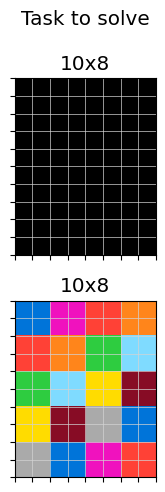

2025-05-06 16:20:05,212 - arc25.logging - INFO - wrapper - Executing load_model...
2025-05-06 16:20:05,213 - root - INFO - load_model - Loading model from /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct and LoRA from /mnt/hdd0/Kaggle/arc25/trainings/20250430_first_trainings/steps_6400/checkpoint-6400
loading configuration file /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct/config.json
Model config Qwen2Config {
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 896,
  "initializer_range": 0.02,
  "intermediate_size": 4864,
  "max_position_embeddings": 32768,
  "max_window_layers": 24,
  "model_type": "qwen2",
  "num_attention_heads": 14,
  "num_hidden_layers": 24,
  "num_key_value_heads": 2,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 1000000.0,
  "sliding_window": 32768,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "tra

  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 16:20:43,838 - root - INFO - inference - Number of unique outputs: 254/254
2025-05-06 16:20:43,839 - root - INFO - inference - Max pixel accuracy: 0.5625
2025-05-06 16:20:43,852 - arc25.logging - INFO - wrapper - Executed inference in 37.2978 seconds


Error executing code: def task(img):
    draw_rectangle(img, point1=(0, 0), point2=(1, 7), color=1)
    draw_horizontal_line(img, y=4, y1=5, color=3)
    draw_rectangle(img, point1=(0, 4), point2=(9, 7), color=2)
    draw_rectangle(img, point1=(6, 2), point2=(9, 6), color=6)
    draw_vertical_line(img, x=2, color=1)
    draw_rectangle(img, point1=(2, 0), point2=(3, 1), color=2)
    draw_rectangle(img, point1=(2, 4), point2=(3, 5), color=3)
    draw_rectangle(img, point1=(4, 2), point2=(7, 3), color=8)
    draw_pixel(img, point=(8, 0), color=5)
    draw_pixel(img, point=(6, 2), color=9)
    draw_pixel(img, point=(6, 4), color=4)
    draw_rectangle(img, point1=(6, 6), point2=(7, 7), color=1)
    return img
draw_horizontal_line() got an unexpected keyword argument 'y1'
Error executing code: def task(img):
    draw_rectangle(img, point1=(0, 0), point2=(9, 3), color=1)
    draw_horizontal_line(img, y=2, color=2)
    draw_rectangle(img, point1=(0, 4), point2=(1, 5), color=2)
    draw_rectang

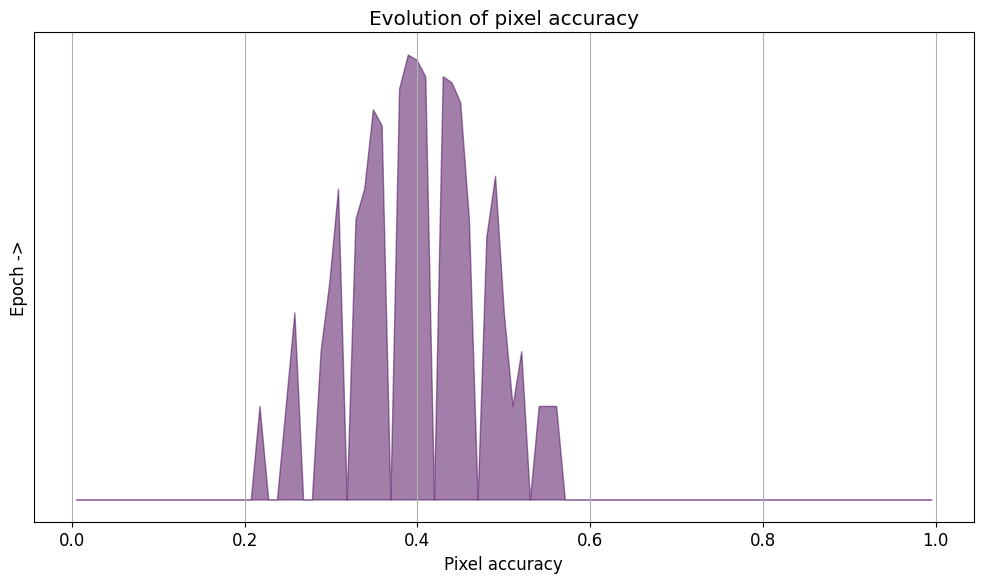

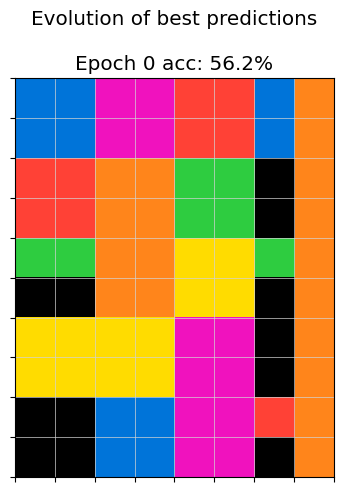

2025-05-06 16:20:44,091 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 16:20:44,201 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/254 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/254 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/254 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/254 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 254
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 254
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 16:21:34,054 - arc25.logging - INFO - wrapper - Executed finetuning in 49.9630 seconds
2025-05-06 16:21:34,056 - root - INFO - hindsight_experience_replay - Starting epoch 1...
2025-05-06 16:21:34,056 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 16:22:35,524 - root - INFO - inference - Number of unique outputs: 256/256
2025-05-06 16:22:35,525 - root - INFO - inference - Max pixel accuracy: 0.75
2025-05-06 16:22:35,529 - arc25.logging - INFO - wrapper - Executed inference in 61.4706 seconds


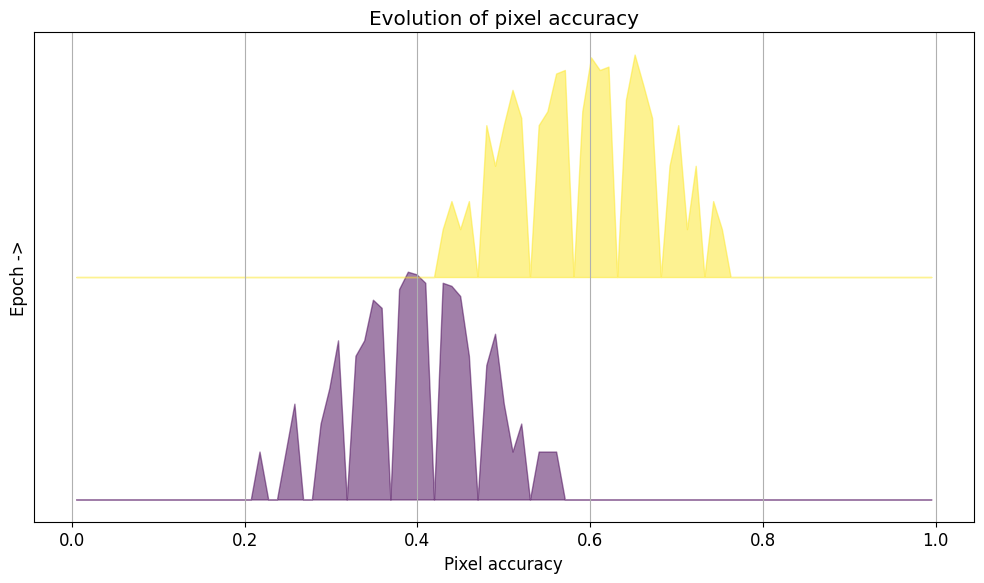

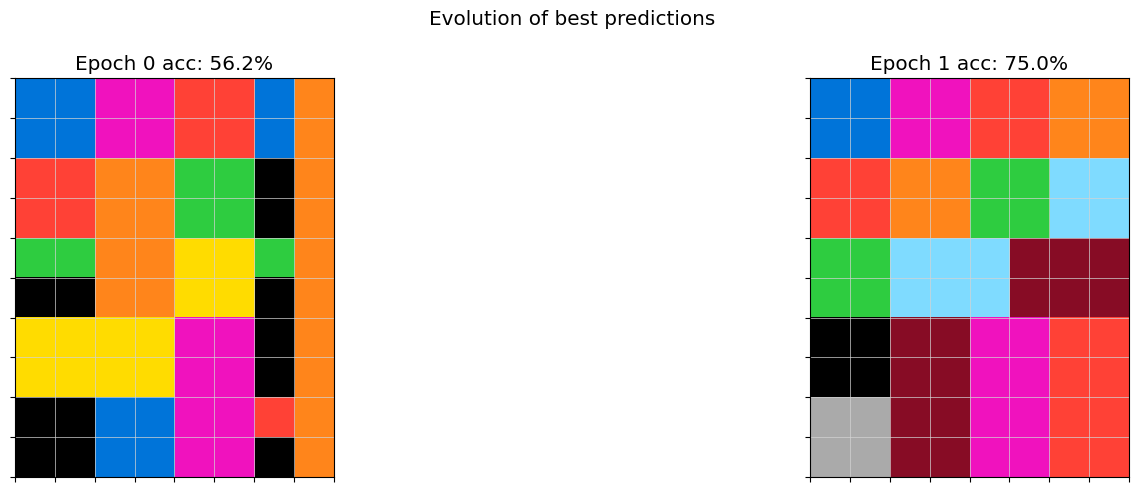

2025-05-06 16:22:35,754 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 16:22:35,843 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/256 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 256
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 256
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 16:23:26,945 - arc25.logging - INFO - wrapper - Executed finetuning in 51.1900 seconds
2025-05-06 16:23:26,946 - root - INFO - hindsight_experience_replay - Starting epoch 2...
2025-05-06 16:23:26,947 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 16:24:34,222 - root - INFO - inference - Number of unique outputs: 246/256
2025-05-06 16:24:34,223 - root - INFO - inference - Max pixel accuracy: 0.85
2025-05-06 16:24:34,227 - arc25.logging - INFO - wrapper - Executed inference in 67.2794 seconds


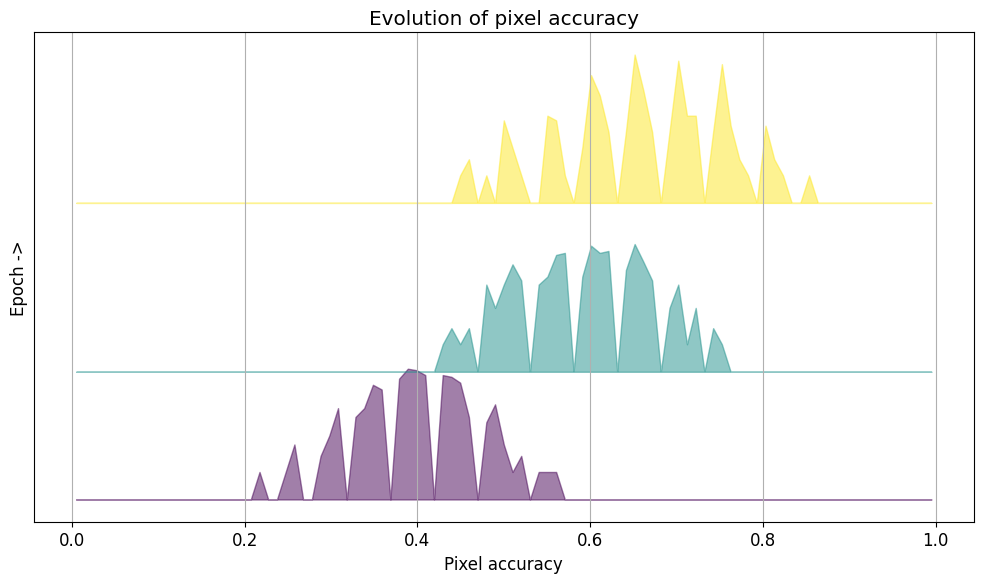

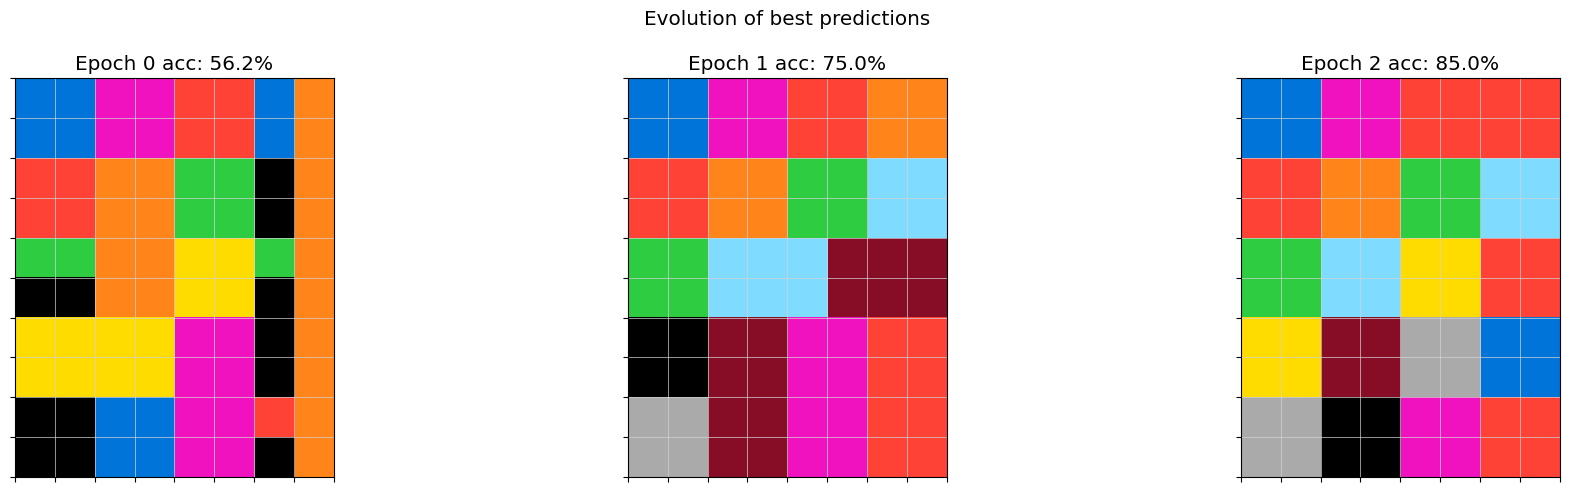

2025-05-06 16:24:34,596 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 16:24:34,707 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/246 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/246 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/246 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/246 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 246
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 246
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 16:25:22,837 - arc25.logging - INFO - wrapper - Executed finetuning in 48.2399 seconds
2025-05-06 16:25:22,838 - root - INFO - hindsight_experience_replay - Starting epoch 3...
2025-05-06 16:25:22,839 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 16:26:29,843 - root - INFO - inference - Number of unique outputs: 204/255
2025-05-06 16:26:29,845 - root - INFO - inference - Max pixel accuracy: 0.95
2025-05-06 16:26:29,848 - arc25.logging - INFO - wrapper - Executed inference in 67.0088 seconds


Error executing code: def task(img):
    draw_rectangle(img, point1=(0, 0), point2=(1, 7), color=1)
    draw_horizontal_line(img, y=4, color=y)
    draw_vertical_line(img, x=4, color=6)
    draw_rectangle(img, point1=(0, 4), point2=(9, 7), color=2)
    draw_rectangle(img, point1=(8, 0), point2=(9, 1), color=5)
    draw_rectangle(img, point1=(6, 2), point2=(7, 5), color=9)
    draw_rectangle(img, point1=(2, 0), point2=(3, 3), color=2)
    draw_rectangle(img, point1=(4, 0), point2=(5, 3), color=3)
    draw_pixel(img, point=(8, 6), color=2)
    draw_rectangle(img, point1=(2, 4), point2=(3, 5), color=3)
    draw_rectangle(img, point1=(0, 2), point2=(1, 3), color=6)
    draw_rectangle(img, point1=(6, 2), point2=(7, 3), color=9)
    draw_rectangle(img, point1=(4, 4), point2=(5, 5), color=4)
    draw_rectangle(img, point1=(6, 4), point2=(9, 7), color=1)
    draw_rectangle(img, point1=(2, 2), point2=(3, 3), color=7)
    draw_rectangle(img, point1=(4, 2), point2=(5, 3), color=8)
    draw_rectan

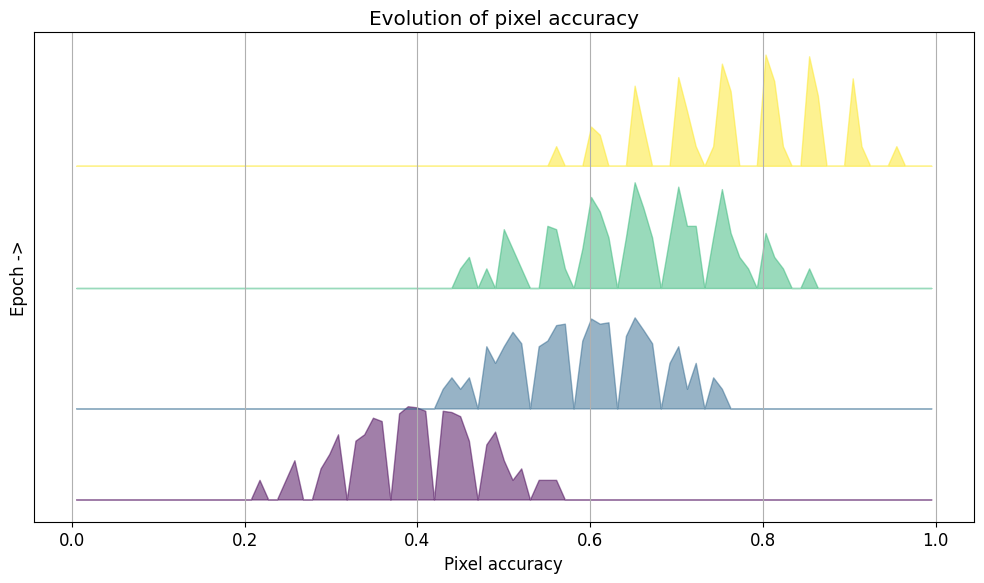

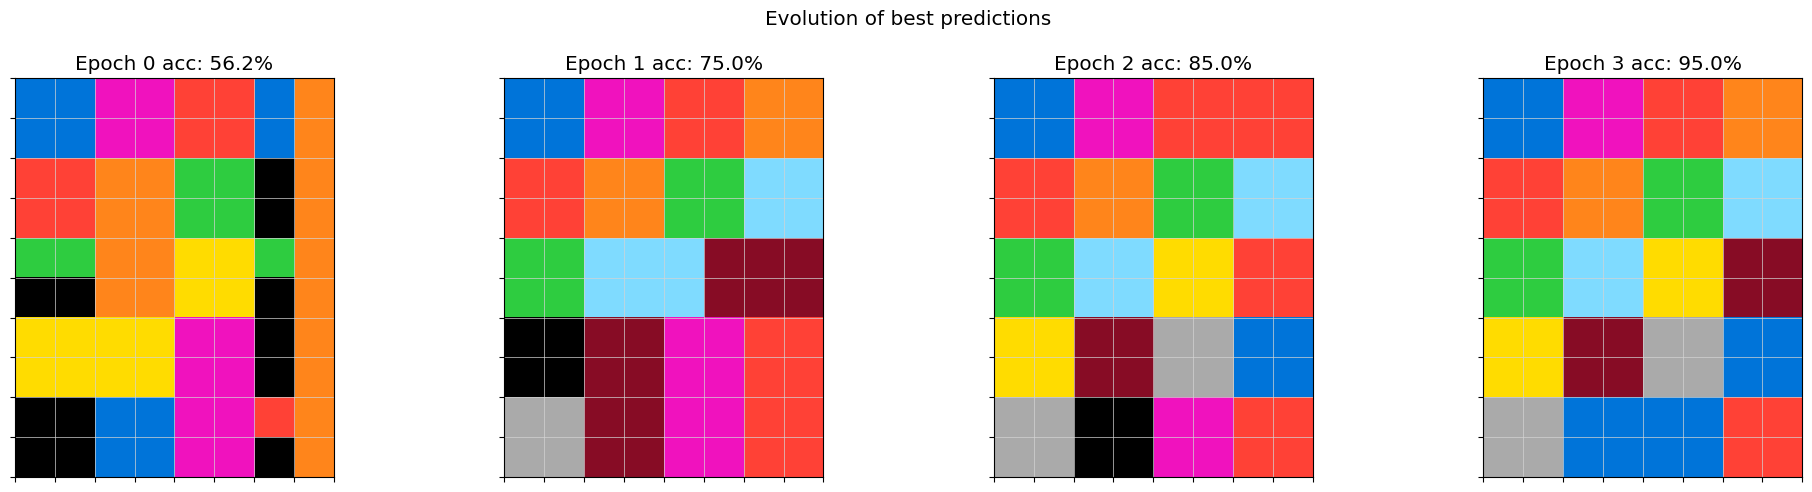

2025-05-06 16:26:30,217 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 16:26:30,297 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/204 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/204 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/204 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/204 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 204
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 204
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 16:27:08,103 - arc25.logging - INFO - wrapper - Executed finetuning in 37.8849 seconds
2025-05-06 16:27:08,104 - root - INFO - hindsight_experience_replay - Starting epoch 4...
2025-05-06 16:27:08,105 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 16:28:37,362 - root - INFO - inference - Number of unique outputs: 106/256
2025-05-06 16:28:37,364 - root - INFO - inference - Max pixel accuracy: 0.9625
2025-05-06 16:28:37,367 - arc25.logging - INFO - wrapper - Executed inference in 89.2615 seconds


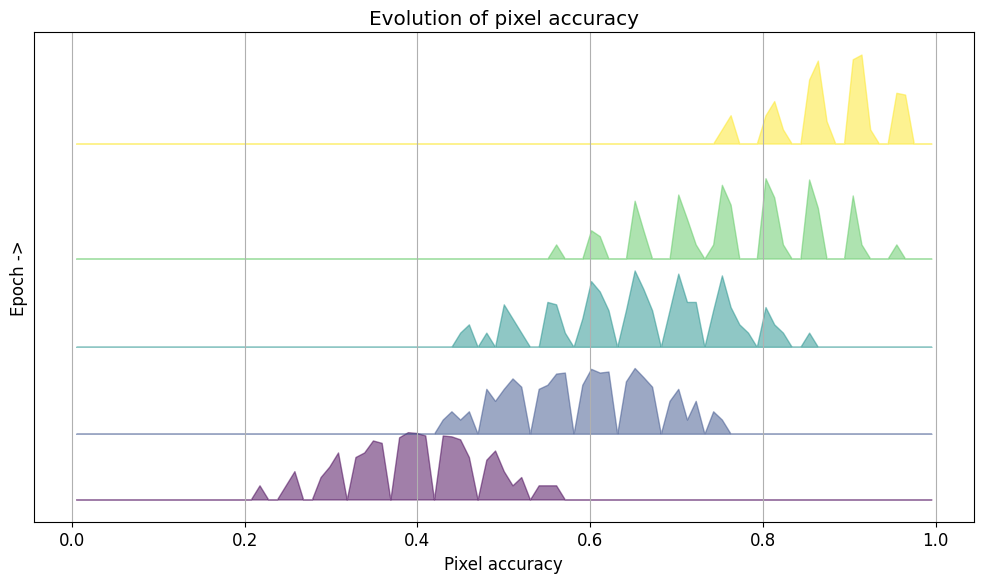

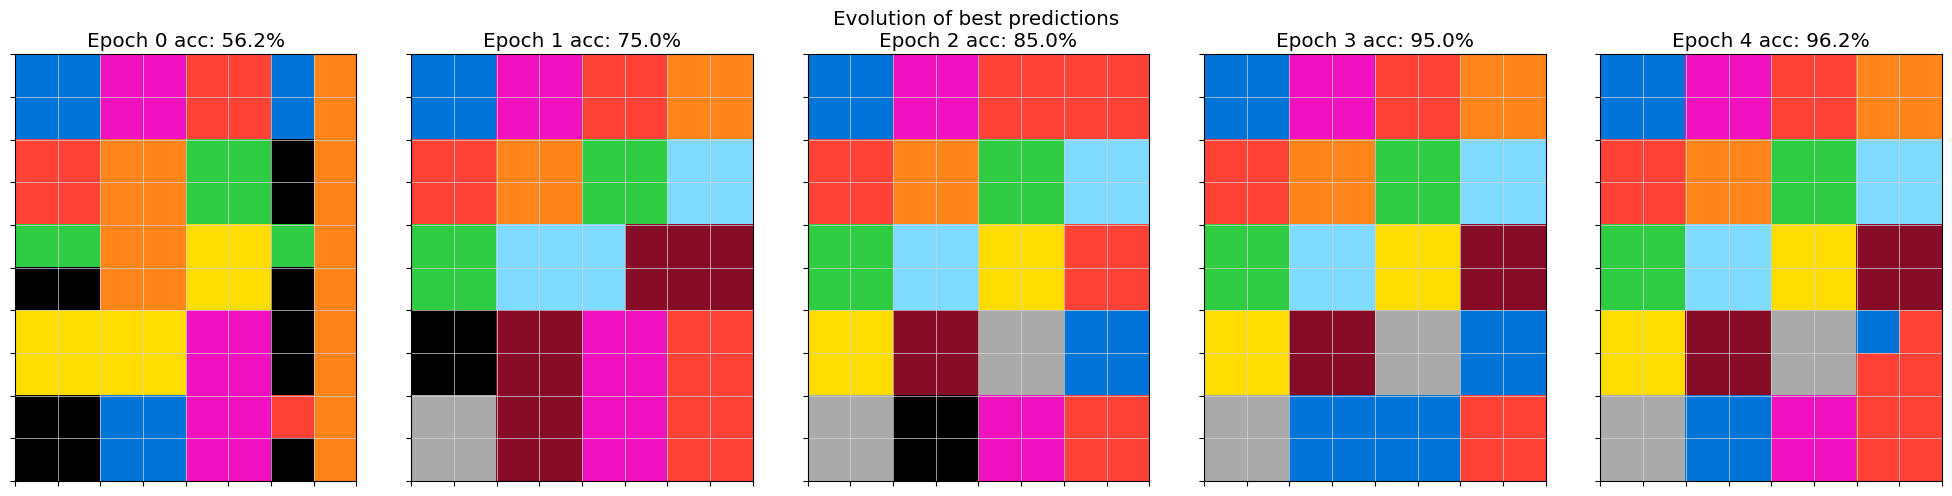

2025-05-06 16:28:37,959 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 16:28:38,028 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/106 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/106 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/106 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/106 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 106
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 106
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 16:29:00,561 - arc25.logging - INFO - wrapper - Executed finetuning in 22.6012 seconds
2025-05-06 16:29:00,563 - root - INFO - hindsight_experience_replay - Starting epoch 5...
2025-05-06 16:29:00,565 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 16:30:33,464 - root - INFO - inference - Number of unique outputs: 86/256
2025-05-06 16:30:33,467 - root - INFO - inference - Max pixel accuracy: 0.9625
2025-05-06 16:30:33,469 - arc25.logging - INFO - wrapper - Executed inference in 92.9036 seconds


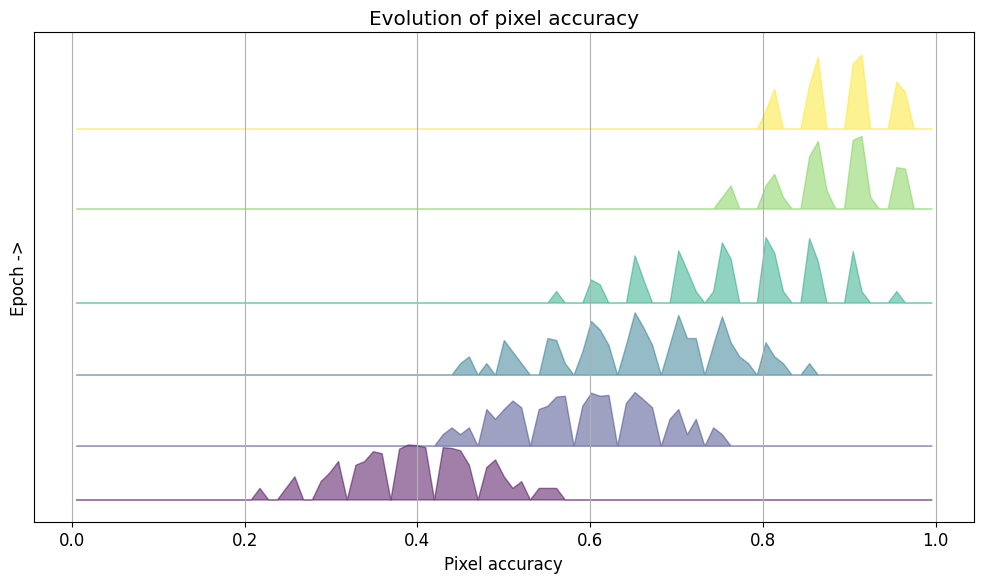

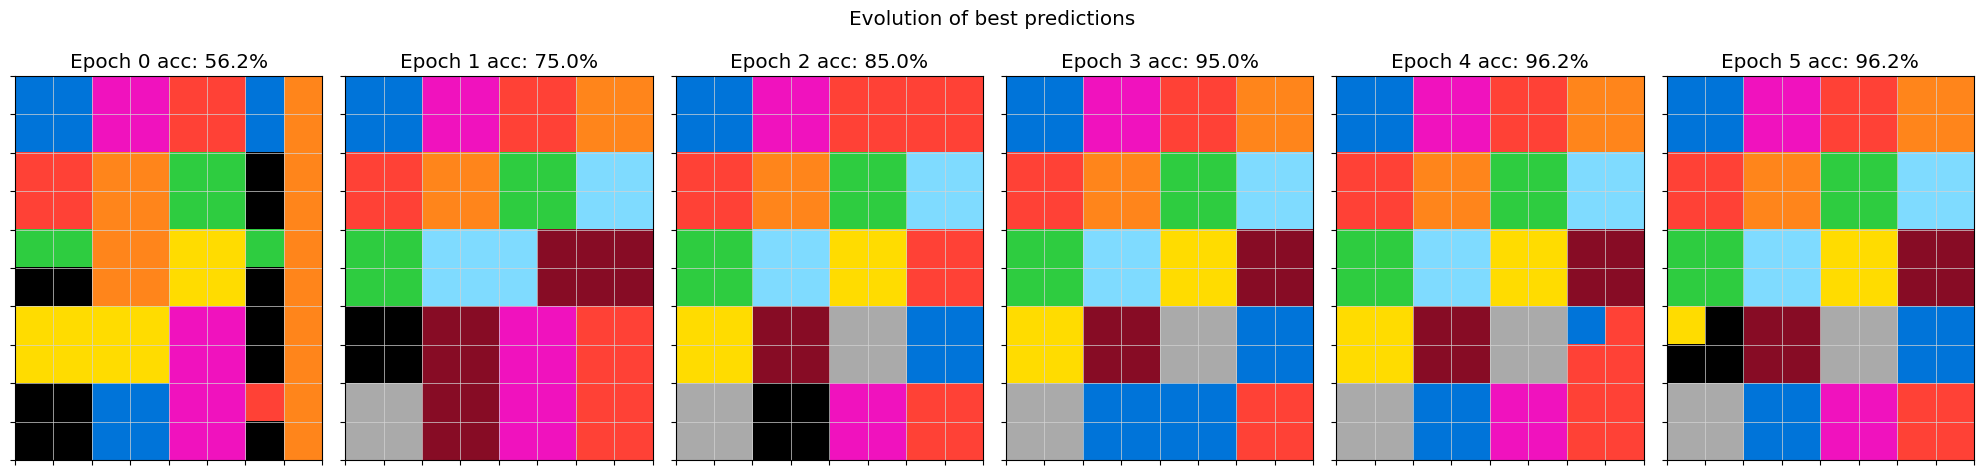

2025-05-06 16:30:33,952 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 16:30:34,023 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/86 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/86 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/86 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/86 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 86
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 86
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 16:30:51,019 - arc25.logging - INFO - wrapper - Executed finetuning in 17.0668 seconds
2025-05-06 16:30:51,020 - root - INFO - hindsight_experience_replay - Starting epoch 6...
2025-05-06 16:30:51,021 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 16:32:21,160 - root - INFO - inference - Number of unique outputs: 53/255
2025-05-06 16:32:21,162 - root - INFO - inference - Max pixel accuracy: 1.0
2025-05-06 16:32:21,170 - arc25.logging - INFO - wrapper - Executed inference in 90.1487 seconds


Error executing code: def task(img):
    draw_rectangle(img, point1=(0, 0), point2=(1, 7), color=1)
    draw_horizontal_line(img, y=4, color=9)
    draw_vertical_line(img, x=4, color=6)
    draw_rectangle(img, point1=(0, 4), point2=(9, 7), color=2)
    draw_rectangle(img, point1=(8, 0), point2=(9, 1), color=5)
    draw_rectangle(img, point1=(6, 2), point2=(7, 5), color=9)
    draw_rectangle(img, point1=(4, 0), point2=(5, 3), color=3)
    draw_pixel(img, point=(8, 6), color=2)
    draw_rectangle(img, point1=(0, 2), point2=(1, 3), color=6)
    draw_rectangle(img, point1=(2, 0), point2=(3, 3), color=2)
    draw_rectangle(img, point1=(4, 4), point2=(5, 5), color=4)
    draw_rectangle(img, point1=(6, 2), point2=(7, 3), color=9)
    draw_rectangle(img, point1=(4, 2), point2=(5, 3), color=8)
    draw_rectangle(img, point1=(2, 4), point2=(3, 5), color=3)
    draw_rectangle(img, point1=(6, 4), point2=(7, 5), color=5)
    draw_rectangle(img, point1=(2, 2), point2=(3, 3), color=7)
    draw_rectan

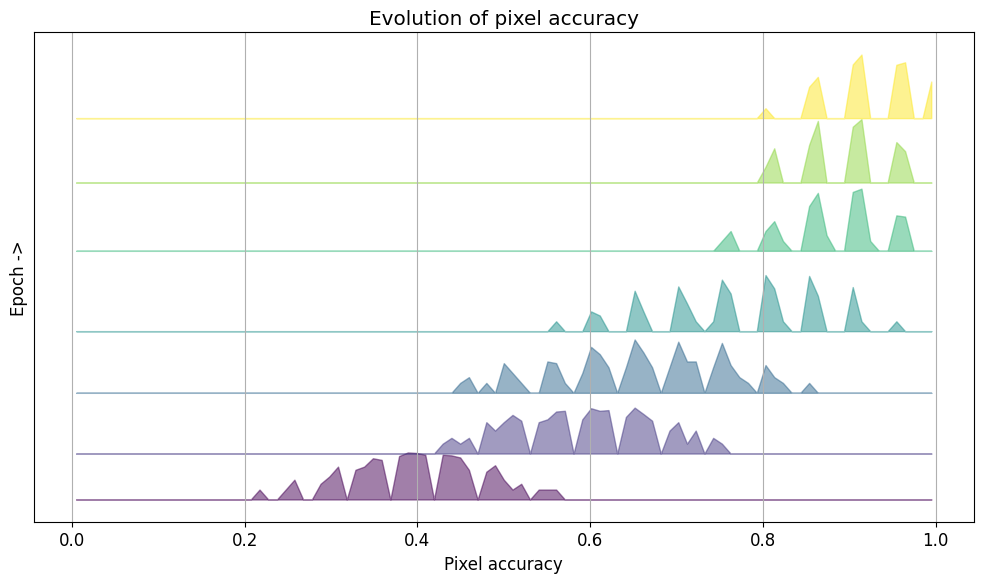

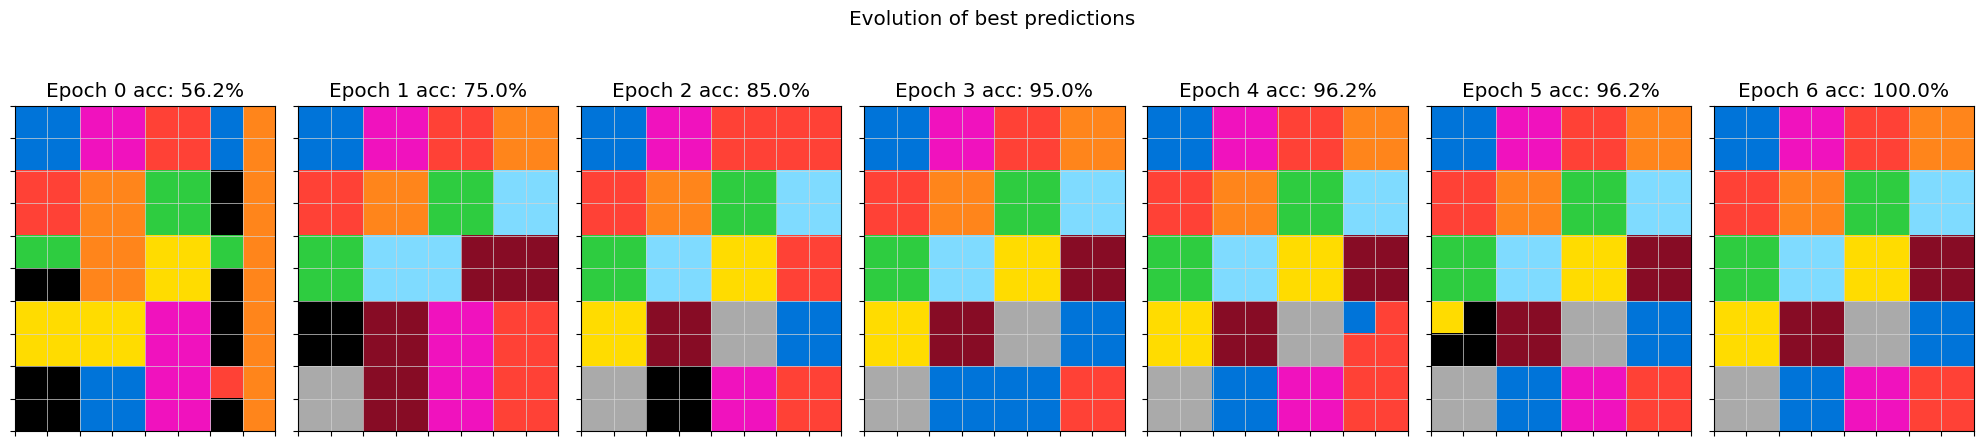

2025-05-06 16:32:21,750 - arc25.input_generation - INFO - hindsight_experience_replay - Found a perfect prediction at epoch 6!


# Best prediction code

```python
def task(img):
    draw_rectangle(img, point1=(0, 0), point2=(1, 7), color=1)
    draw_horizontal_line(img, y=4, color=9)
    draw_vertical_line(img, x=4, color=6)
    draw_rectangle(img, point1=(0, 4), point2=(9, 7), color=2)
    draw_rectangle(img, point1=(8, 0), point2=(9, 1), color=5)
    draw_rectangle(img, point1=(0, 2), point2=(7, 3), color=6)
    draw_rectangle(img, point1=(6, 2), point2=(7, 5), color=9)
    draw_rectangle(img, point1=(2, 0), point2=(3, 3), color=2)
    draw_pixel(img, point=(8, 6), color=2)
    draw_rectangle(img, point1=(4, 0), point2=(5, 3), color=3)
    draw_rectangle(img, point1=(0, 6), point2=(1, 7), color=7)
    draw_rectangle(img, point1=(2, 4), point2=(3, 5), color=3)
    draw_rectangle(img, point1=(6, 2), point2=(7, 3), color=9)
    draw_rectangle(img, point1=(4, 4), point2=(5, 5), color=4)
    draw_rectangle(img, point1=(6, 4), point2=(7, 5), color=5)
    draw_rectangle(img, point1=(2, 2), point2=(3, 3), color=7)
    draw_rectangle(img, point1=(4, 2), point2=(5, 3), color=8)
    draw_rectangle(img, point1=(2, 6), point2=(3, 7), color=8)
    draw_rectangle(img, point1=(8, 2), point2=(9, 3), color=1)
    draw_rectangle(img, point1=(4, 6), point2=(5, 7), color=9)
    draw_rectangle(img, point1=(6, 0), point2=(7, 1), color=4)
    draw_rectangle(img, point1=(8, 4), point2=(9, 5), color=6)
    draw_rectangle(img, point1=(2, 4), point2=(3, 5), color=3)
    draw_rectangle(img, point1=(6, 2), point2=(7, 3), color=9)
    draw_rectangle(img, point1=(4, 4), point2=(5, 5), color=4)
    draw_rectangle(img, point1=(6, 6), point2=(7, 7), color=1)
    return img
```

2025-05-06 16:32:21,817 - arc25.logging - INFO - wrapper - Executed hindsight_experience_replay in 736.7827 seconds


In [8]:
input_img = create_img((10, 8), color=0)
output_img = input_img.copy()
color = 0
for x in range(0, input_img.shape[1], 2):
    for y in range(0, input_img.shape[0], 2):
        color = (color + 1) % 10
        if color == 0: color = 1
        draw_rectangle(output_img, (y, x), (y+1, x+1), color=color)
task = Task(inputs=[input_img], outputs=[output_img], code='', name='manual')
metrics = hindsight_experience_replay(task, Config())

#### 25 squares

2025-05-06 18:09:00,327 - arc25.logging - INFO - wrapper - Executing hindsight_experience_replay...


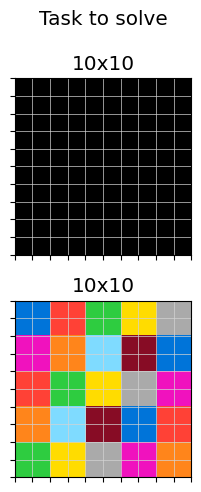

2025-05-06 18:09:00,508 - arc25.logging - INFO - wrapper - Executing load_model...
2025-05-06 18:09:00,509 - root - INFO - load_model - Loading model from /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct and LoRA from /mnt/hdd0/Kaggle/arc25/trainings/20250430_first_trainings/steps_6400/checkpoint-6400
loading configuration file /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct/config.json
Model config Qwen2Config {
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 896,
  "initializer_range": 0.02,
  "intermediate_size": 4864,
  "max_position_embeddings": 32768,
  "max_window_layers": 24,
  "model_type": "qwen2",
  "num_attention_heads": 14,
  "num_hidden_layers": 24,
  "num_key_value_heads": 2,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 1000000.0,
  "sliding_window": 32768,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "tra

  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 18:09:43,759 - root - INFO - inference - Number of unique outputs: 253/253
2025-05-06 18:09:43,760 - root - INFO - inference - Max pixel accuracy: 0.44
2025-05-06 18:09:43,764 - arc25.logging - INFO - wrapper - Executed inference in 41.9288 seconds


Error executing code: def task(img):
    draw_horizontal_line(img, y=8, num_words=7)
    draw_rectangle(img, point1=(6, 0), point2=(9, 8), color=7)
    draw_vertical_line(img, x=4, color=8)
    draw_horizontal_line(img, y=4, color=2)
    draw_rectangle(img, point1=(0, 2), point2=(1, 9), color=2)
    draw_rectangle(img, point1=(0, 0), point2=(1, 1), color=1)
    draw_rectangle(img, point1=(0, 4), point2=(1, 5), color=3)
    draw_rectangle(img, point1=(2, 6), point2=(3, 7), color=8)
    draw_pixel(img, point=(2, 8), color=1)
    draw_rectangle(img, point1=(2, 2), point2=(7, 3), color=7)
    draw_rectangle(img, point1=(0, 7), point2=(1, 9), color=5)
    return img
draw_horizontal_line() got an unexpected keyword argument 'num_words'
Error executing code: def task(img):
    draw_horizontal_line(img, y=8, bottom=9, color=7)
    draw_rectangle(img, point1=(0, 8), point2=(1, 9), color=5)
    draw_rectangle(img, point1=(0, 0), point2=(7, 7), color=1)
    draw_rectangle(img, point1=(0, 4), poin

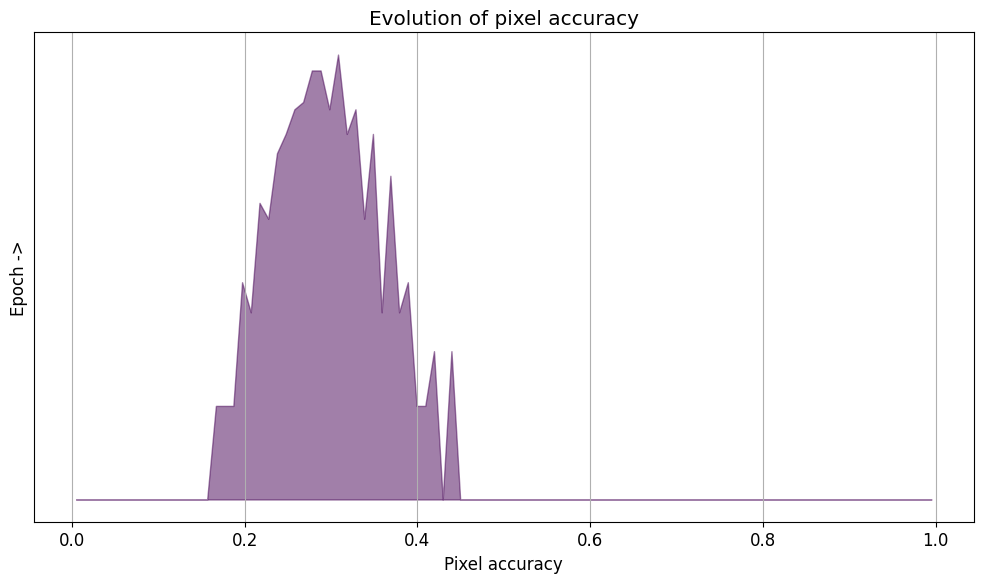

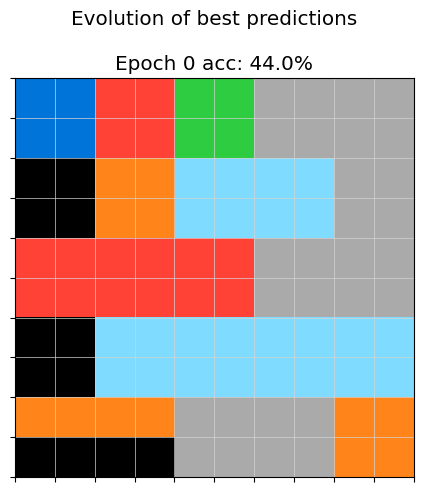

2025-05-06 18:09:43,938 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 18:09:44,050 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/253 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/253 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/253 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/253 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 253
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 253
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 18:10:32,676 - arc25.logging - INFO - wrapper - Executed finetuning in 48.7374 seconds
2025-05-06 18:10:32,677 - root - INFO - hindsight_experience_replay - Starting epoch 1...
2025-05-06 18:10:32,678 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 18:12:55,743 - root - INFO - inference - Number of unique outputs: 255/255
2025-05-06 18:12:55,745 - root - INFO - inference - Max pixel accuracy: 0.63
2025-05-06 18:12:55,754 - arc25.logging - INFO - wrapper - Executed inference in 143.0755 seconds


Error executing code: def task(img):
    draw_rectangle(img, point1=(0, 0), point2=(1, 9), color=1)
    draw_horizontal_line(img, y=8, color=7)
    draw_rectangle(img, point1=(0, 4), point2=(9, 7), color=4)
    draw_rectangle(img, point1=(0, 2), point2=(6, 3), color=2)
    draw_rectangle(img, point1=(2, 0), point2=(3, 3), color=6)
    draw_rectangle(img, point1=(0, 4), point2=(1, 5), color=3)
    draw_vertical_line(img, x=8, color=5)
    draw_pixel(img, point=(8, 8), color=6)
    draw_rectangle(img, point1=(4, 2), point2=(5, 3), color=3)
    draw_rectangle(img, point1=(6, 2), point2=(7, 3), color=8)
    draw_rectangle(img, point1=(0, 4), point2=(1, 5), color=3)
    draw_rectangle(img, point1=(2, 6), point2=(3, 7), color=8)
    draw_rectangle(img, point1=(0, 0), point2=(1, 1), color=1)
    draw_rectangle(img, point1=(2, 4), point2=(3, 5), color=8)
    draw_rectangle(img, point1=(6, 0), point2=(9, 5), color=7)
    draw_rectangle(img, point1=(2, 2), point2=(3, 3), color=7)
    draw_rectan

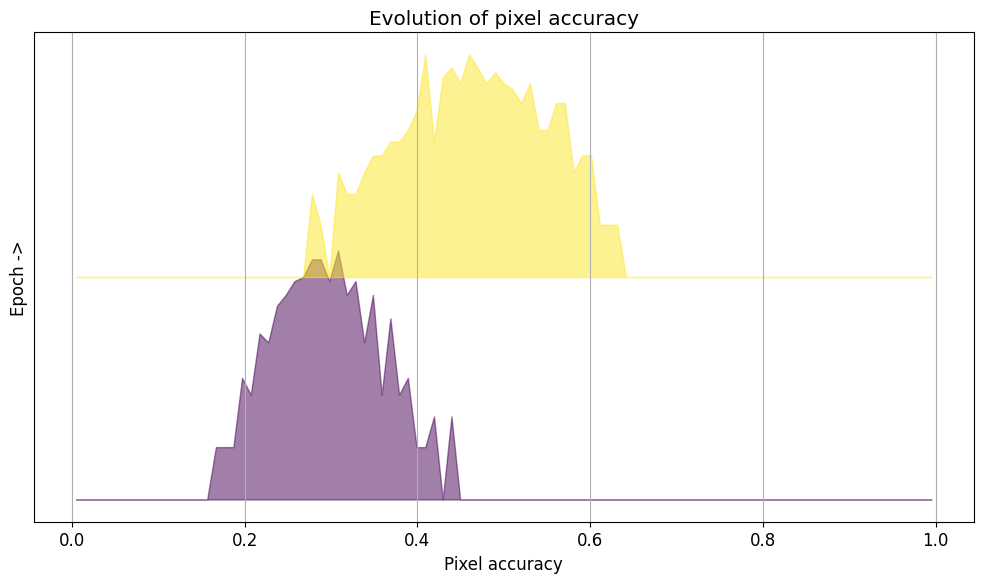

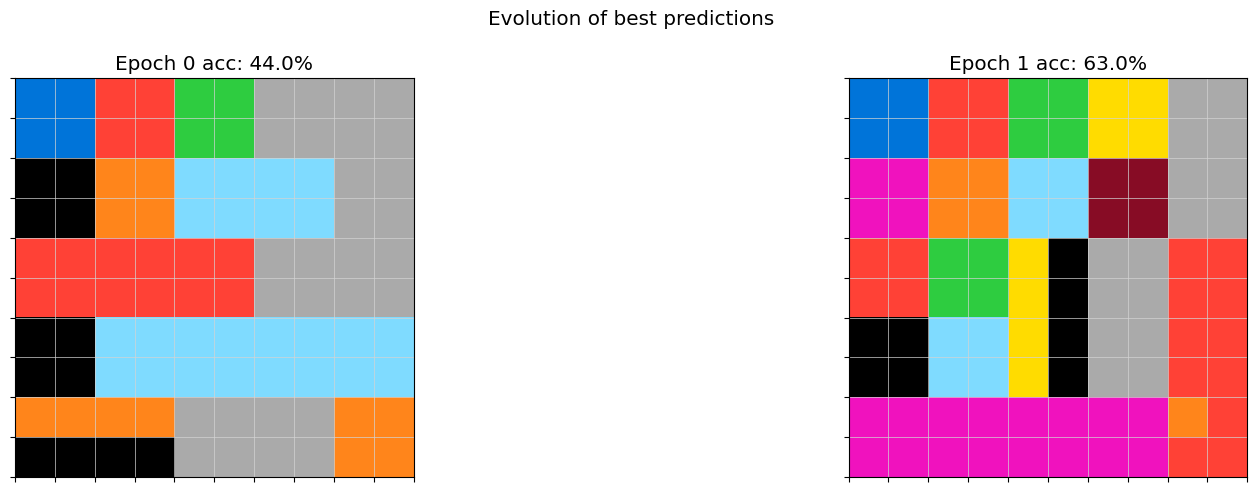

2025-05-06 18:12:56,033 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 18:12:56,174 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/255 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/255 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/255 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/255 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 255
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 255
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 18:13:48,481 - arc25.logging - INFO - wrapper - Executed finetuning in 52.4466 seconds
2025-05-06 18:13:48,483 - root - INFO - hindsight_experience_replay - Starting epoch 2...
2025-05-06 18:13:48,484 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 18:16:12,174 - root - INFO - inference - Number of unique outputs: 248/255
2025-05-06 18:16:12,176 - root - INFO - inference - Max pixel accuracy: 0.87
2025-05-06 18:16:12,180 - arc25.logging - INFO - wrapper - Executed inference in 143.6954 seconds


Error executing code: def task(img):
    draw_rectangle(img, point1=(0, 0), point2=(1, 9), color=5)
    draw_horizontal_line(img, y=8, color=7)
    draw_rectangle(img, point1=(0, 4), point2=(9, 7), color=5)
    draw_rectangle(img, point1=(0, 2), point2=(7, 3), color=8)
    draw_rectangle(img, point1=(0, 2), point2=(1, 3), color=2)
    draw_rectangle(img, point1=(0, 4), point2=(1, 5), color=3)
    draw_rectangle(img, point1=(2, 0), point2=(3, 1), color=6)
    draw_rectangle(img, point1=(0, 6), point2=(1, 7), color=4)
    draw_rectangle(img, point1=(4, 2), point2=(5, 3), color=3)
    draw_rectangle(img, point1=(2, 4), point2=(3, 5), color=8)
    draw_rectangle(img, point1=(6, 0), point2=(7, 1), color=7)
    draw_rectangle(img, point1=(0, 8), point2=(1, 9), color=5)
    draw_rectangle(img, point1=(2, 6), point2=(3, 7), color=9)
    draw_rectangle(img, point1=(4, 8), point2=(5, 9), color=6)
    draw_rectangle(img, point1=(0, 0), point2=(1, 1), color=1)
    draw_rectangle(img, point1=(2, 2)

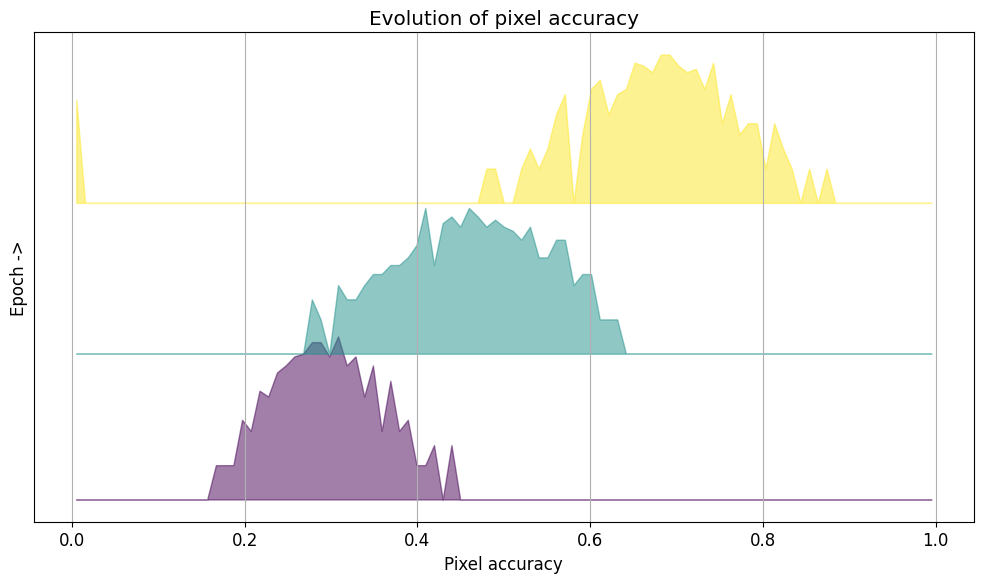

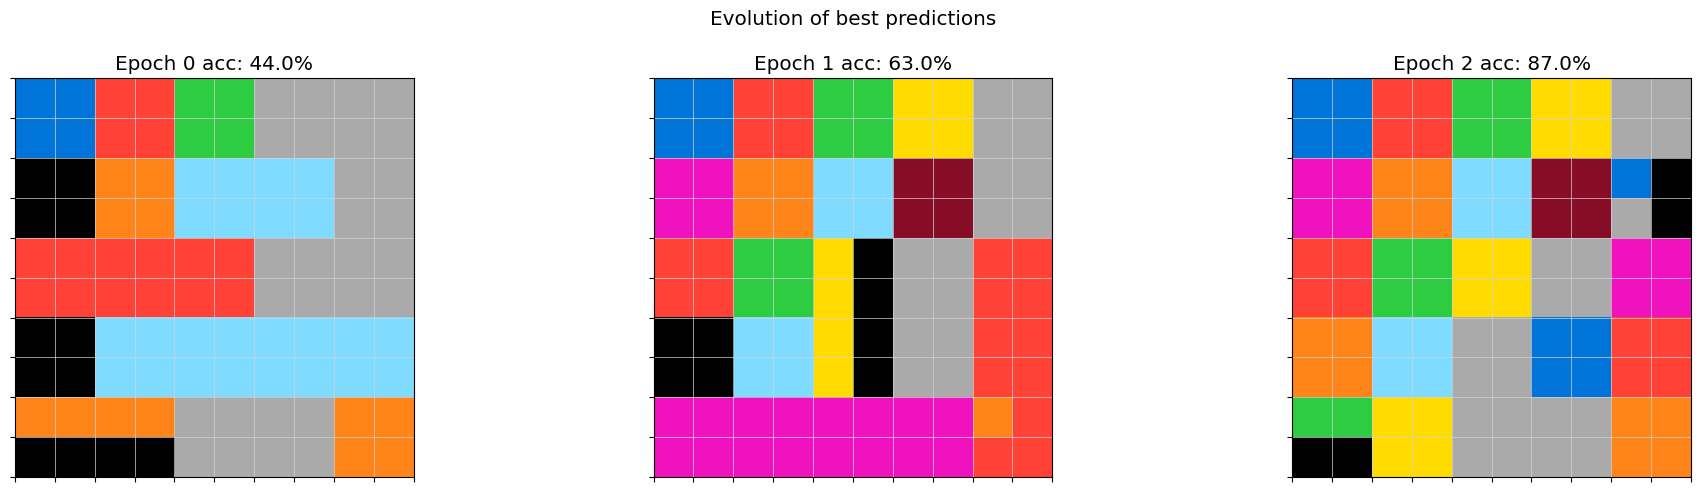

2025-05-06 18:16:12,503 - arc25.logging - INFO - wrapper - Executing finetuning...


TypeError: object of type 'NoneType' has no len()

In [13]:
input_img = create_img((10, 10), color=0)
output_img = input_img.copy()
color = 0
for x in range(0, input_img.shape[1], 2):
    for y in range(0, input_img.shape[0], 2):
        color = (color + 1) % 10
        if color == 0: color = 1
        draw_rectangle(output_img, (x, y), (x+1, y+1), color=color)
task = Task(inputs=[input_img], outputs=[output_img], code='', name='manual')
metrics = hindsight_experience_replay(task, Config())

### Pixels

#### 12 pixels

2025-05-06 17:02:58,966 - arc25.logging - INFO - wrapper - Executing hindsight_experience_replay...


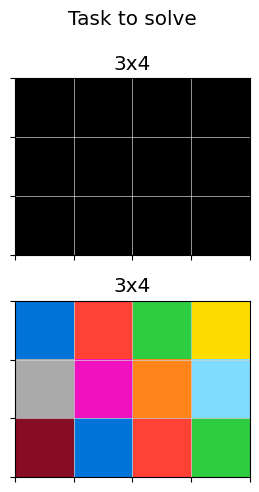

2025-05-06 17:02:59,085 - arc25.logging - INFO - wrapper - Executing load_model...
2025-05-06 17:02:59,086 - root - INFO - load_model - Loading model from /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct and LoRA from /mnt/hdd0/Kaggle/arc25/trainings/20250430_first_trainings/steps_6400/checkpoint-6400
loading configuration file /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct/config.json
Model config Qwen2Config {
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 896,
  "initializer_range": 0.02,
  "intermediate_size": 4864,
  "max_position_embeddings": 32768,
  "max_window_layers": 24,
  "model_type": "qwen2",
  "num_attention_heads": 14,
  "num_hidden_layers": 24,
  "num_key_value_heads": 2,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 1000000.0,
  "sliding_window": 32768,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "tra

  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 17:03:17,510 - root - INFO - inference - Number of unique outputs: 253/256
2025-05-06 17:03:17,511 - root - INFO - inference - Max pixel accuracy: 0.8333333333333334
2025-05-06 17:03:17,515 - arc25.logging - INFO - wrapper - Executed inference in 16.9887 seconds


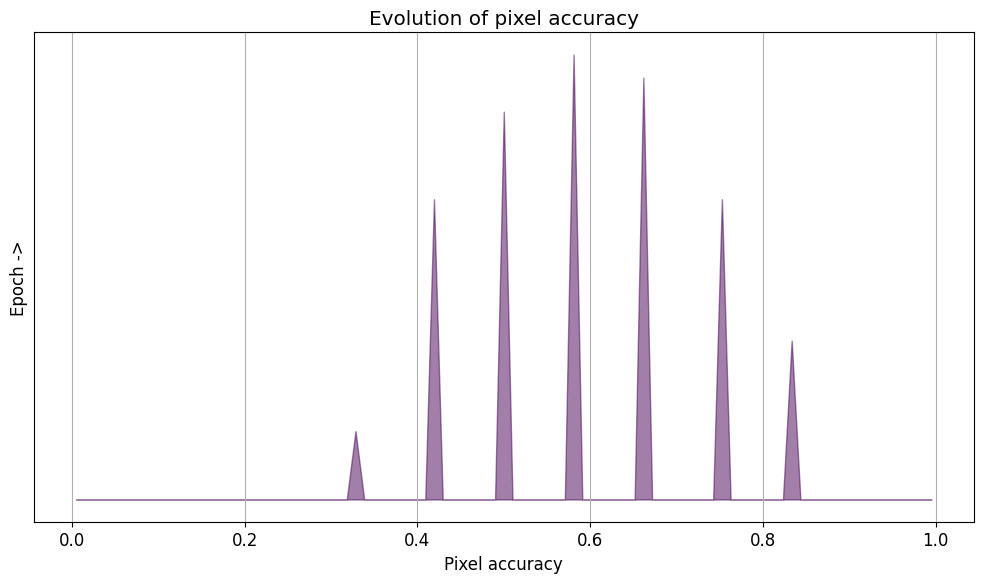

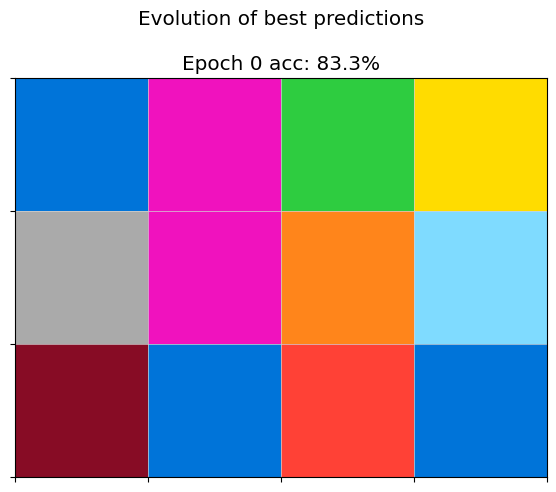

2025-05-06 17:03:17,689 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 17:03:17,758 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/253 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/253 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/253 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/253 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 253
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 253
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 17:04:06,824 - arc25.logging - INFO - wrapper - Executed finetuning in 49.1339 seconds
2025-05-06 17:04:06,826 - root - INFO - hindsight_experience_replay - Starting epoch 1...
2025-05-06 17:04:06,827 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 17:04:27,400 - root - INFO - inference - Number of unique outputs: 193/256
2025-05-06 17:04:27,401 - root - INFO - inference - Max pixel accuracy: 0.9166666666666666
2025-05-06 17:04:27,409 - arc25.logging - INFO - wrapper - Executed inference in 20.5815 seconds


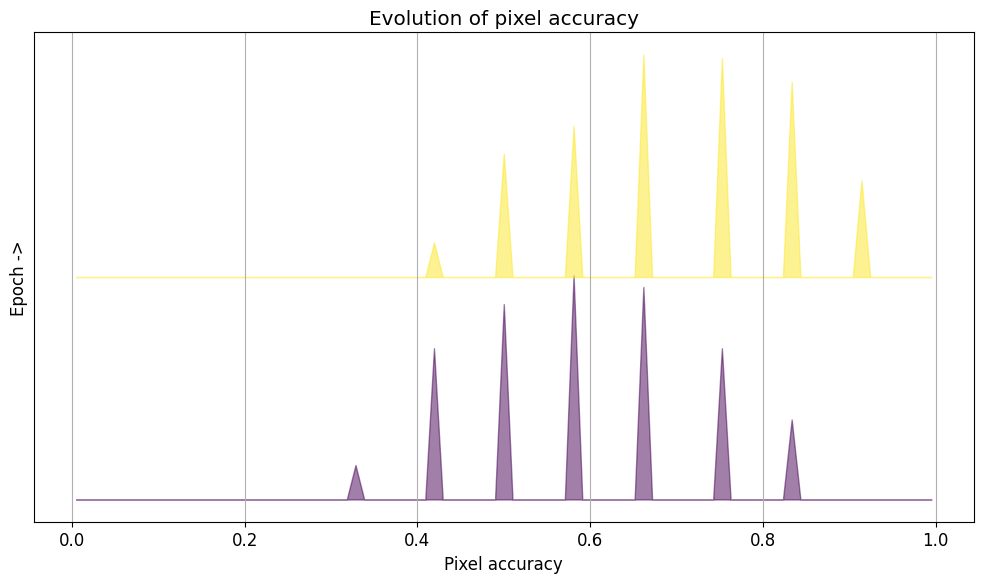

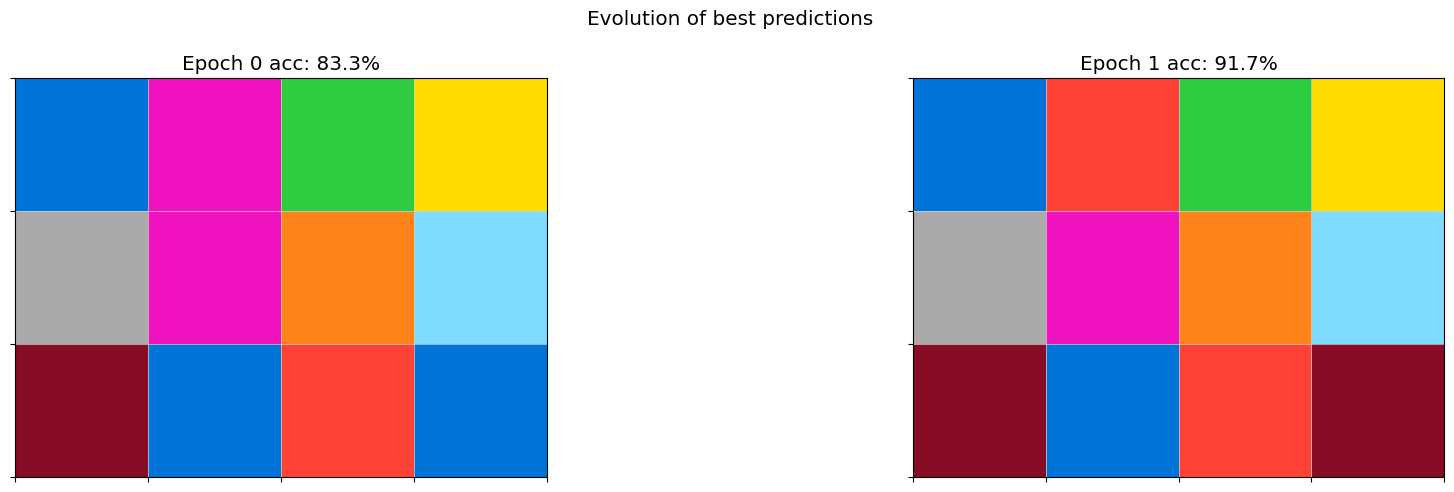

2025-05-06 17:04:27,648 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 17:04:27,709 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/193 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/193 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/193 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/193 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 193
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 193
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 17:05:04,334 - arc25.logging - INFO - wrapper - Executed finetuning in 36.6844 seconds
2025-05-06 17:05:04,335 - root - INFO - hindsight_experience_replay - Starting epoch 2...
2025-05-06 17:05:04,335 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 17:05:24,553 - root - INFO - inference - Number of unique outputs: 93/256
2025-05-06 17:05:24,554 - root - INFO - inference - Max pixel accuracy: 0.9166666666666666
2025-05-06 17:05:24,556 - arc25.logging - INFO - wrapper - Executed inference in 20.2209 seconds


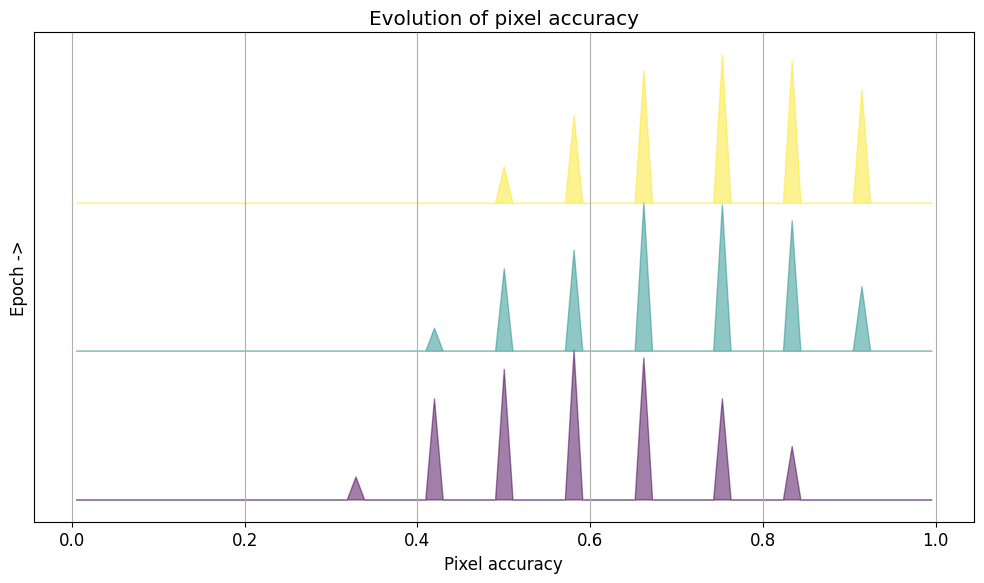

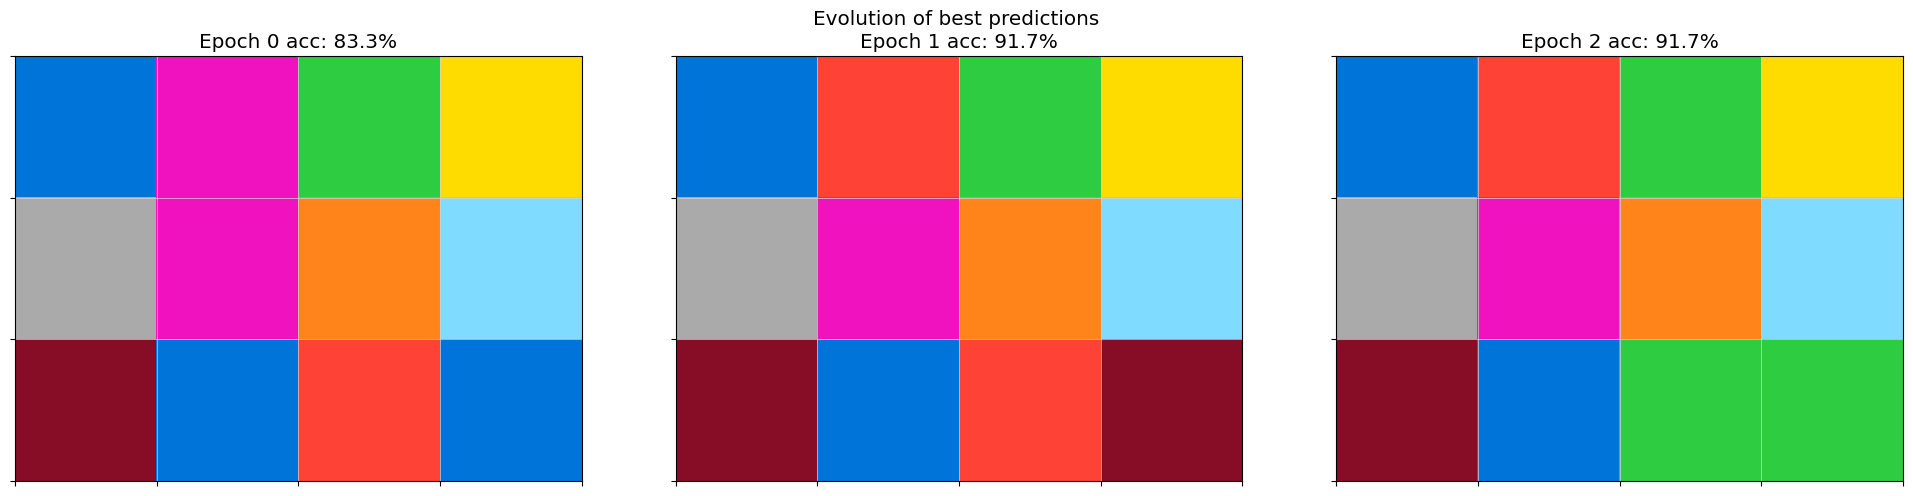

2025-05-06 17:05:24,809 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 17:05:24,865 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/93 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/93 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/93 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/93 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 93
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 93
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 17:05:42,211 - arc25.logging - INFO - wrapper - Executed finetuning in 17.4004 seconds
2025-05-06 17:05:42,211 - root - INFO - hindsight_experience_replay - Starting epoch 3...
2025-05-06 17:05:42,212 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 17:06:04,019 - root - INFO - inference - Number of unique outputs: 38/256
2025-05-06 17:06:04,021 - root - INFO - inference - Max pixel accuracy: 1.0
2025-05-06 17:06:04,022 - arc25.logging - INFO - wrapper - Executed inference in 21.8105 seconds


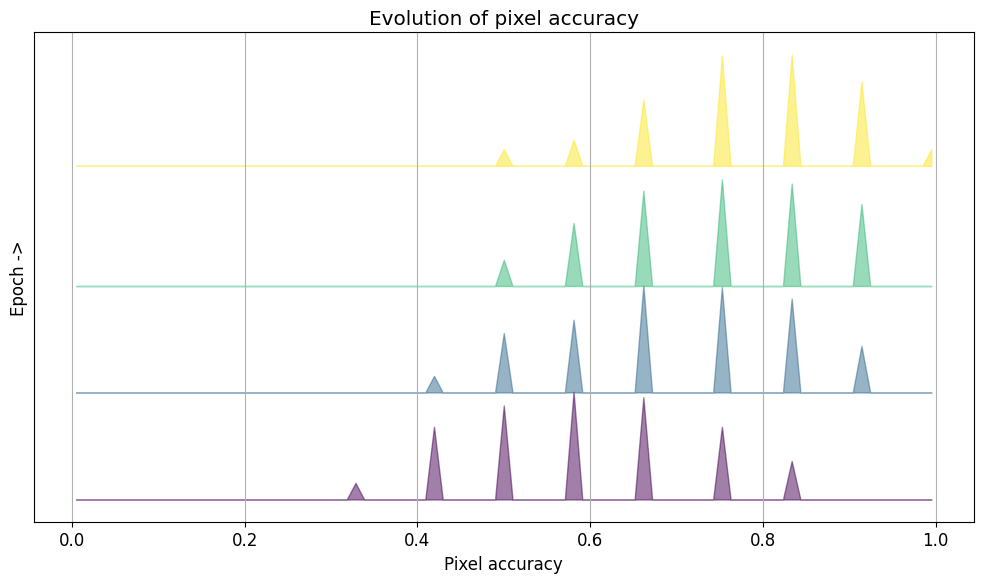

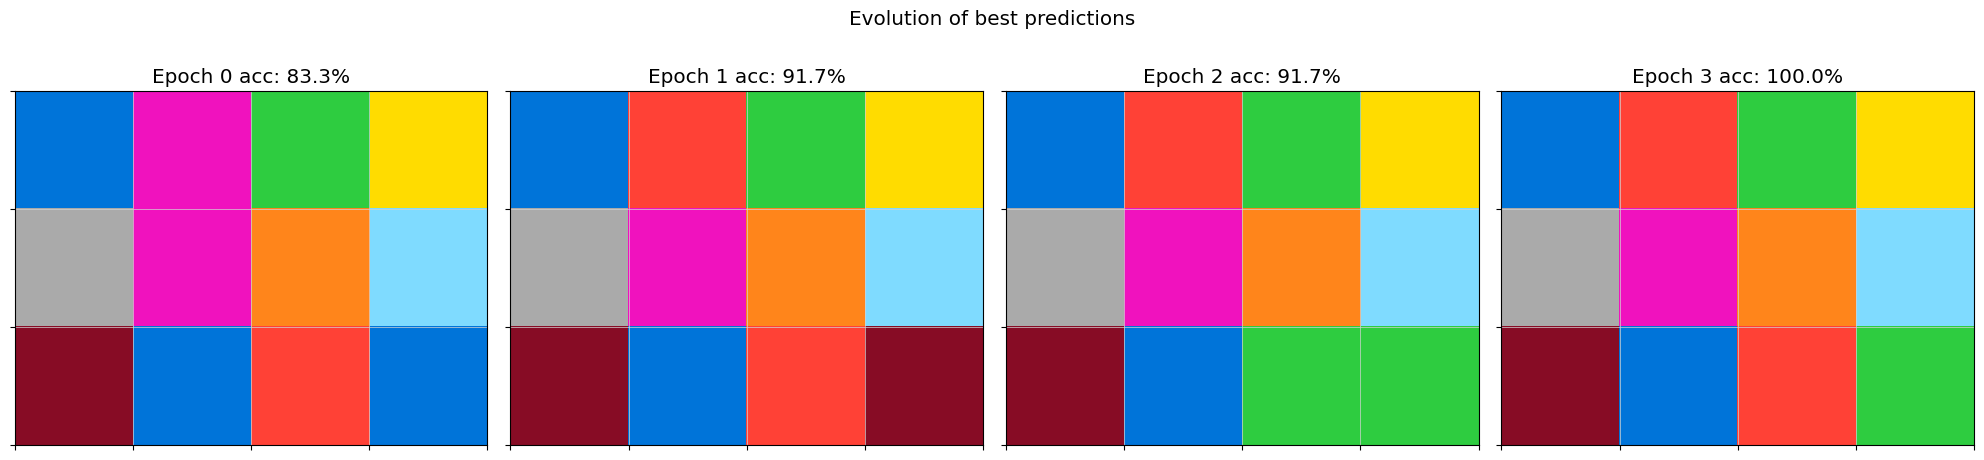

2025-05-06 17:06:04,344 - arc25.input_generation - INFO - hindsight_experience_replay - Found a perfect prediction at epoch 3!


# Best prediction code

```python
def task(img):
    draw_horizontal_line(img, y=2, color=9)
    draw_vertical_line(img, x=1, color=1)
    draw_pixel(img, point=(0, 0), color=1)
    draw_rectangle(img, point1=(0, 2), point2=(2, 3), color=3)
    draw_pixel(img, point=(0, 3), color=4)
    draw_pixel(img, point=(1, 1), color=6)
    draw_pixel(img, point=(1, 2), color=7)
    draw_pixel(img, point=(1, 3), color=8)
    draw_pixel(img, point=(2, 1), color=1)
    draw_pixel(img, point=(1, 0), color=5)
    draw_pixel(img, point=(2, 1), color=1)
    draw_pixel(img, point=(2, 2), color=2)
    draw_pixel(img, point=(0, 2), color=3)
    draw_pixel(img, point=(0, 1), color=2)
    return img
```

2025-05-06 17:06:04,399 - arc25.logging - INFO - wrapper - Executed hindsight_experience_replay in 185.4307 seconds


In [10]:
input_img = create_img((3, 4), color=0)
output_img = input_img.copy()
color = 0
for y in range(0, input_img.shape[0], 1):
    for x in range(0, input_img.shape[1], 1):
        color = (color + 1) % 10
        if color == 0: color = 1
        draw_pixel(output_img, (y, x), color=color)
task = Task(inputs=[input_img], outputs=[output_img], code='', name='manual')
hindsight_experience_replay(task, Config());

#### 20 pixels

2025-05-06 17:10:39,153 - arc25.logging - INFO - wrapper - Executing hindsight_experience_replay...


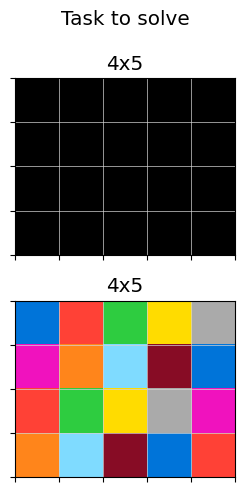

2025-05-06 17:10:39,269 - arc25.logging - INFO - wrapper - Executing load_model...
2025-05-06 17:10:39,270 - root - INFO - load_model - Loading model from /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct and LoRA from /mnt/hdd0/Kaggle/arc25/trainings/20250430_first_trainings/steps_6400/checkpoint-6400
loading configuration file /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct/config.json
Model config Qwen2Config {
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 896,
  "initializer_range": 0.02,
  "intermediate_size": 4864,
  "max_position_embeddings": 32768,
  "max_window_layers": 24,
  "model_type": "qwen2",
  "num_attention_heads": 14,
  "num_hidden_layers": 24,
  "num_key_value_heads": 2,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 1000000.0,
  "sliding_window": 32768,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "tra

  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 17:11:03,674 - root - INFO - inference - Number of unique outputs: 256/256
2025-05-06 17:11:03,675 - root - INFO - inference - Max pixel accuracy: 0.55
2025-05-06 17:11:03,679 - arc25.logging - INFO - wrapper - Executed inference in 23.1548 seconds


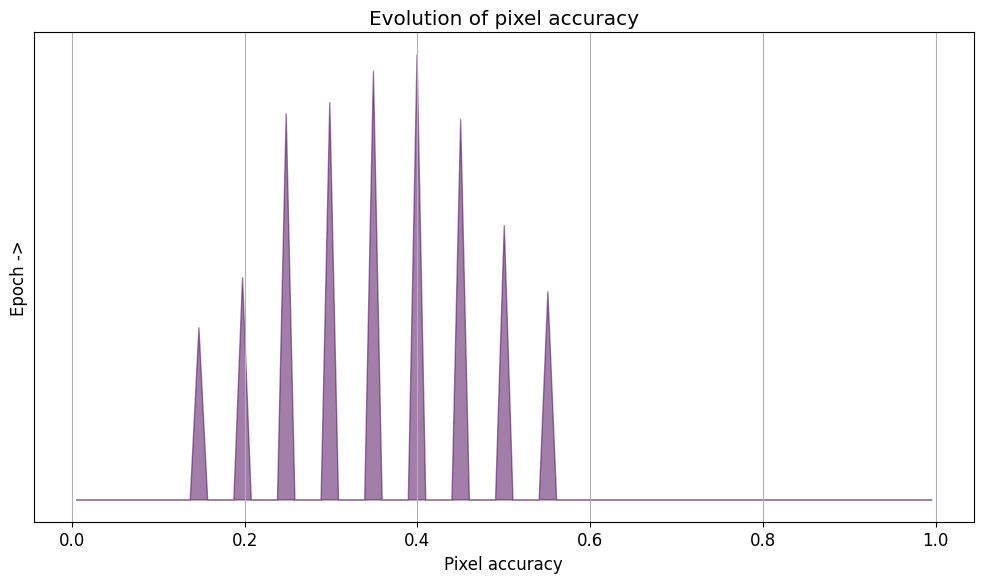

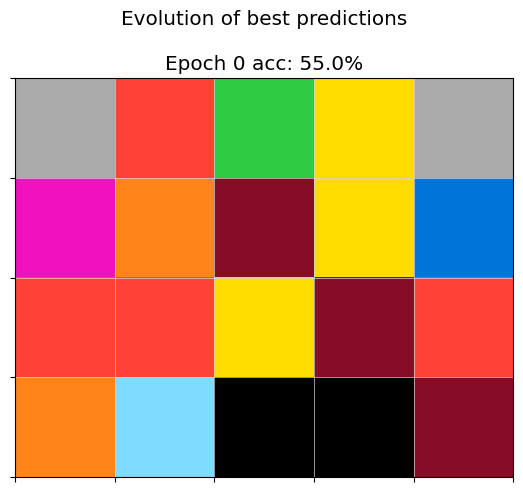

2025-05-06 17:11:03,824 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 17:11:03,894 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/256 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 256
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 256
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 17:11:56,231 - arc25.logging - INFO - wrapper - Executed finetuning in 52.4056 seconds
2025-05-06 17:11:56,233 - root - INFO - hindsight_experience_replay - Starting epoch 1...
2025-05-06 17:11:56,234 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 17:12:24,614 - root - INFO - inference - Number of unique outputs: 256/256
2025-05-06 17:12:24,616 - root - INFO - inference - Max pixel accuracy: 0.7
2025-05-06 17:12:24,627 - arc25.logging - INFO - wrapper - Executed inference in 28.3922 seconds


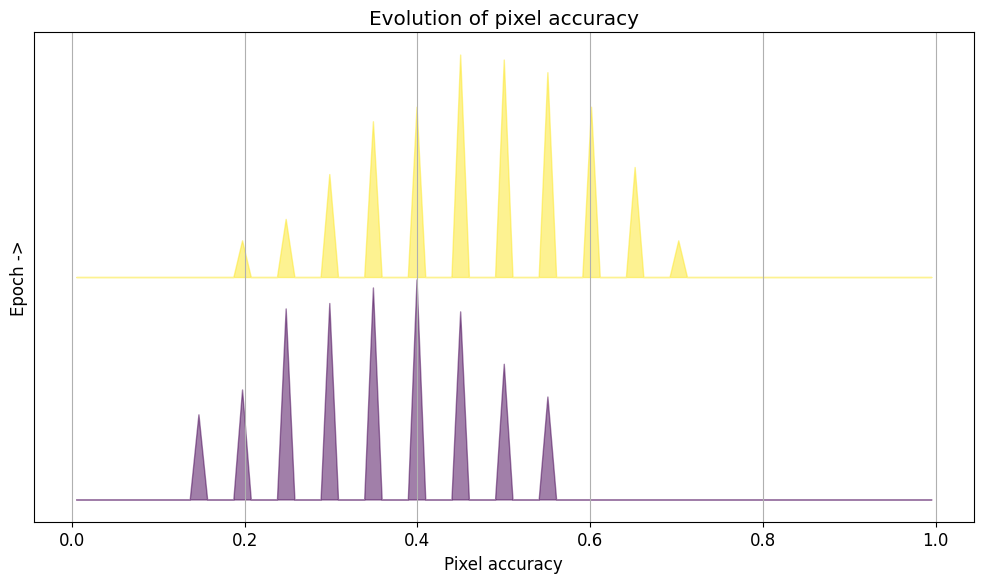

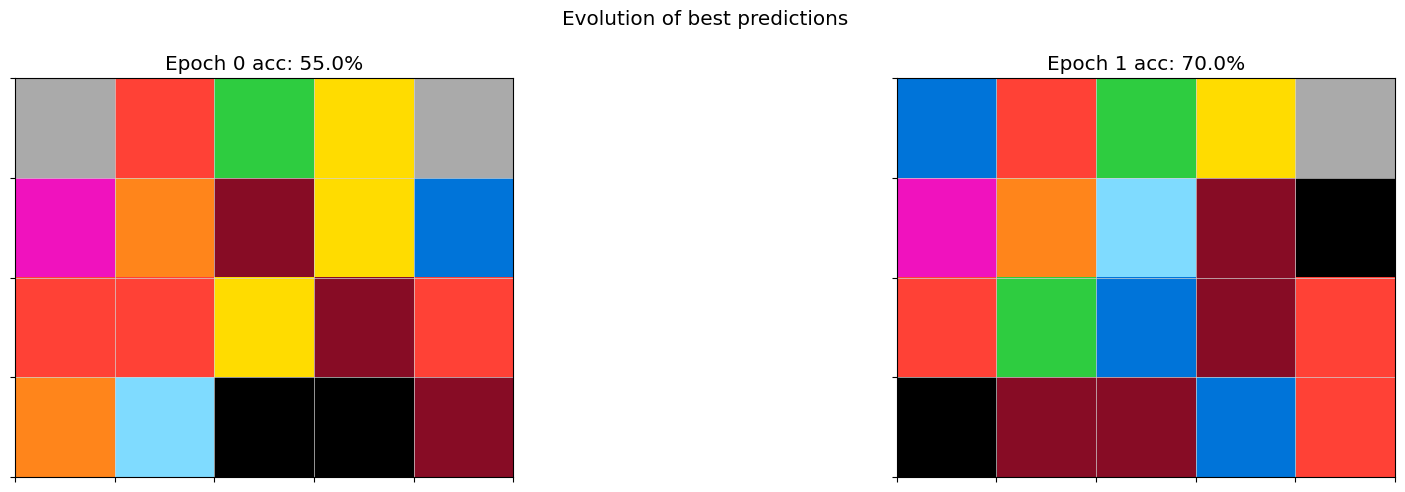

2025-05-06 17:12:24,876 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 17:12:24,945 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/256 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 256
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 256
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 17:13:14,578 - arc25.logging - INFO - wrapper - Executed finetuning in 49.7002 seconds
2025-05-06 17:13:14,579 - root - INFO - hindsight_experience_replay - Starting epoch 2...
2025-05-06 17:13:14,579 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 17:13:43,124 - root - INFO - inference - Number of unique outputs: 252/256
2025-05-06 17:13:43,126 - root - INFO - inference - Max pixel accuracy: 0.8
2025-05-06 17:13:43,136 - arc25.logging - INFO - wrapper - Executed inference in 28.5563 seconds


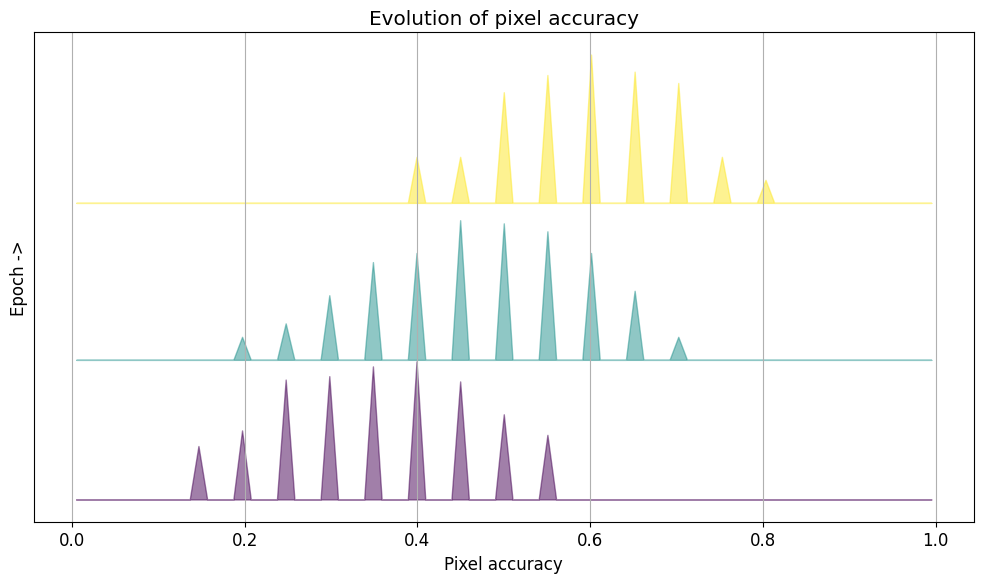

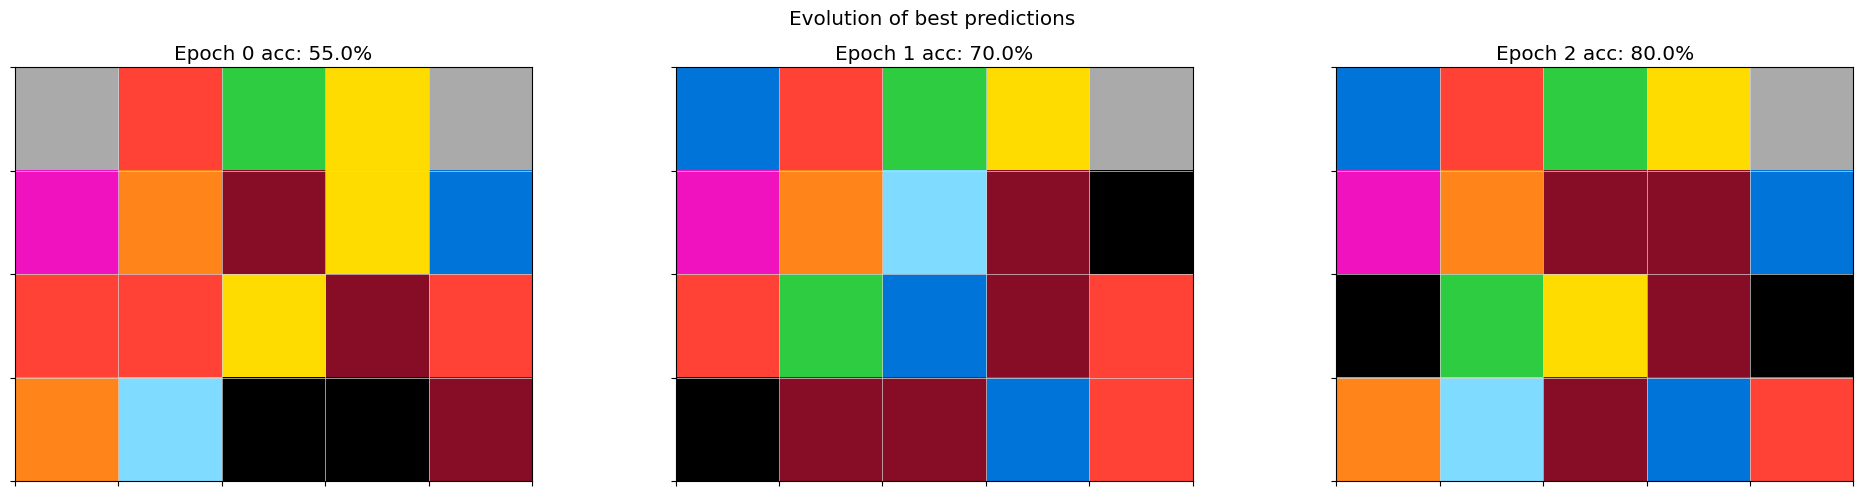

2025-05-06 17:13:43,448 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 17:13:43,530 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/252 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/252 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/252 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/252 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 252
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 252
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 17:14:31,834 - arc25.logging - INFO - wrapper - Executed finetuning in 48.3846 seconds
2025-05-06 17:14:31,835 - root - INFO - hindsight_experience_replay - Starting epoch 3...
2025-05-06 17:14:31,836 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 17:15:01,074 - root - INFO - inference - Number of unique outputs: 217/256
2025-05-06 17:15:01,075 - root - INFO - inference - Max pixel accuracy: 0.8
2025-05-06 17:15:01,079 - arc25.logging - INFO - wrapper - Executed inference in 29.2419 seconds


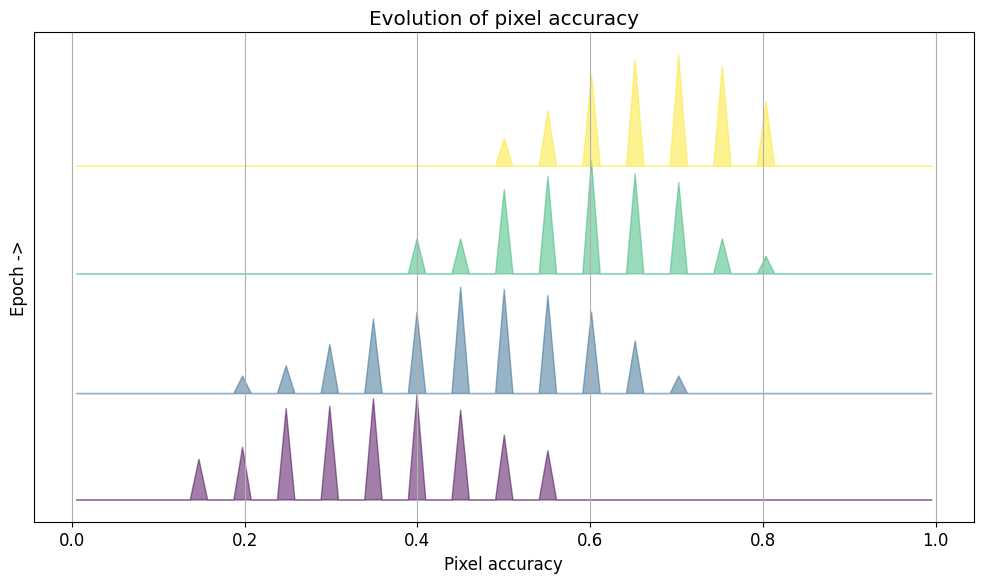

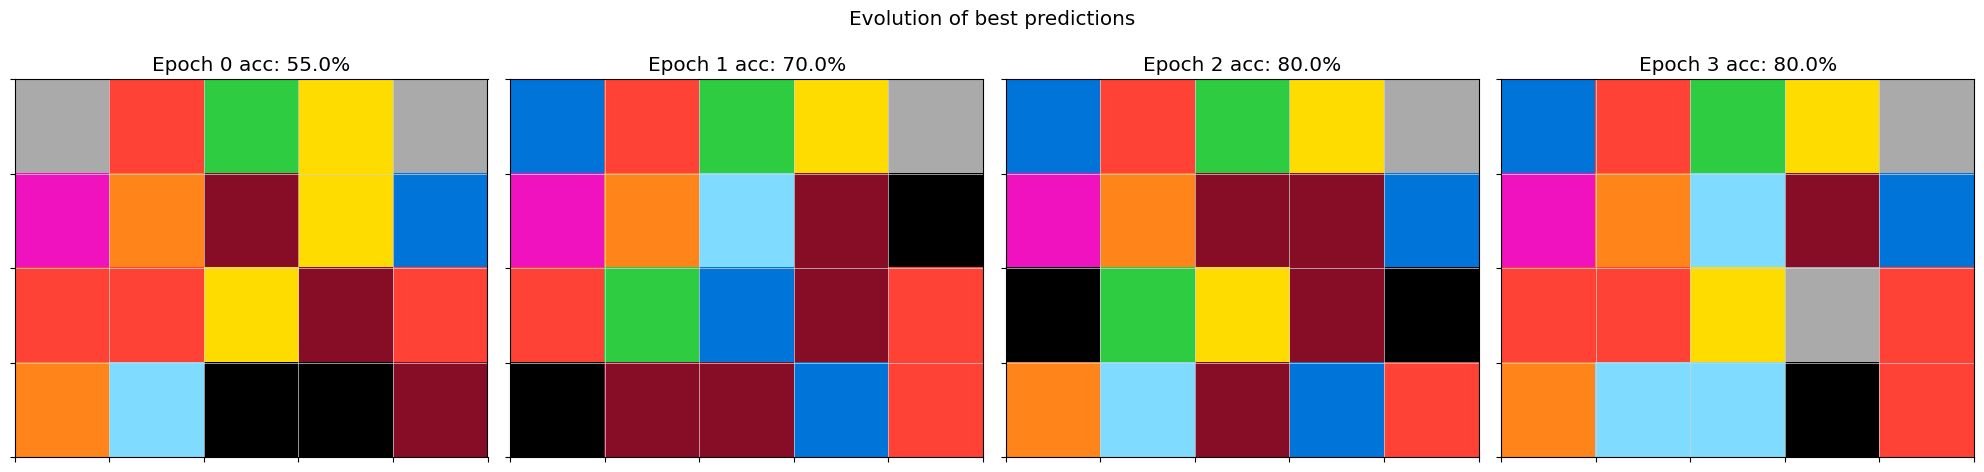

2025-05-06 17:15:01,391 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 17:15:01,462 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/217 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/217 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/217 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/217 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 217
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 217
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 17:15:43,847 - arc25.logging - INFO - wrapper - Executed finetuning in 42.4553 seconds
2025-05-06 17:15:43,849 - root - INFO - hindsight_experience_replay - Starting epoch 4...
2025-05-06 17:15:43,850 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 17:16:18,578 - root - INFO - inference - Number of unique outputs: 143/256
2025-05-06 17:16:18,580 - root - INFO - inference - Max pixel accuracy: 0.95
2025-05-06 17:16:18,583 - arc25.logging - INFO - wrapper - Executed inference in 34.7330 seconds


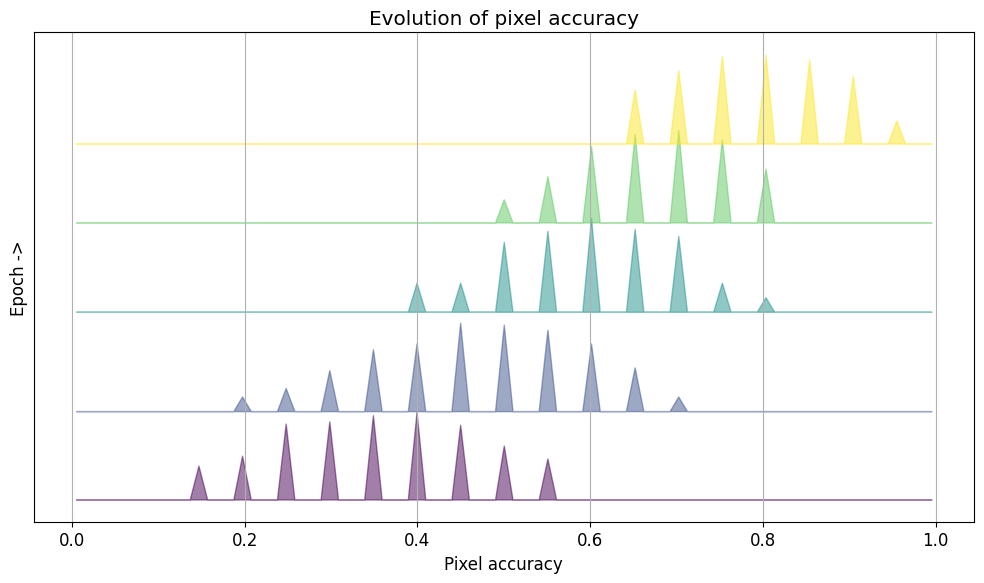

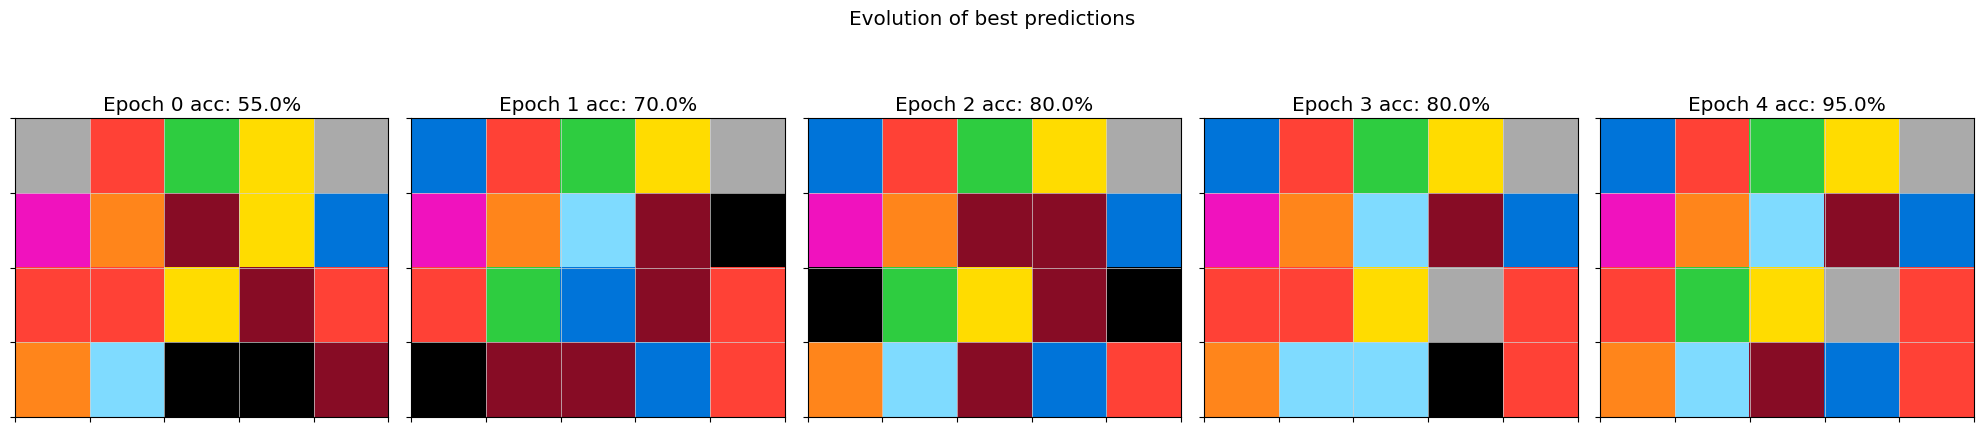

2025-05-06 17:16:18,924 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 17:16:18,992 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/143 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/143 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/143 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/143 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 143
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 17:16:47,990 - arc25.logging - INFO - wrapper - Executed finetuning in 29.0656 seconds
2025-05-06 17:16:47,991 - root - INFO - hindsight_experience_replay - Starting epoch 5...
2025-05-06 17:16:47,992 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 17:17:22,344 - root - INFO - inference - Number of unique outputs: 57/256
2025-05-06 17:17:22,345 - root - INFO - inference - Max pixel accuracy: 0.95
2025-05-06 17:17:22,347 - arc25.logging - INFO - wrapper - Executed inference in 34.3549 seconds


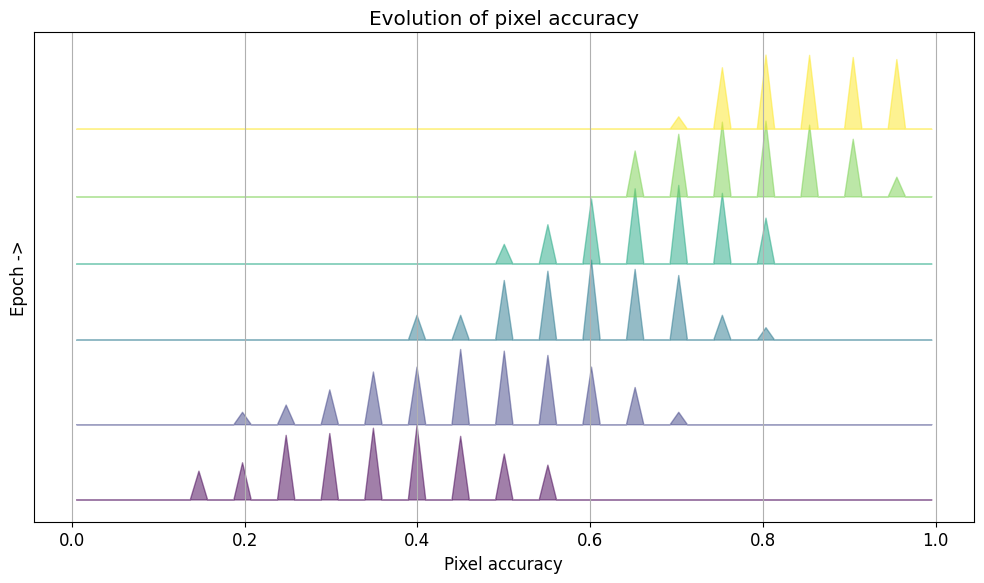

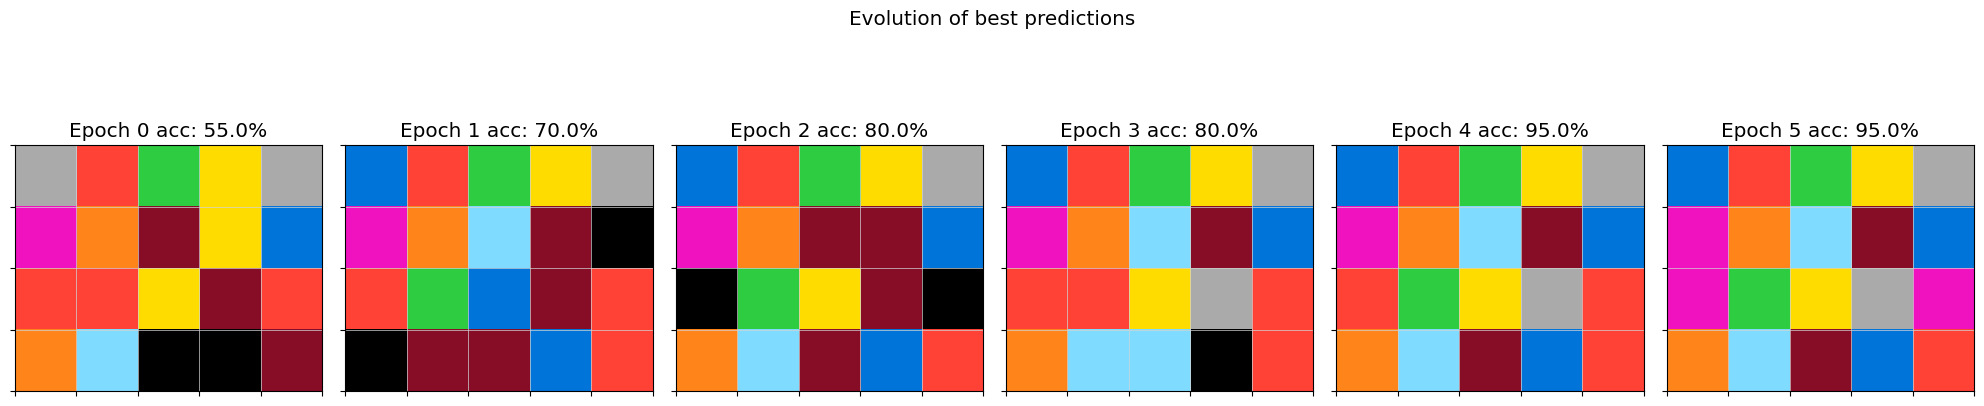

2025-05-06 17:17:22,722 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 17:17:22,771 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/57 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/57 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/57 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/57 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 57
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 57
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 17:17:34,989 - arc25.logging - INFO - wrapper - Executed finetuning in 12.2658 seconds
2025-05-06 17:17:34,990 - root - INFO - hindsight_experience_replay - Starting epoch 6...
2025-05-06 17:17:34,990 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 17:18:08,098 - root - INFO - inference - Number of unique outputs: 35/256
2025-05-06 17:18:08,099 - root - INFO - inference - Max pixel accuracy: 0.95
2025-05-06 17:18:08,101 - arc25.logging - INFO - wrapper - Executed inference in 33.1102 seconds


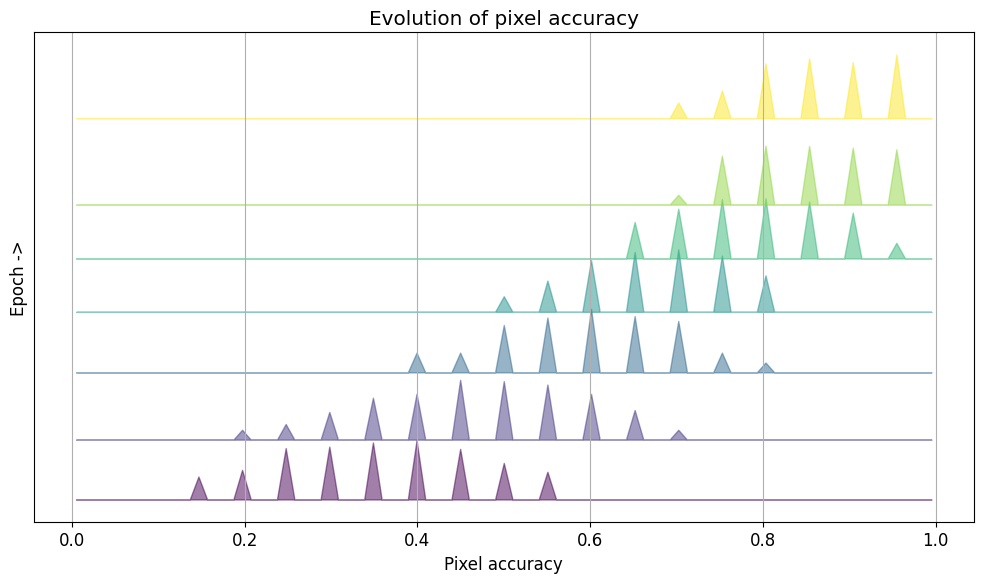

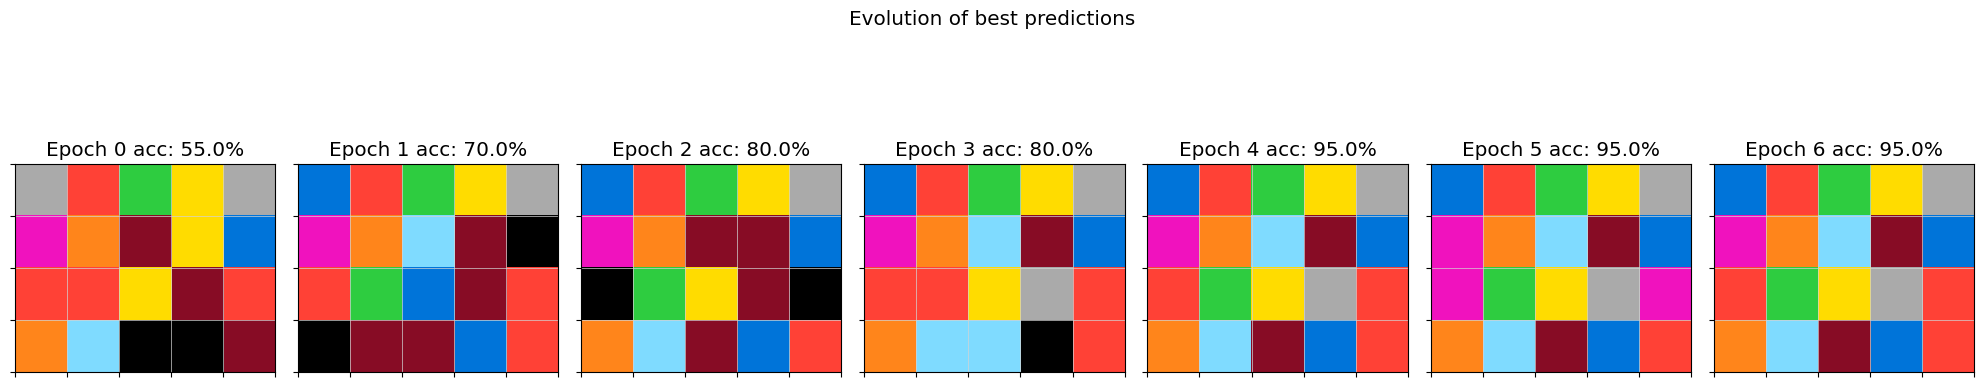

2025-05-06 17:18:08,577 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 17:18:08,631 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/35 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/35 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/35 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/35 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 35
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 35
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 17:18:16,769 - arc25.logging - INFO - wrapper - Executed finetuning in 8.1910 seconds
2025-05-06 17:18:16,770 - root - INFO - hindsight_experience_replay - Starting epoch 7...
2025-05-06 17:18:16,771 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 17:18:50,702 - root - INFO - inference - Number of unique outputs: 23/256
2025-05-06 17:18:50,704 - root - INFO - inference - Max pixel accuracy: 1.0
2025-05-06 17:18:50,706 - arc25.logging - INFO - wrapper - Executed inference in 33.9346 seconds


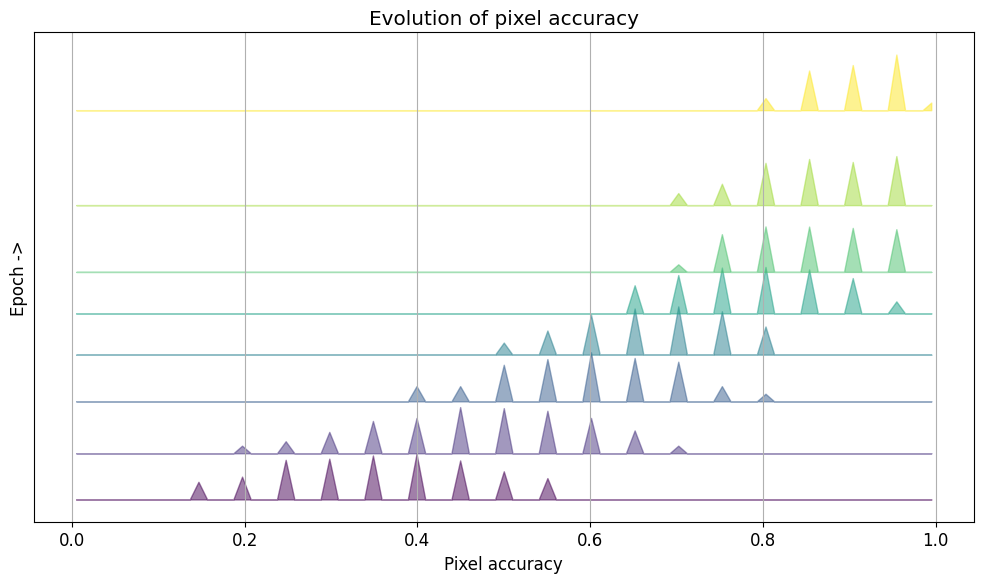

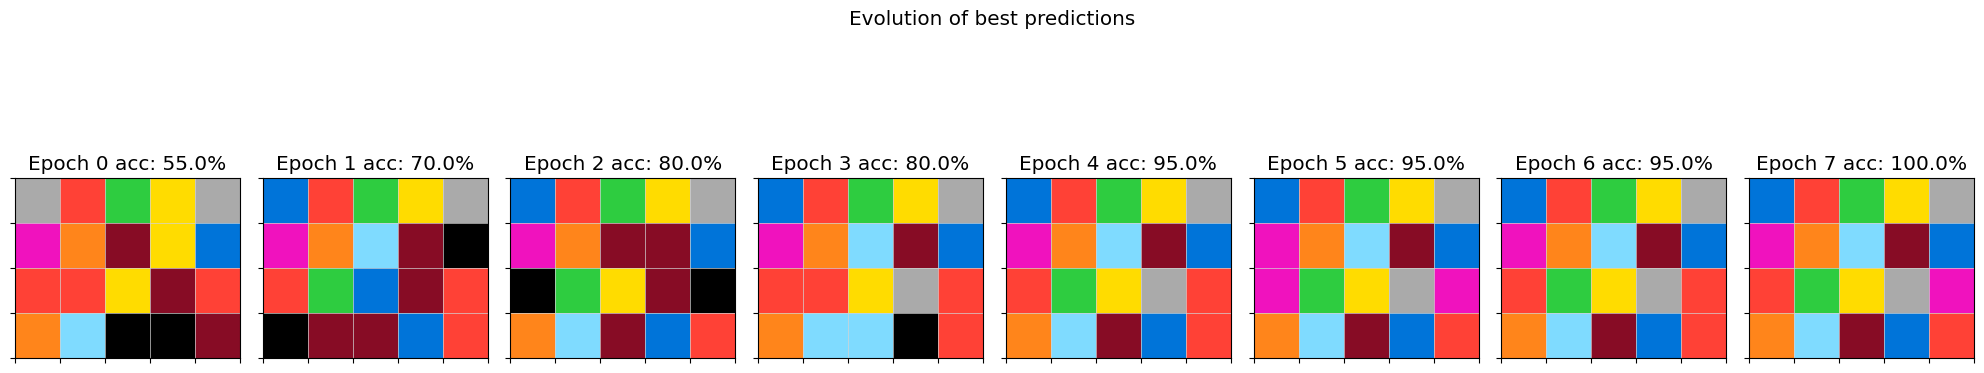

2025-05-06 17:18:51,169 - arc25.input_generation - INFO - hindsight_experience_replay - Found a perfect prediction at epoch 7!


# Best prediction code

```python
def task(img):
    draw_horizontal_line(img, y=0, color=5)
    draw_vertical_line(img, x=1, color=8)
    draw_rectangle(img, point1=(0, 0), point2=(2, 2), color=2)
    draw_pixel(img, point=(0, 0), color=1)
    draw_horizontal_line(img, y=2, color=2)
    draw_pixel(img, point=(0, 2), color=3)
    draw_line(img, point1=(1, 0), point2=(3, 2), color=9)
    draw_pixel(img, point=(0, 3), color=4)
    draw_pixel(img, point=(3, 0), color=7)
    draw_pixel(img, point=(1, 1), color=7)
    draw_pixel(img, point=(1, 3), color=9)
    draw_pixel(img, point=(2, 1), color=3)
    draw_pixel(img, point=(2, 2), color=4)
    draw_pixel(img, point=(3, 3), color=1)
    draw_pixel(img, point=(1, 4), color=1)
    draw_pixel(img, point=(2, 3), color=5)
    draw_pixel(img, point=(1, 2), color=8)
    draw_pixel(img, point=(3, 4), color=2)
    draw_pixel(img, point=(1, 0), color=6)
    draw_pixel(img, point=(2, 4), color=6)
    draw_pixel(img, point=(3, 2), color=9)
    return img
```

2025-05-06 17:18:51,239 - arc25.logging - INFO - wrapper - Executed hindsight_experience_replay in 492.0846 seconds


In [11]:
input_img = create_img((4, 5), color=0)
output_img = input_img.copy()
color = 0
for y in range(0, input_img.shape[0], 1):
    for x in range(0, input_img.shape[1], 1):
        color = (color + 1) % 10
        if color == 0: color = 1
        draw_pixel(output_img, (y, x), color=color)
task = Task(inputs=[input_img], outputs=[output_img], code='', name='manual')
hindsight_experience_replay(task, Config());

#### 25 pixels

2025-05-06 17:26:51,501 - arc25.logging - INFO - wrapper - Executing hindsight_experience_replay...


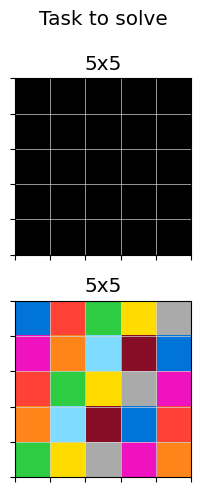

2025-05-06 17:26:51,622 - arc25.logging - INFO - wrapper - Executing load_model...
2025-05-06 17:26:51,623 - root - INFO - load_model - Loading model from /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct and LoRA from /mnt/hdd0/Kaggle/arc25/trainings/20250430_first_trainings/steps_6400/checkpoint-6400
loading configuration file /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct/config.json
Model config Qwen2Config {
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 896,
  "initializer_range": 0.02,
  "intermediate_size": 4864,
  "max_position_embeddings": 32768,
  "max_window_layers": 24,
  "model_type": "qwen2",
  "num_attention_heads": 14,
  "num_hidden_layers": 24,
  "num_key_value_heads": 2,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 1000000.0,
  "sliding_window": 32768,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "tra

  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 17:27:18,894 - root - INFO - inference - Number of unique outputs: 256/256
2025-05-06 17:27:18,896 - root - INFO - inference - Max pixel accuracy: 0.44
2025-05-06 17:27:18,907 - arc25.logging - INFO - wrapper - Executed inference in 26.0264 seconds


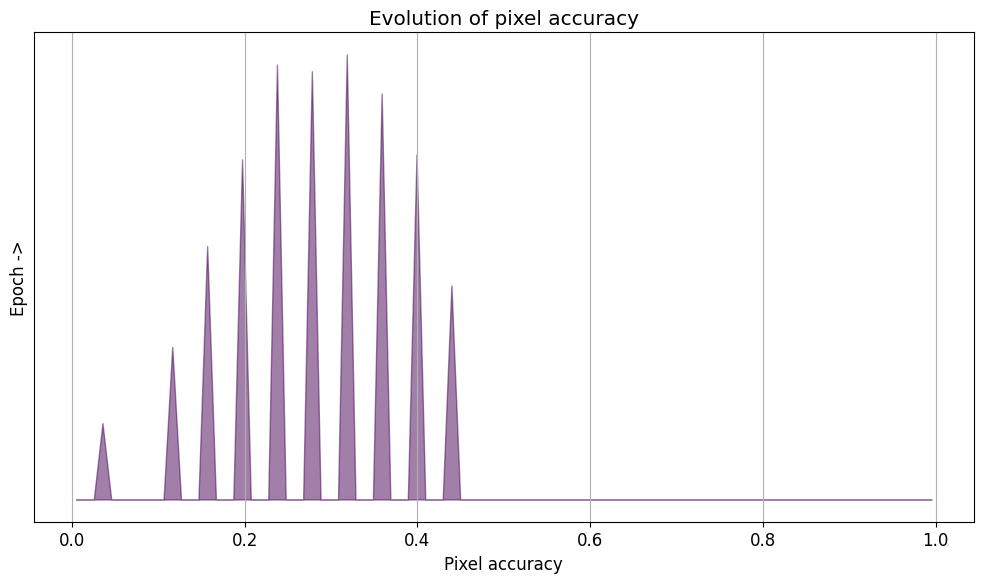

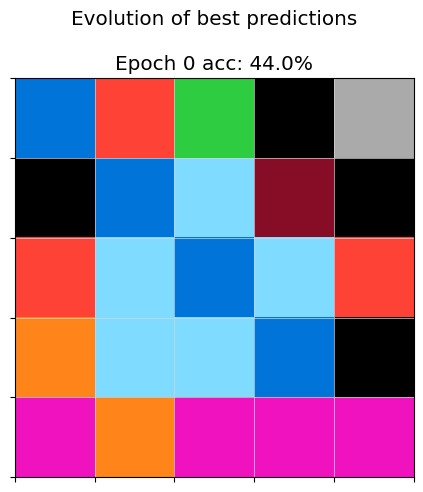

2025-05-06 17:27:19,112 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 17:27:19,216 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/256 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 256
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 256
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 17:28:10,875 - arc25.logging - INFO - wrapper - Executed finetuning in 51.7626 seconds
2025-05-06 17:28:10,877 - root - INFO - hindsight_experience_replay - Starting epoch 1...
2025-05-06 17:28:10,878 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 17:28:47,963 - root - INFO - inference - Number of unique outputs: 256/256
2025-05-06 17:28:47,964 - root - INFO - inference - Max pixel accuracy: 0.6
2025-05-06 17:28:47,968 - arc25.logging - INFO - wrapper - Executed inference in 37.0895 seconds


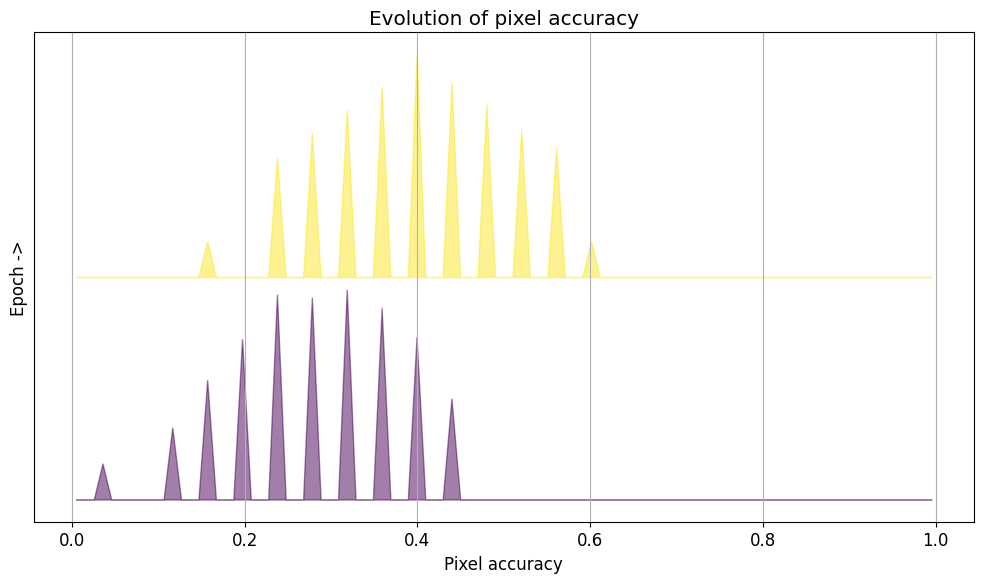

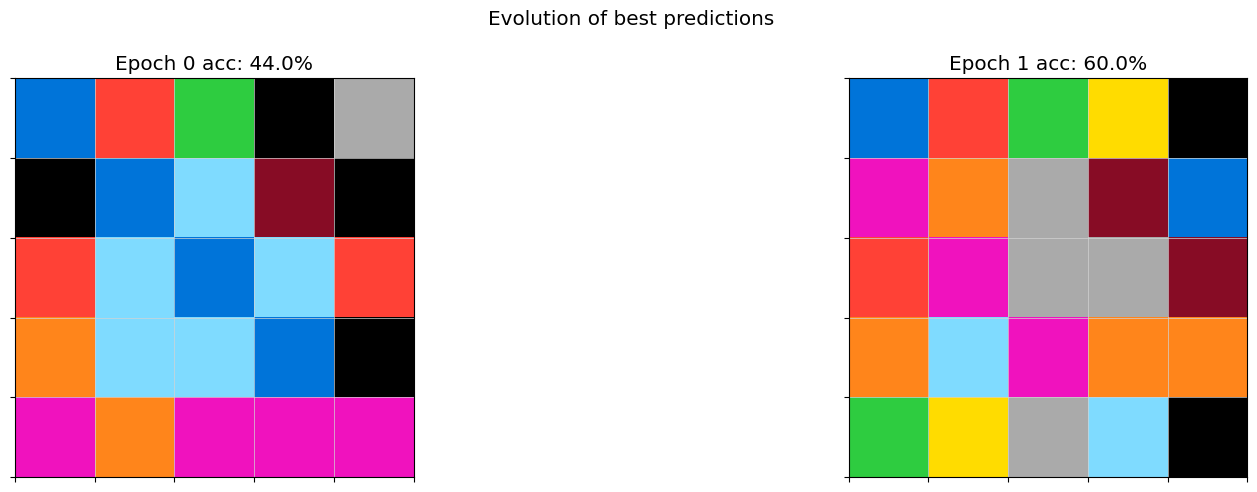

2025-05-06 17:28:48,185 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 17:28:48,290 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/256 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 256
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 256
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 17:29:38,745 - arc25.logging - INFO - wrapper - Executed finetuning in 50.5594 seconds
2025-05-06 17:29:38,747 - root - INFO - hindsight_experience_replay - Starting epoch 2...
2025-05-06 17:29:38,749 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 17:30:27,960 - root - INFO - inference - Number of unique outputs: 256/256
2025-05-06 17:30:27,961 - root - INFO - inference - Max pixel accuracy: 0.68
2025-05-06 17:30:27,965 - arc25.logging - INFO - wrapper - Executed inference in 49.2161 seconds


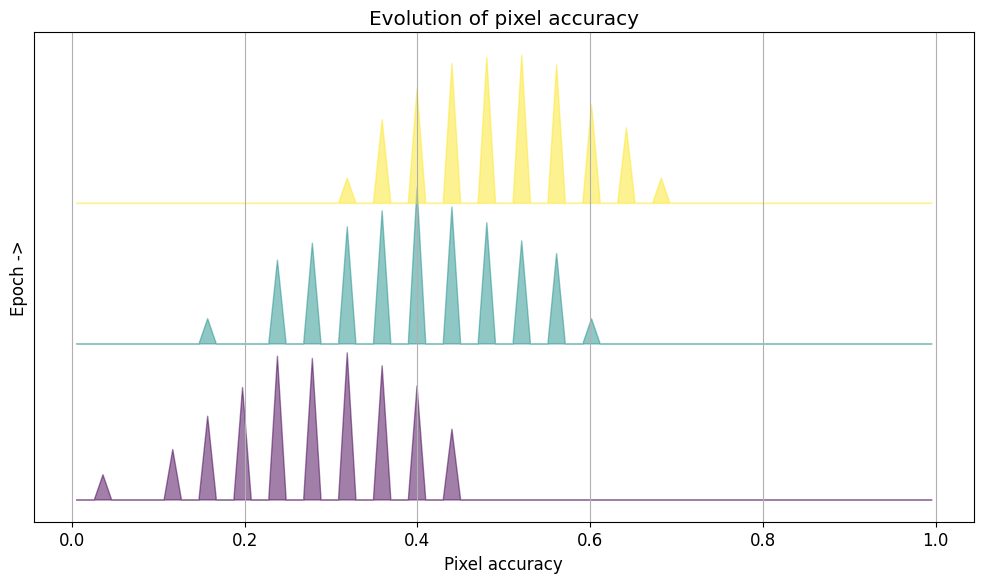

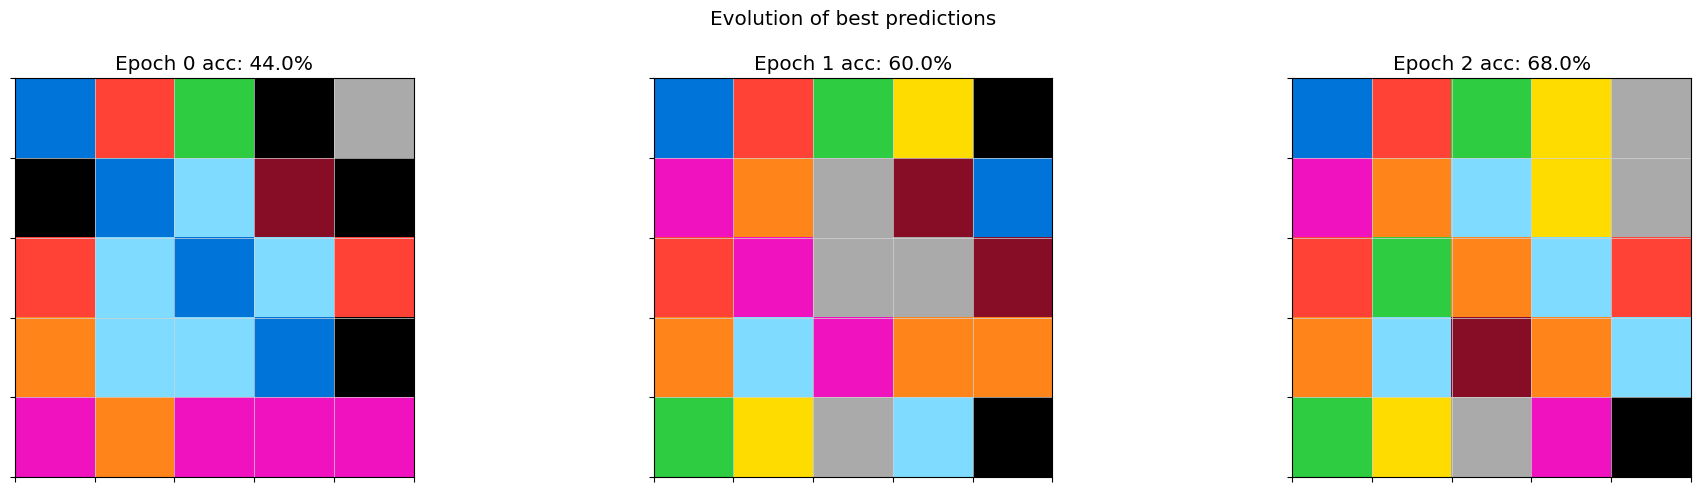

2025-05-06 17:30:28,225 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 17:30:28,302 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/256 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 256
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 256
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 17:31:17,389 - arc25.logging - INFO - wrapper - Executed finetuning in 49.1629 seconds
2025-05-06 17:31:17,389 - root - INFO - hindsight_experience_replay - Starting epoch 3...
2025-05-06 17:31:17,390 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 17:32:08,002 - root - INFO - inference - Number of unique outputs: 255/256
2025-05-06 17:32:08,004 - root - INFO - inference - Max pixel accuracy: 0.8
2025-05-06 17:32:08,008 - arc25.logging - INFO - wrapper - Executed inference in 50.6175 seconds


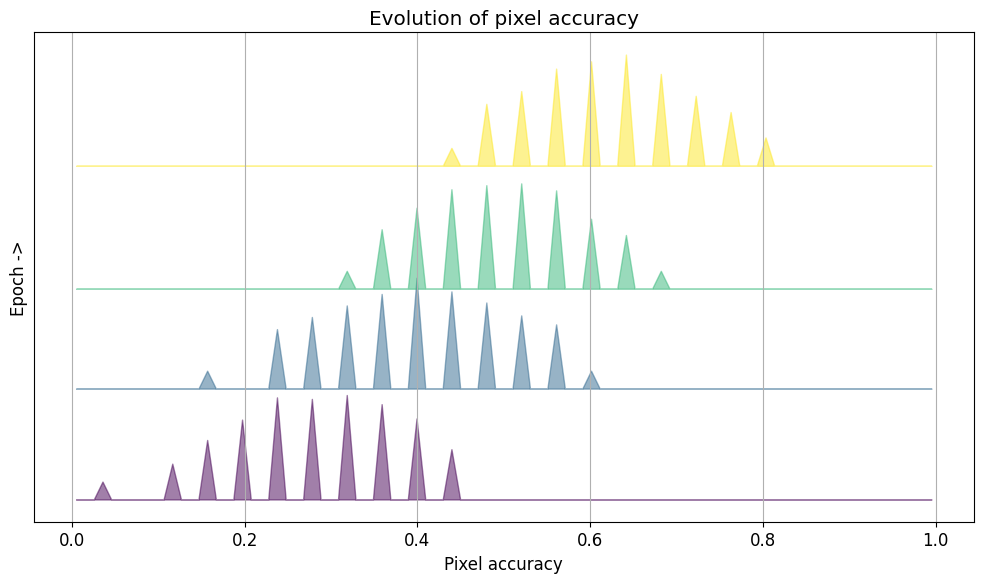

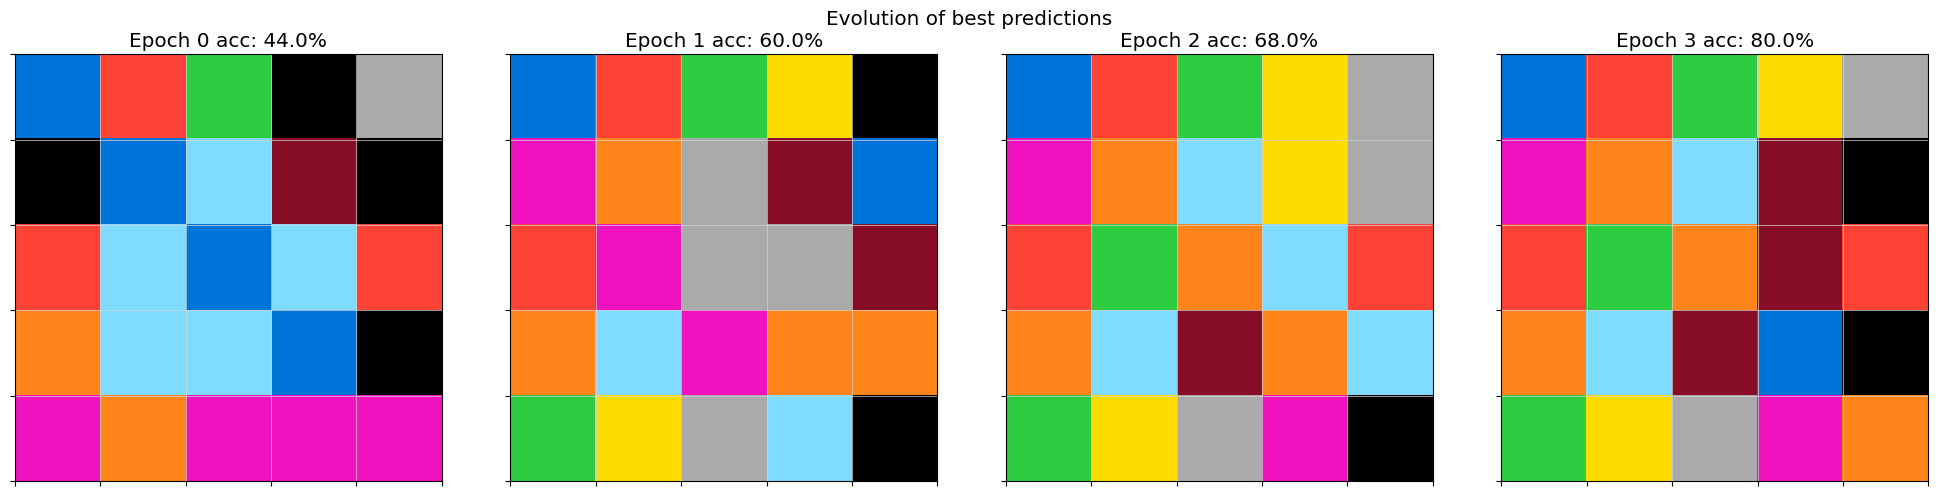

2025-05-06 17:32:08,327 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 17:32:08,415 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/255 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/255 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/255 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/255 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 255
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 255
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 17:32:55,866 - arc25.logging - INFO - wrapper - Executed finetuning in 47.5377 seconds
2025-05-06 17:32:55,868 - root - INFO - hindsight_experience_replay - Starting epoch 4...
2025-05-06 17:32:55,869 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 17:33:44,977 - root - INFO - inference - Number of unique outputs: 256/256
2025-05-06 17:33:44,979 - root - INFO - inference - Max pixel accuracy: 0.72
2025-05-06 17:33:44,982 - arc25.logging - INFO - wrapper - Executed inference in 49.1130 seconds


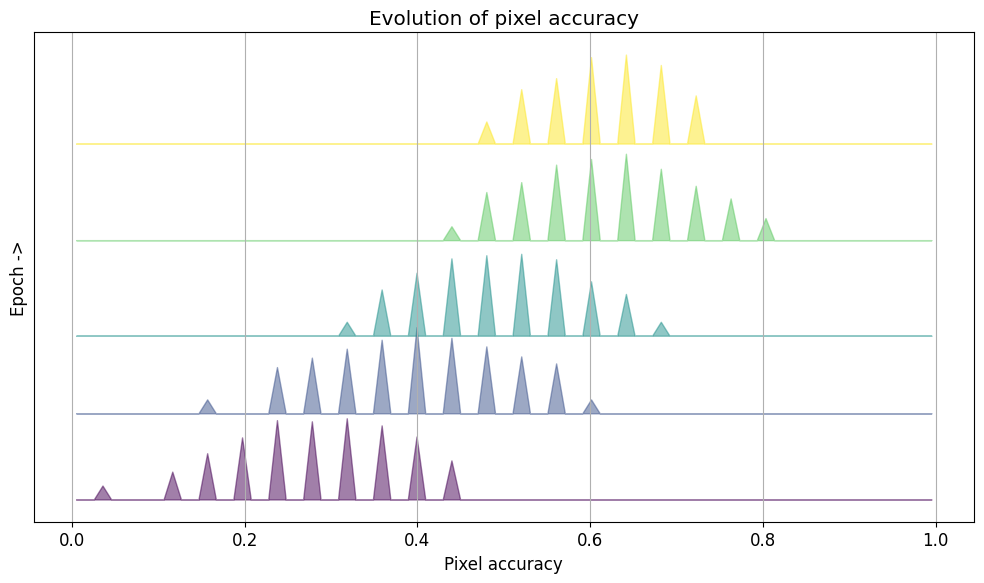

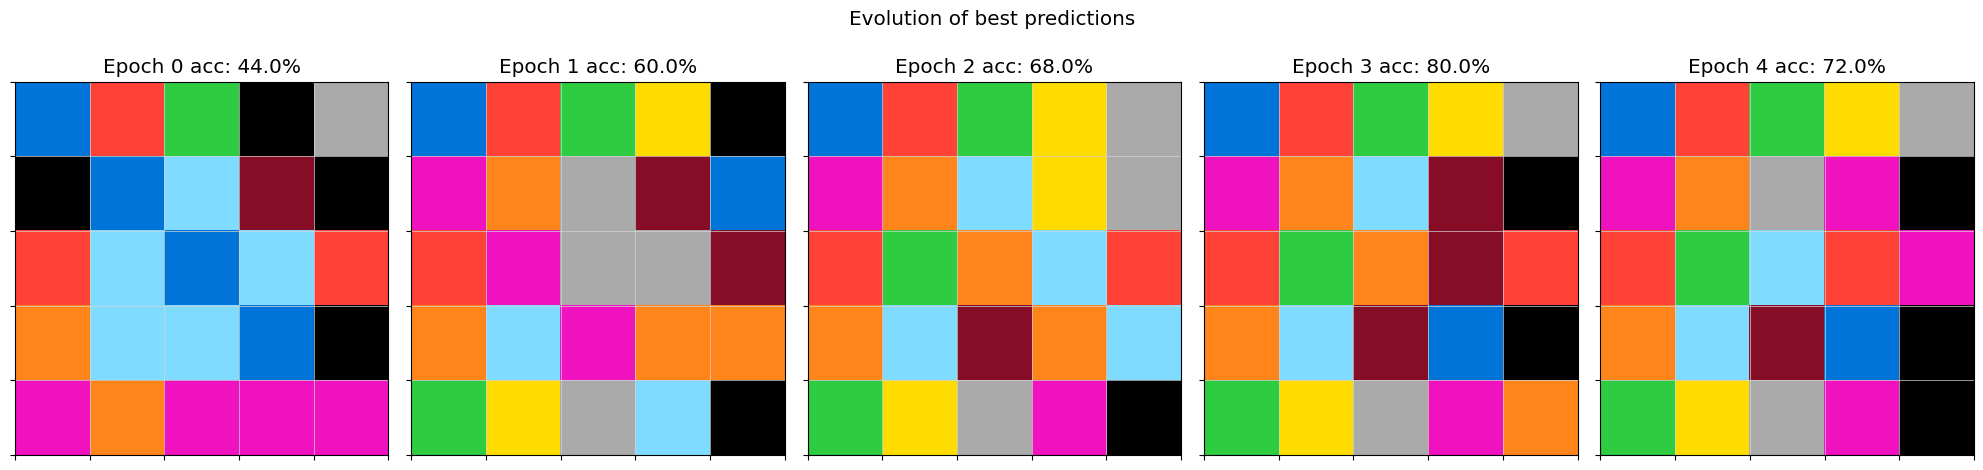

2025-05-06 17:33:45,338 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 17:33:45,416 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/256 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 256
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 256
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 17:34:36,190 - arc25.logging - INFO - wrapper - Executed finetuning in 50.8510 seconds
2025-05-06 17:34:36,192 - root - INFO - hindsight_experience_replay - Starting epoch 5...
2025-05-06 17:34:36,192 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 17:35:33,074 - root - INFO - inference - Number of unique outputs: 248/256
2025-05-06 17:35:33,076 - root - INFO - inference - Max pixel accuracy: 0.8
2025-05-06 17:35:33,081 - arc25.logging - INFO - wrapper - Executed inference in 56.8888 seconds


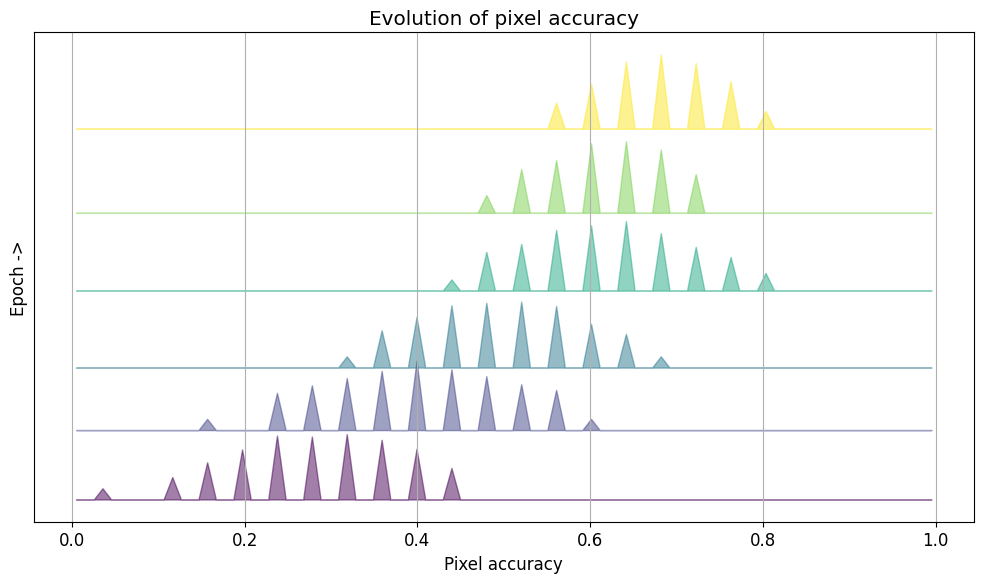

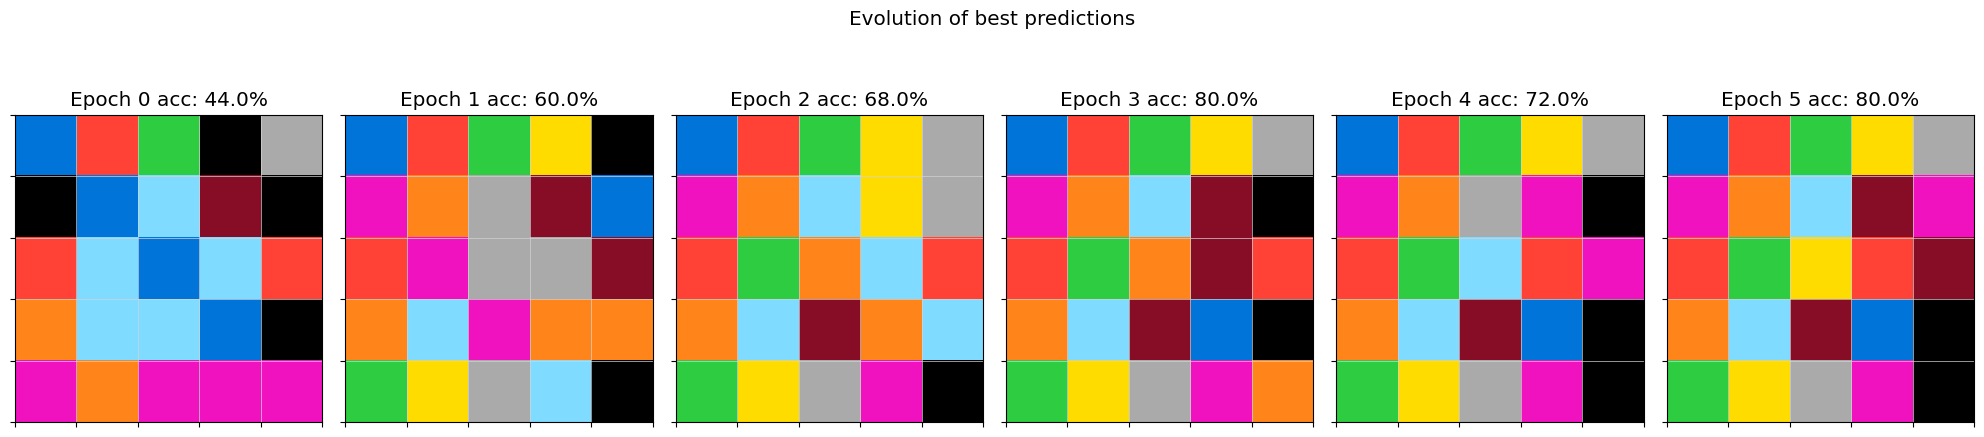

2025-05-06 17:35:33,518 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 17:35:33,598 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/248 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/248 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/248 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/248 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 248
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 248
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 17:36:22,881 - arc25.logging - INFO - wrapper - Executed finetuning in 49.3612 seconds
2025-05-06 17:36:22,881 - root - INFO - hindsight_experience_replay - Starting epoch 6...
2025-05-06 17:36:22,882 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 17:37:24,321 - root - INFO - inference - Number of unique outputs: 173/256
2025-05-06 17:37:24,322 - root - INFO - inference - Max pixel accuracy: 0.8
2025-05-06 17:37:24,330 - arc25.logging - INFO - wrapper - Executed inference in 61.4475 seconds


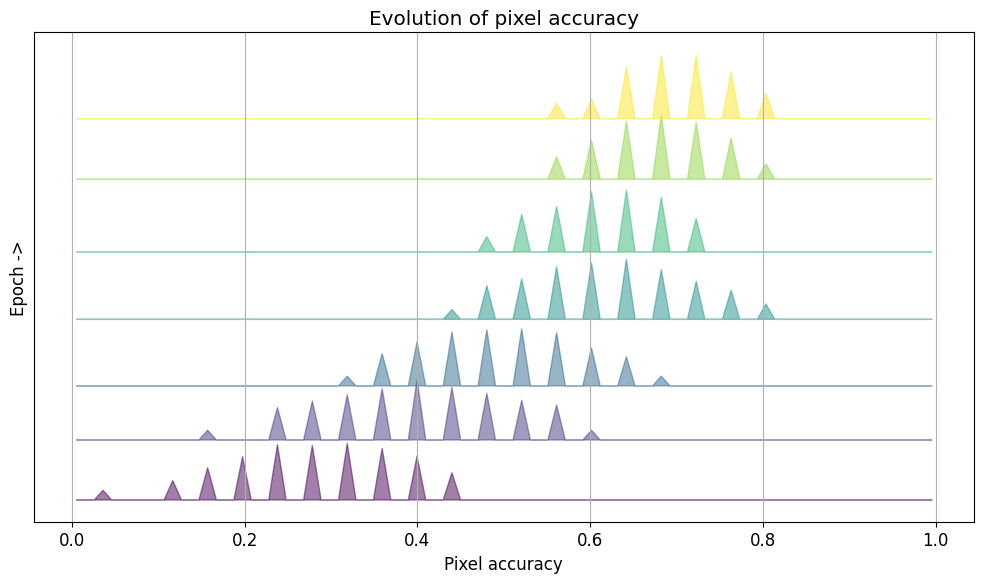

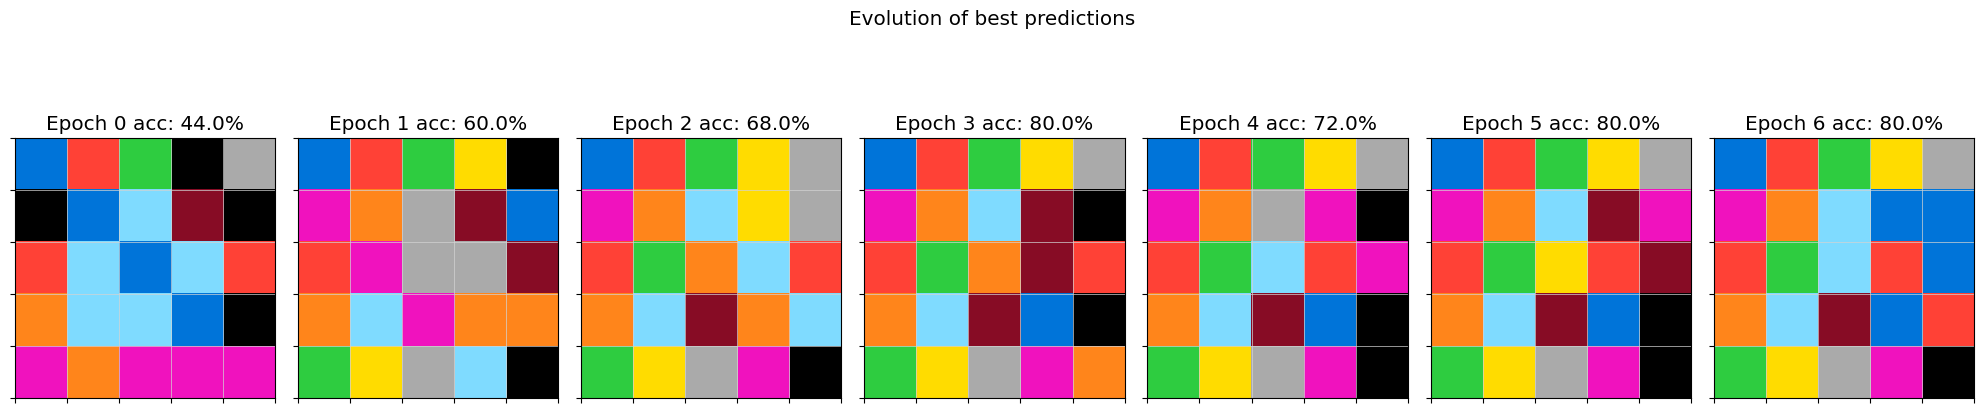

2025-05-06 17:37:24,810 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 17:37:24,880 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/173 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/173 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/173 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/173 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 173
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 173
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 17:37:58,158 - arc25.logging - INFO - wrapper - Executed finetuning in 33.3465 seconds
2025-05-06 17:37:58,160 - root - INFO - hindsight_experience_replay - Starting epoch 7...
2025-05-06 17:37:58,161 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 17:38:59,563 - root - INFO - inference - Number of unique outputs: 180/256
2025-05-06 17:38:59,565 - root - INFO - inference - Max pixel accuracy: 0.88
2025-05-06 17:38:59,568 - arc25.logging - INFO - wrapper - Executed inference in 61.4065 seconds


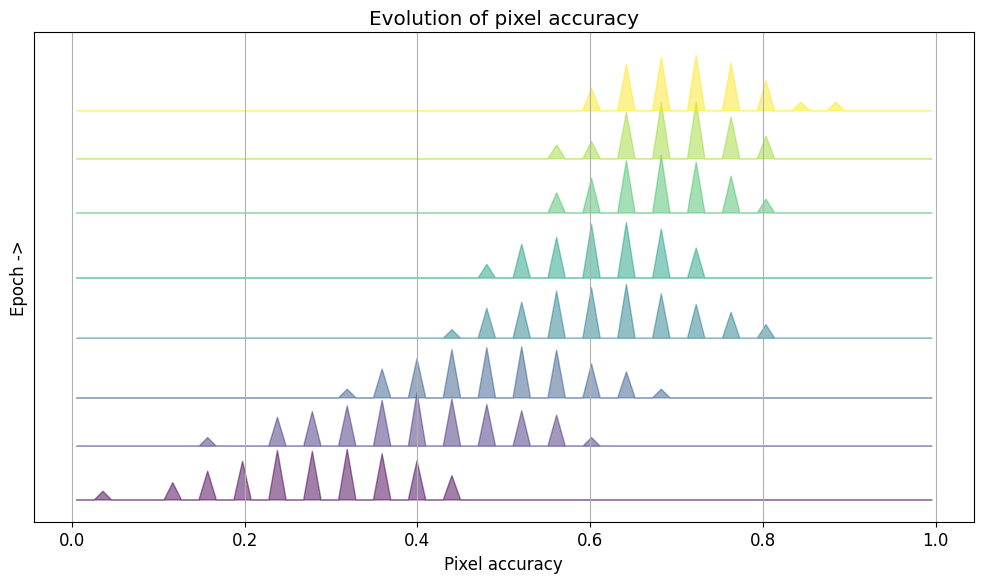

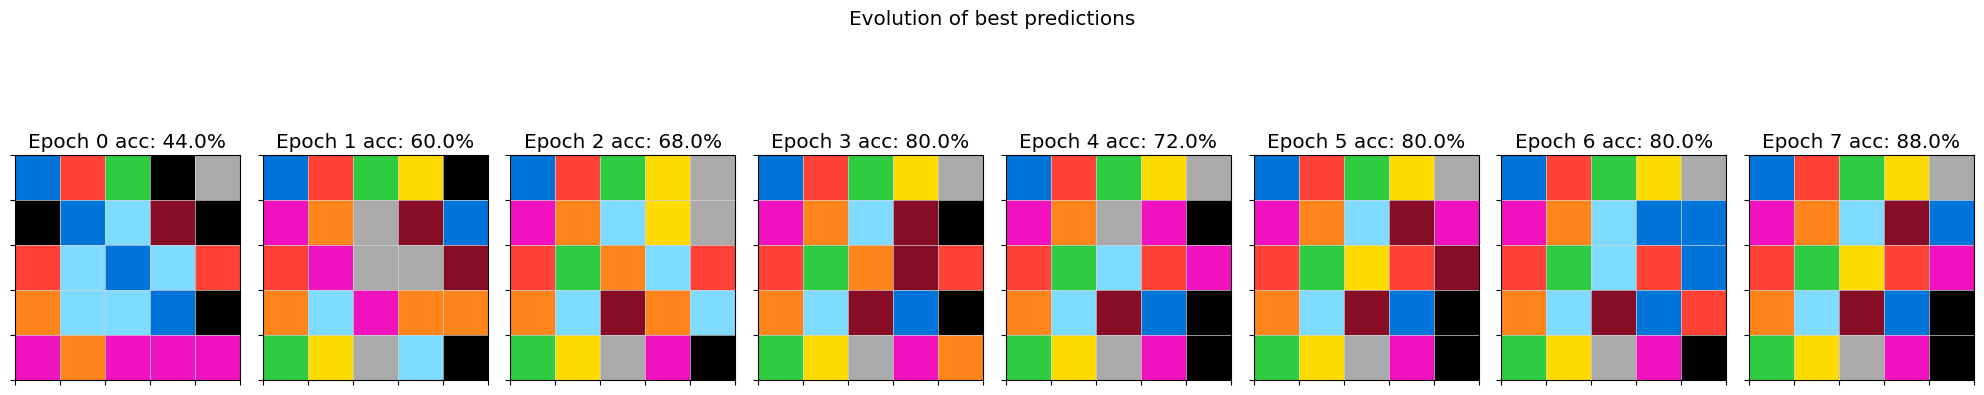

2025-05-06 17:39:00,030 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 17:39:00,099 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/180 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/180 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/180 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/180 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 180
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 180
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 17:39:34,169 - arc25.logging - INFO - wrapper - Executed finetuning in 34.1382 seconds
2025-05-06 17:39:34,170 - root - INFO - hindsight_experience_replay - Starting epoch 8...
2025-05-06 17:39:34,171 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 17:40:34,479 - root - INFO - inference - Number of unique outputs: 102/256
2025-05-06 17:40:34,479 - root - INFO - inference - Max pixel accuracy: 0.88
2025-05-06 17:40:34,486 - arc25.logging - INFO - wrapper - Executed inference in 60.3140 seconds


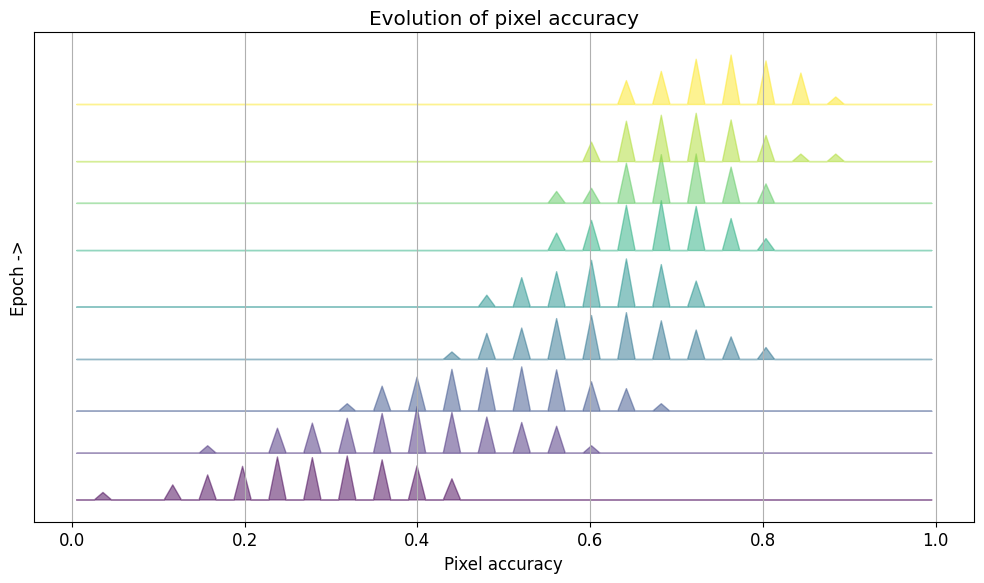

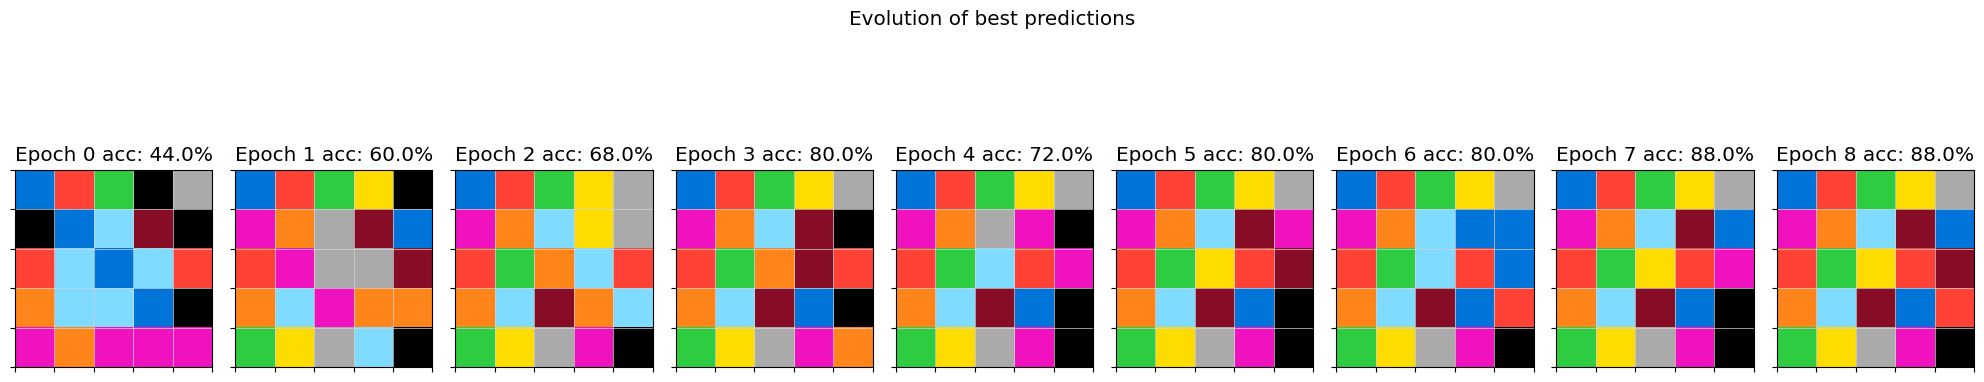

2025-05-06 17:40:35,045 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 17:40:35,116 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/102 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/102 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/102 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/102 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 102
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 102
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 17:40:54,962 - arc25.logging - INFO - wrapper - Executed finetuning in 19.9160 seconds
2025-05-06 17:40:54,964 - root - INFO - hindsight_experience_replay - Starting epoch 9...
2025-05-06 17:40:54,965 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 17:41:49,108 - root - INFO - inference - Number of unique outputs: 109/256
2025-05-06 17:41:49,109 - root - INFO - inference - Max pixel accuracy: 0.88
2025-05-06 17:41:49,115 - arc25.logging - INFO - wrapper - Executed inference in 54.1489 seconds


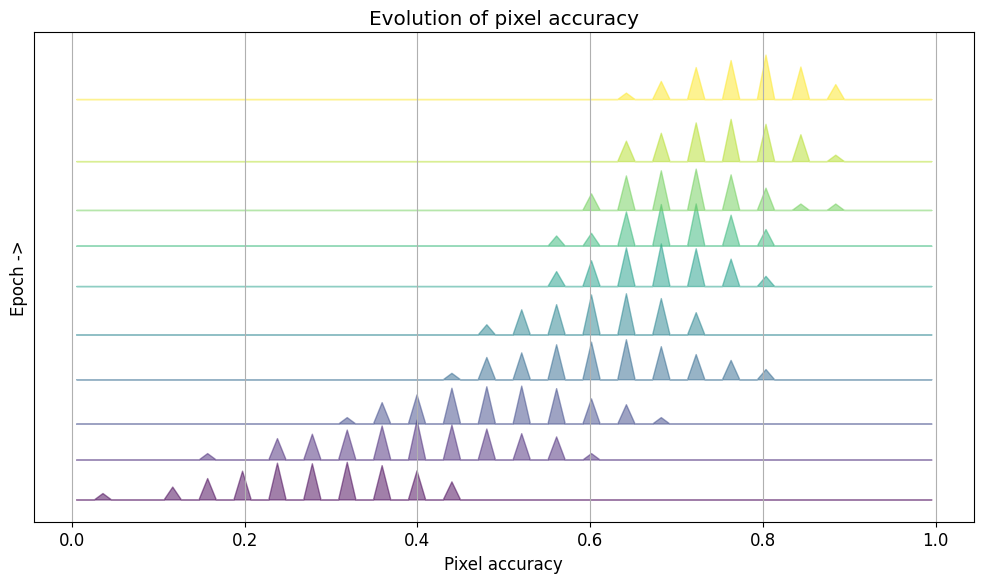

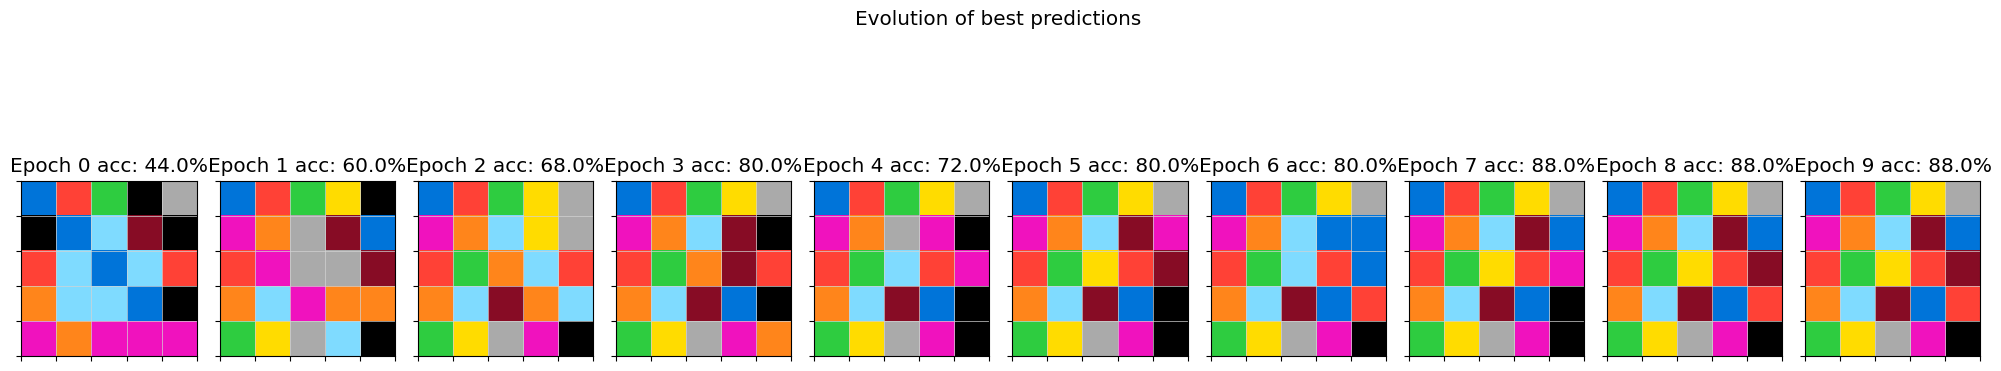

2025-05-06 17:41:49,688 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 17:41:49,759 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/109 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/109 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/109 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/109 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 109
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 17:42:10,017 - arc25.logging - INFO - wrapper - Executed finetuning in 20.3281 seconds


# Best prediction code

```python
def task(img):
    draw_horizontal_line(img, y=0, color=5)
    draw_rectangle(img, point1=(0, 1), point2=(4, 3), color=6)
    draw_vertical_line(img, x=1, color=4)
    draw_pixel(img, point=(0, 0), color=1)
    draw_line(img, point1=(0, 2), point2=(2, 4), color=1)
    draw_horizontal_line(img, y=2, color=2)
    draw_line(img, point1=(0, 2), point2=(2, 4), color=6)
    draw_line(img, point1=(0, 2), point2=(2, 4), color=5)
    draw_line(img, point1=(0, 1), point2=(1, 1), color=2)
    draw_line(img, point1=(0, 2), point2=(2, 4), color=9)
    draw_line(img, point1=(0, 3), point2=(3, 6), color=1)
    draw_line(img, point1=(0, 2), point2=(4, 2), color=4)
    draw_pixel(img, point=(0, 3), color=4)
    draw_pixel(img, point=(0, 2), color=3)
    draw_pixel(img, point=(3, 0), color=7)
    draw_pixel(img, point=(0, 1), color=2)
    draw_pixel(img, point=(1, 0), color=6)
    draw_pixel(img, point=(3, 2), color=9)
    draw_pixel(img, point=(4, 0), color=3)
    draw_pixel(img, point=(3, 3), color=1)
    draw_pixel(img, point=(1, 1), color=7)
    draw_pixel(img, point=(2, 1), color=3)
    draw_pixel(img, point=(3, 1), color=8)
    draw_pixel(img, point=(1, 2), color=8)
    draw_pixel(img, point=(3, 4), color=2)
    draw_pixel(img, point=(4, 2), color=5)
    return img
```

2025-05-06 17:42:10,091 - arc25.logging - INFO - wrapper - Executed hindsight_experience_replay in 918.5887 seconds


In [12]:
input_img = create_img((5, 5), color=0)
output_img = input_img.copy()
color = 0
for y in range(0, input_img.shape[0], 1):
    for x in range(0, input_img.shape[1], 1):
        color = (color + 1) % 10
        if color == 0: color = 1
        draw_pixel(output_img, (y, x), color=color)
task = Task(inputs=[input_img], outputs=[output_img], code='', name='manual')
hindsight_experience_replay(task, Config());

## Weaker models

What if I try weaker models? (Models that have been trained for a shorter time)

### 400 training epochs

#### 9 vertical lines

2025-05-06 18:51:28,860 - arc25.logging - INFO - wrapper - Executing hindsight_experience_replay...


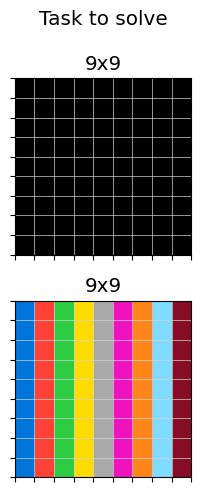

2025-05-06 18:51:29,033 - arc25.logging - INFO - wrapper - Executing load_model...
2025-05-06 18:51:29,033 - root - INFO - load_model - Loading model from /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct and LoRA from /mnt/hdd0/Kaggle/arc25/trainings/20250430_first_trainings/steps_400/checkpoint-400
loading configuration file /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct/config.json
Model config Qwen2Config {
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 896,
  "initializer_range": 0.02,
  "intermediate_size": 4864,
  "max_position_embeddings": 32768,
  "max_window_layers": 24,
  "model_type": "qwen2",
  "num_attention_heads": 14,
  "num_hidden_layers": 24,
  "num_key_value_heads": 2,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 1000000.0,
  "sliding_window": 32768,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "trans

  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 18:51:44,130 - root - INFO - inference - Number of unique outputs: 240/255
2025-05-06 18:51:44,132 - root - INFO - inference - Max pixel accuracy: 0.5555555555555556
2025-05-06 18:51:44,139 - arc25.logging - INFO - wrapper - Executed inference in 14.1039 seconds


Error executing code: def task(img):
    draw_vertical_line(img, x=0, color=1)
    draw_horizontal_line(img, y=0, color=0)
    draw_rectangle(img, point1=(0, 0), point2=(8, 7), color=2)
    draw_vertical_line(img, x=4, color=4)
    draw_vertical_line(img, x=5, color=5)
    draw_vertical_line(img, x=8, color=6)
    draw_vertical_line(img, x=9, color=7)
    return img
index 9 is out of bounds for axis 1 with size 9


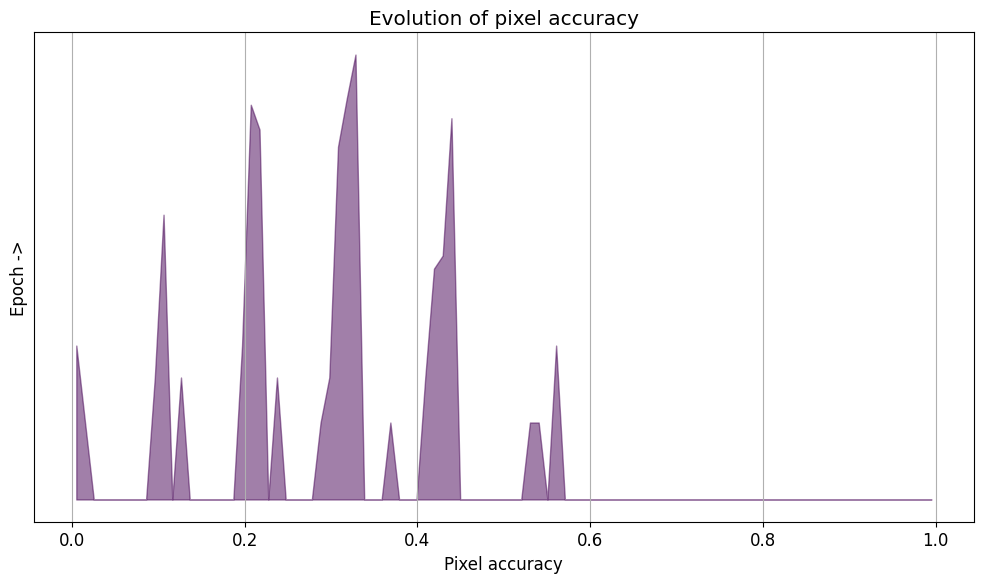

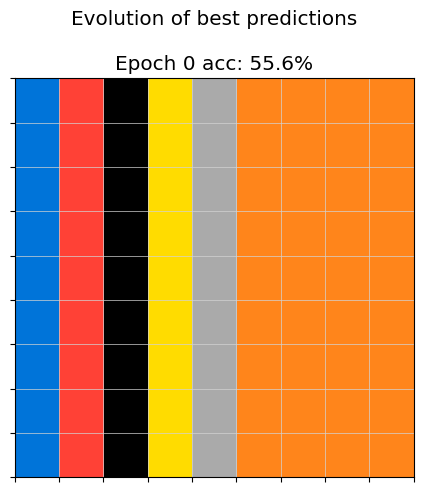

2025-05-06 18:51:44,328 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 18:51:44,419 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/240 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/240 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/240 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/240 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 240
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 240
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 18:52:31,550 - arc25.logging - INFO - wrapper - Executed finetuning in 47.2205 seconds
2025-05-06 18:52:31,551 - root - INFO - hindsight_experience_replay - Starting epoch 1...
2025-05-06 18:52:31,552 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 18:52:47,763 - root - INFO - inference - Number of unique outputs: 138/253
2025-05-06 18:52:47,764 - root - INFO - inference - Max pixel accuracy: 0.7777777777777778
2025-05-06 18:52:47,768 - arc25.logging - INFO - wrapper - Executed inference in 16.2152 seconds


Error executing code: def task(img):
    draw_vertical_line(img, x=0, color=1)
    draw_rectangle(img, point1=(0, 4), point2=(8, 7), color=5)
    draw_vertical_line(img, x=1, color=2)
    draw_vertical_line(img, x=3, color=3)
    draw_vertical_line(img, x=5, color=4)
    draw_vertical_line(img, x=6, color=6)
    draw_vertical_line(img, x=7, color=7)
    draw_horizontal_line(img, y=9, color=8)
    return img
index 9 is out of bounds for axis 0 with size 9
Error executing code: def task(img):
    draw_vertical_line(img, x=0, color=1)
    draw_rectangle(img, point1=(0, 2), point2=(8, 7), color=3)
    draw_rectangle(img, point1=(0, 4), point2=(8, 7), color=5)
    draw_rectangle(img, point1=(0, 6), point2=(8, 7), color=6)
    draw_vertical_line(img, x=8, color=7)
    draw_vertical_line(img, x=9, color=8)
    return img
index 9 is out of bounds for axis 1 with size 9
Error executing code: def task(img):
    draw_vertical_line(img, x=0, color=1)
    draw_rectangle(img, point1=(0, 2), point2=(

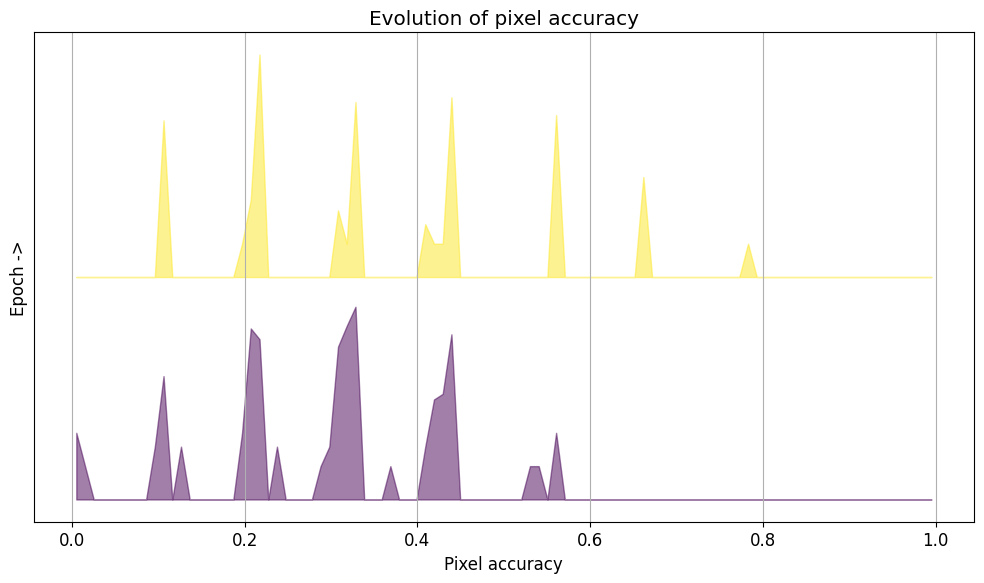

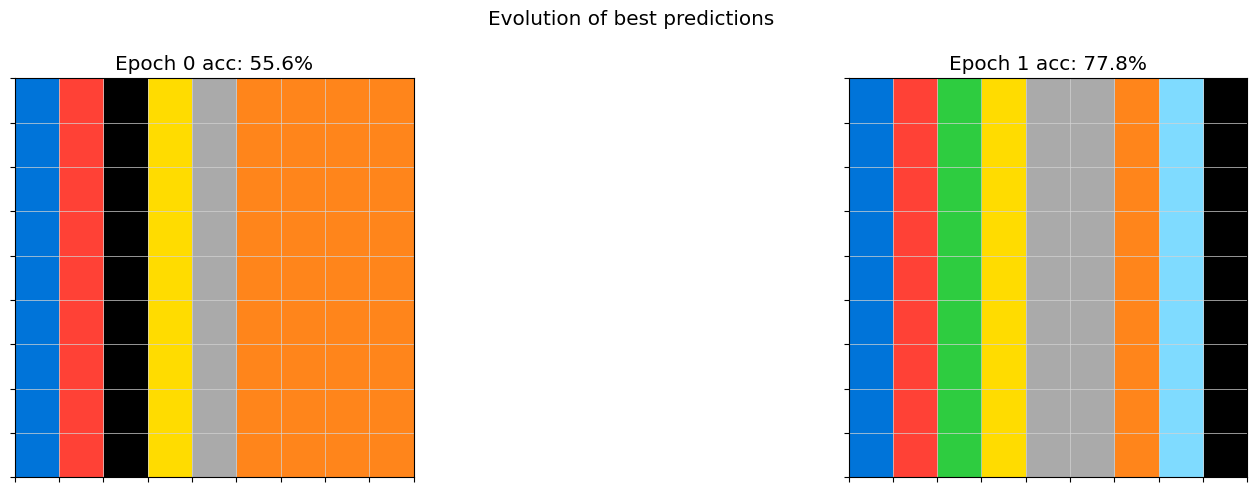

2025-05-06 18:52:48,144 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 18:52:48,213 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/138 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/138 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/138 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/138 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 138
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 138
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 18:53:16,170 - arc25.logging - INFO - wrapper - Executed finetuning in 28.0260 seconds
2025-05-06 18:53:16,172 - root - INFO - hindsight_experience_replay - Starting epoch 2...
2025-05-06 18:53:16,172 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 18:53:35,769 - root - INFO - inference - Number of unique outputs: 22/249
2025-05-06 18:53:35,771 - root - INFO - inference - Max pixel accuracy: 0.8888888888888888
2025-05-06 18:53:35,772 - arc25.logging - INFO - wrapper - Executed inference in 19.5990 seconds


Error executing code: def task(img):
    draw_vertical_line(img, x=0, color=1)
    draw_rectangle(img, point1=(0, 1), point2=(8, 8), color=2)
    draw_vertical_line(img, x=3, color=3)
    draw_vertical_line(img, x=4, color=4)
    draw_vertical_line(img, x=5, color=5)
    draw_vertical_line(img, x=6, color=6)
    draw_vertical_line(img, x=7, color=7)
    draw_vertical_line(img, x=8, color=8)
    draw_vertical_line(img, x=9, color=9)
    return img
index 9 is out of bounds for axis 1 with size 9
Error executing code: def task(img):
    draw_vertical_line(img, x=0, color=1)
    draw_rectangle(img, point1=(0, 1), point2=(8, 8), color=2)
    draw_vertical_line(img, x=3, color=3)
    draw_vertical_line(img, x=4, color=4)
    draw_vertical_line(img, x=5, color=5)
    draw_vertical_line(img, x=6, color=6)
    draw_vertical_line(img, x=7, color=7)
    draw_vertical_line(img, x=8, color=8)
    draw_vertical_line(img, x=9, color=9)
    return img
index 9 is out of bounds for axis 1 with size 9
Er

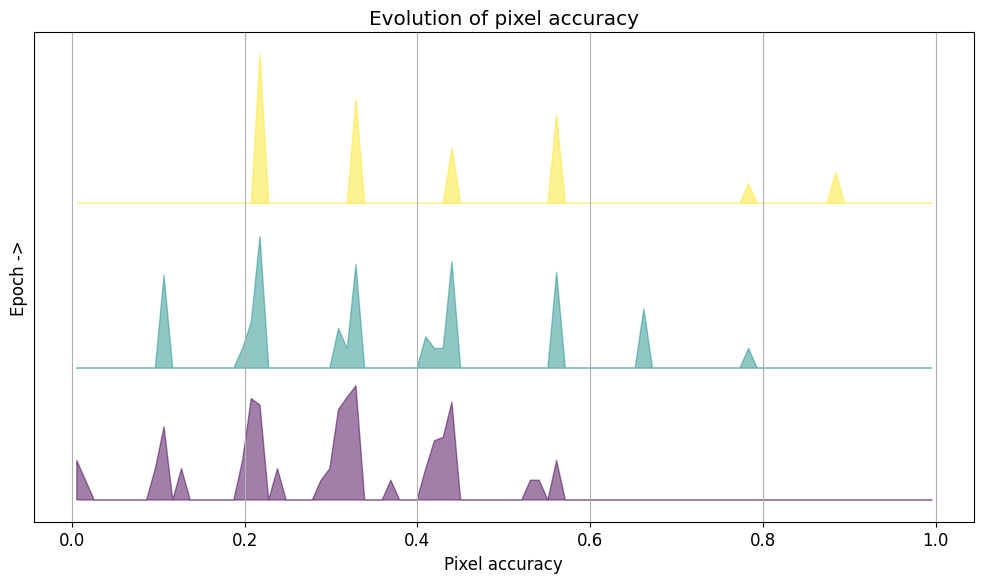

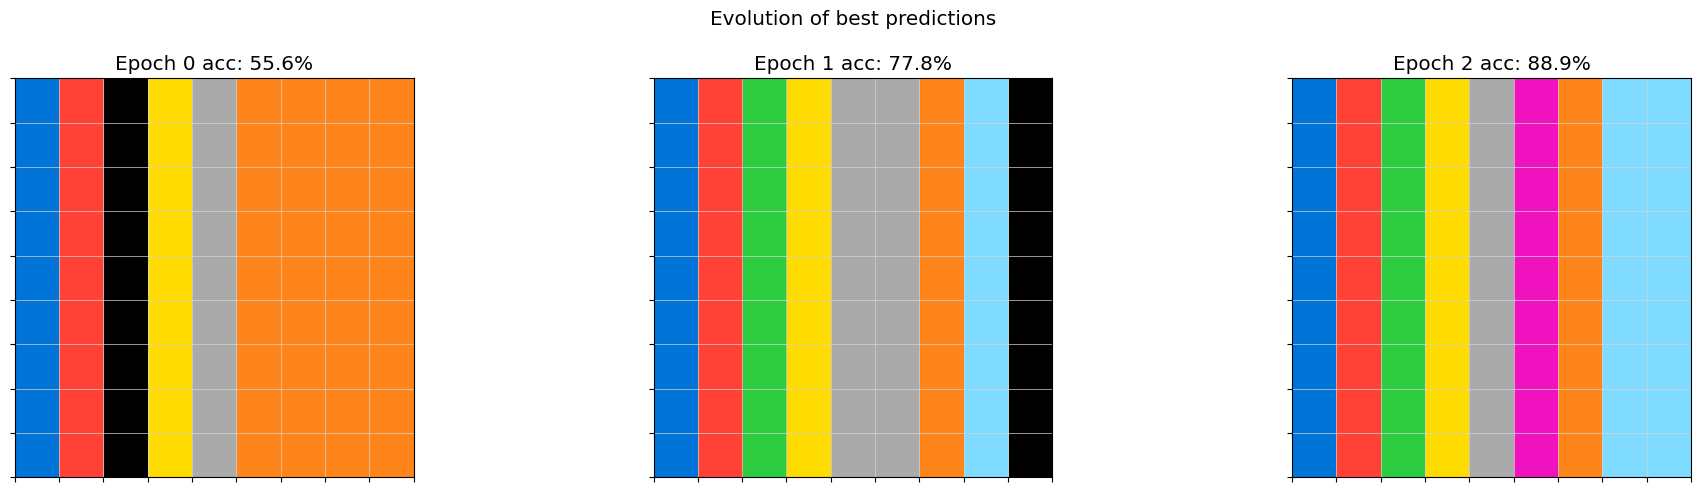

2025-05-06 18:53:36,107 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 18:53:36,159 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/22 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/22 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/22 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/22 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 22
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 22
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 18:53:41,292 - arc25.logging - INFO - wrapper - Executed finetuning in 5.1841 seconds
2025-05-06 18:53:41,293 - root - INFO - hindsight_experience_replay - Starting epoch 3...
2025-05-06 18:53:41,293 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 18:54:00,915 - root - INFO - inference - Number of unique outputs: 11/250
2025-05-06 18:54:00,916 - root - INFO - inference - Max pixel accuracy: 0.7777777777777778
2025-05-06 18:54:00,919 - arc25.logging - INFO - wrapper - Executed inference in 19.6257 seconds


Error executing code: def task(img):
    draw_vertical_line(img, x=0, color=1)
    draw_rectangle(img, point1=(0, 1), point2=(8, 8), color=2)
    draw_vertical_line(img, x=3, color=4)
    draw_vertical_line(img, x=6, color=5)
    draw_vertical_line(img, x=7, color=6)
    draw_vertical_line(img, x=8, color=7)
    draw_vertical_line(img, x=9, color=8)
    return img
index 9 is out of bounds for axis 1 with size 9
Error executing code: def task(img):
    draw_vertical_line(img, x=0, color=1)
    draw_rectangle(img, point1=(0, 1), point2=(8, 8), color=2)
    draw_vertical_line(img, x=3, color=4)
    draw_vertical_line(img, x=6, color=5)
    draw_vertical_line(img, x=7, color=6)
    draw_vertical_line(img, x=8, color=7)
    draw_vertical_line(img, x=9, color=8)
    return img
index 9 is out of bounds for axis 1 with size 9
Error executing code: def task(img):
    draw_vertical_line(img, x=0, color=1)
    draw_rectangle(img, point1=(0, 1), point2=(8, 8), color=2)
    draw_vertical_line(img, 

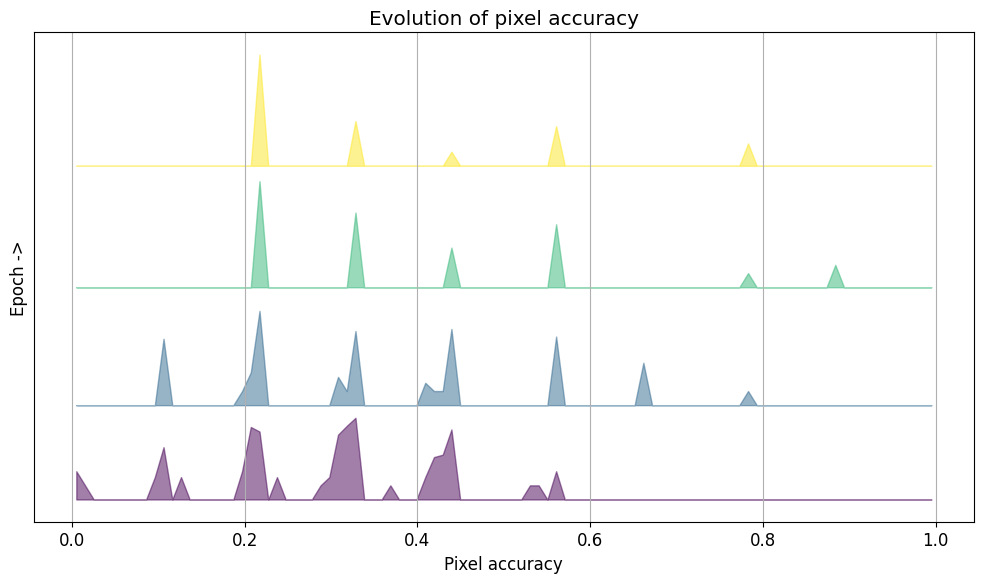

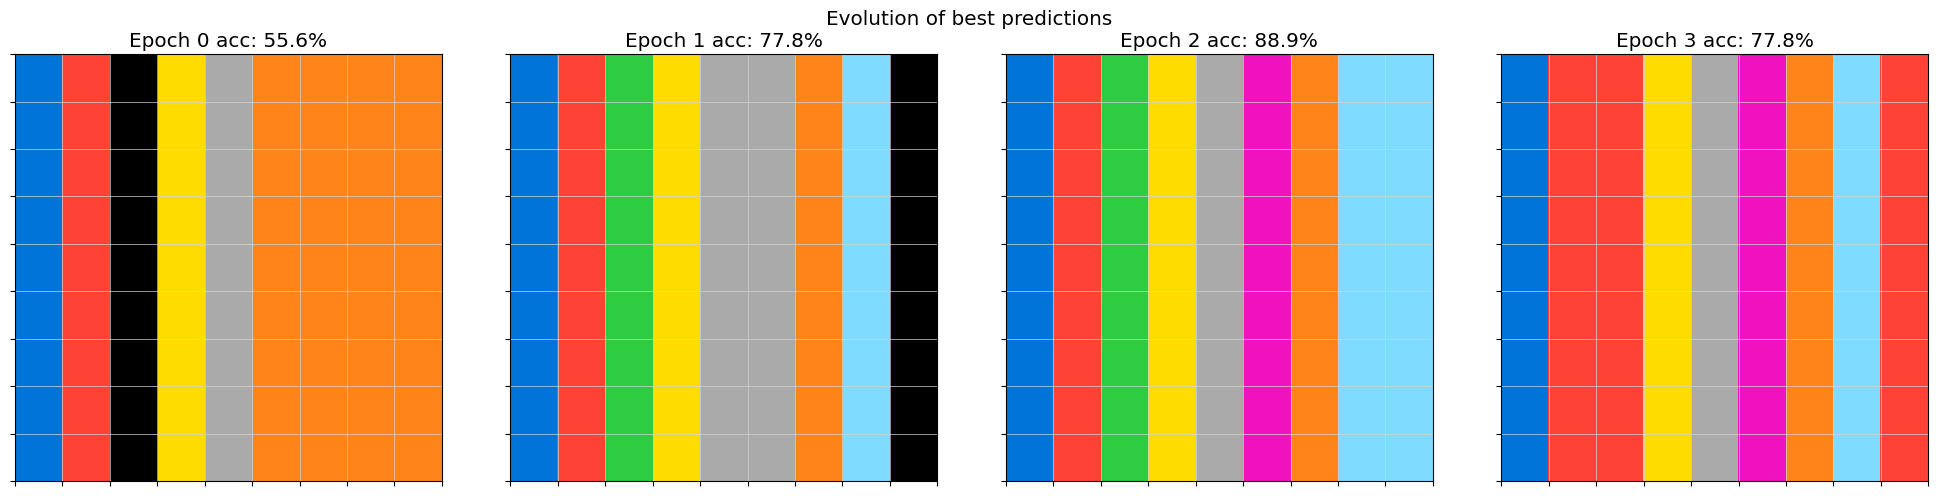

2025-05-06 18:54:01,294 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 18:54:01,349 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/11 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/11 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/11 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/11 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 11
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 11
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 18:54:04,475 - arc25.logging - INFO - wrapper - Executed finetuning in 3.1793 seconds
2025-05-06 18:54:04,476 - root - INFO - hindsight_experience_replay - Starting epoch 4...
2025-05-06 18:54:04,477 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 18:54:19,748 - root - INFO - inference - Number of unique outputs: 9/256
2025-05-06 18:54:19,750 - root - INFO - inference - Max pixel accuracy: 0.7777777777777778
2025-05-06 18:54:19,751 - arc25.logging - INFO - wrapper - Executed inference in 15.2734 seconds


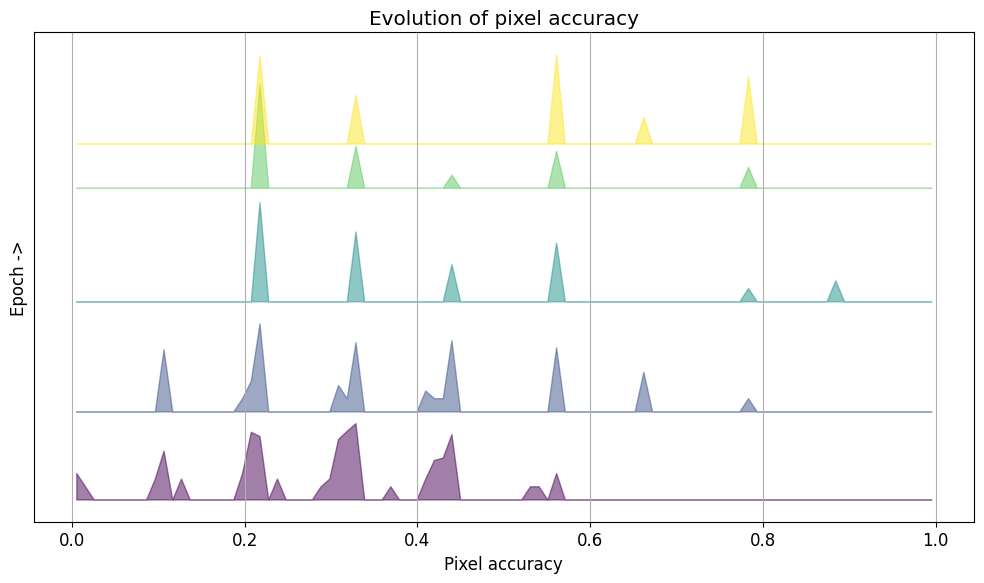

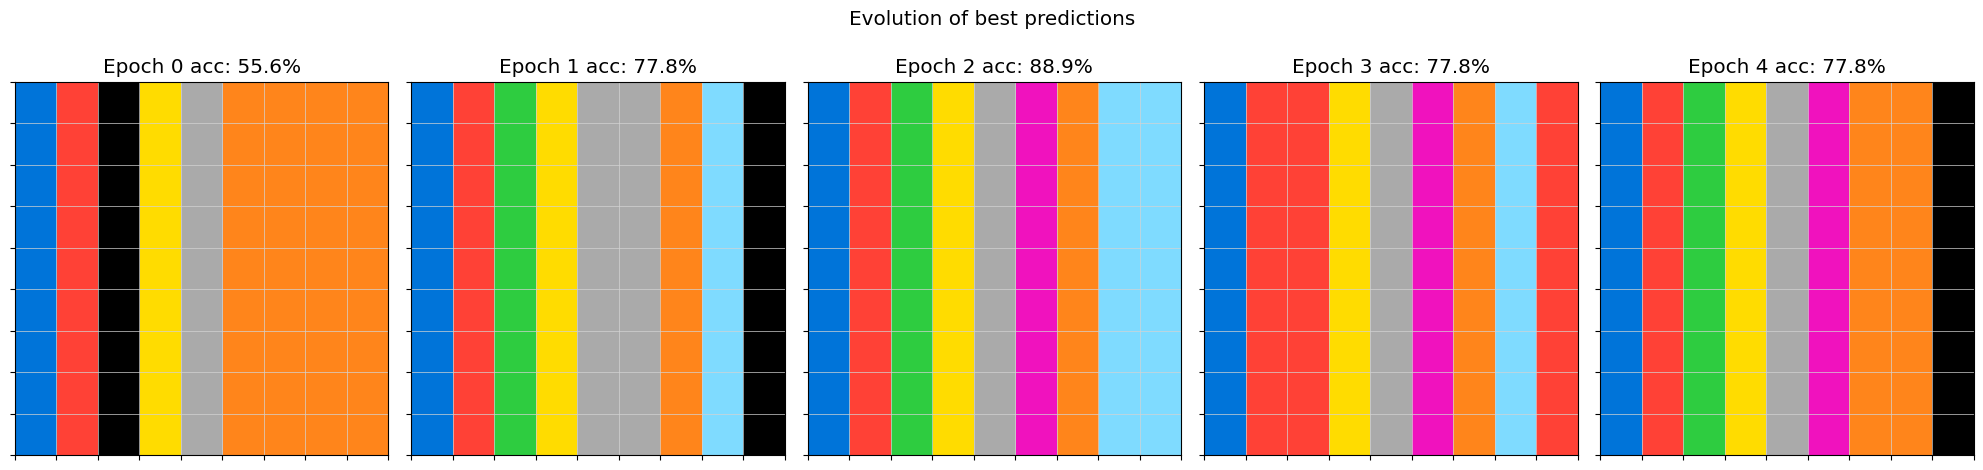

2025-05-06 18:54:20,181 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 18:54:20,233 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/9 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/9 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/9 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/9 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 9
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 18:54:23,273 - arc25.logging - INFO - wrapper - Executed finetuning in 3.0913 seconds
2025-05-06 18:54:23,275 - root - INFO - hindsight_experience_replay - Starting epoch 5...
2025-05-06 18:54:23,275 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 18:54:40,060 - root - INFO - inference - Number of unique outputs: 6/256
2025-05-06 18:54:40,062 - root - INFO - inference - Max pixel accuracy: 1.0
2025-05-06 18:54:40,065 - arc25.logging - INFO - wrapper - Executed inference in 16.7896 seconds


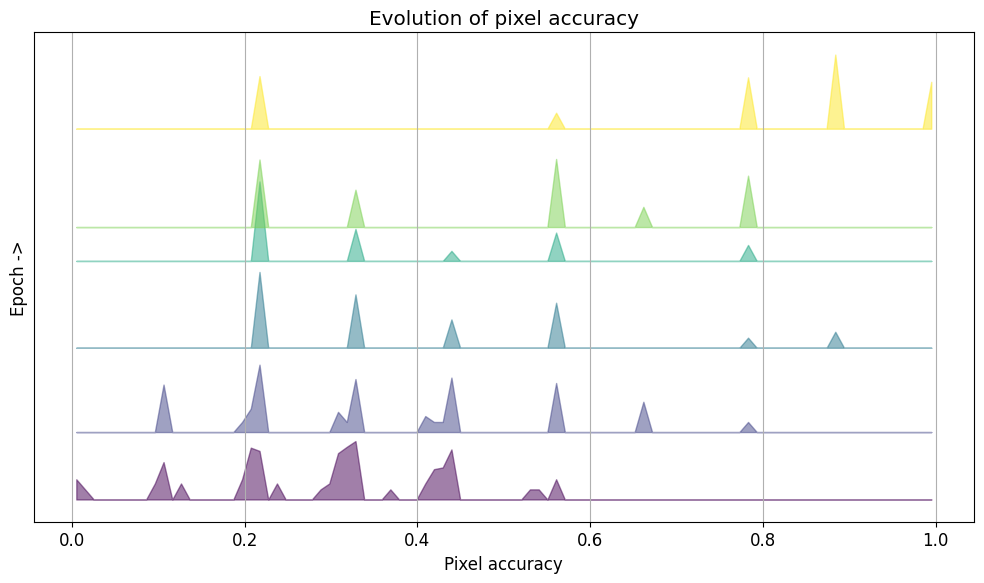

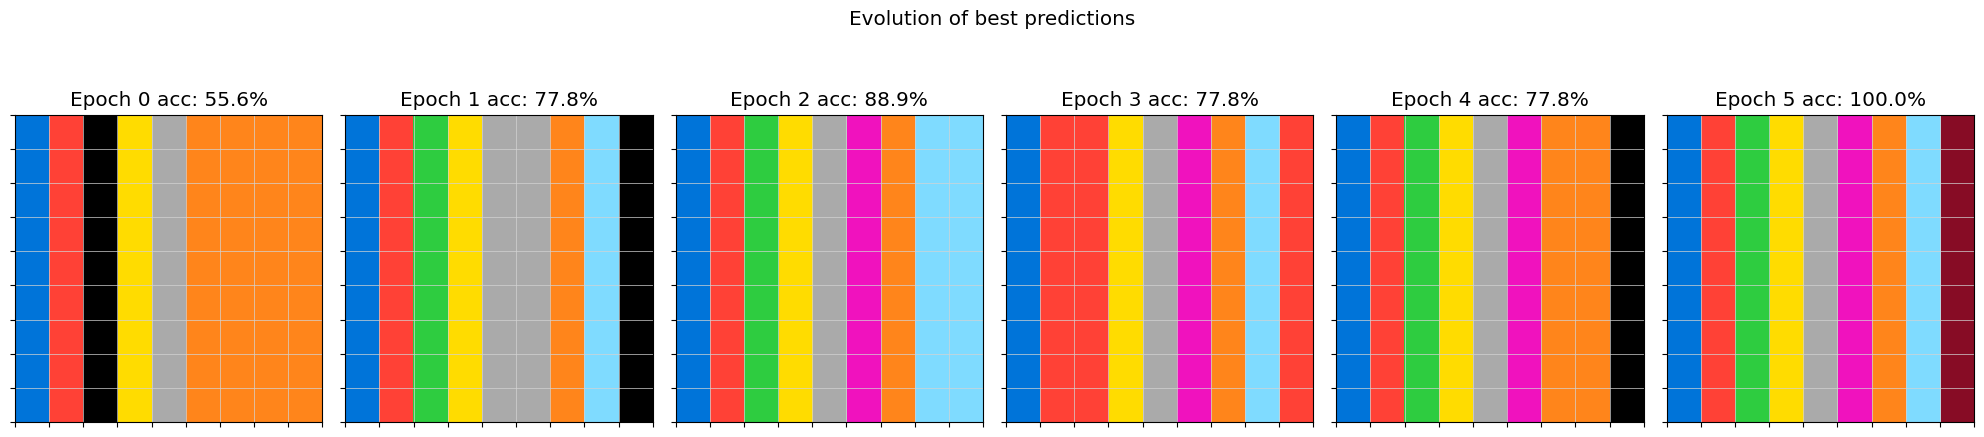

2025-05-06 18:54:40,774 - arc25.input_generation - INFO - hindsight_experience_replay - Found a perfect prediction at epoch 5!


# Best prediction code

```python
def task(img):
    draw_vertical_line(img, x=0, color=1)
    draw_vertical_line(img, x=1, color=2)
    draw_vertical_line(img, x=2, color=3)
    draw_vertical_line(img, x=3, color=4)
    draw_vertical_line(img, x=4, color=5)
    draw_vertical_line(img, x=5, color=6)
    draw_vertical_line(img, x=6, color=7)
    draw_vertical_line(img, x=7, color=8)
    draw_vertical_line(img, x=8, color=9)
    return img
```

2025-05-06 18:54:40,842 - arc25.logging - INFO - wrapper - Executed hindsight_experience_replay in 191.9796 seconds


In [15]:
input_img = create_img((9, 9), color=0)
output_img = input_img.copy()
for x in range(0, input_img.shape[1], 1):
    draw_vertical_line(output_img, x, color=x+1)

task = Task(inputs=[input_img], outputs=[output_img], code='', name='manual')
hindsight_experience_replay(task, Config(lora_path='/mnt/hdd0/Kaggle/arc25/trainings/20250430_first_trainings/steps_400/checkpoint-400'));

#### 12 squares

2025-05-06 18:57:52,073 - arc25.logging - INFO - wrapper - Executing hindsight_experience_replay...


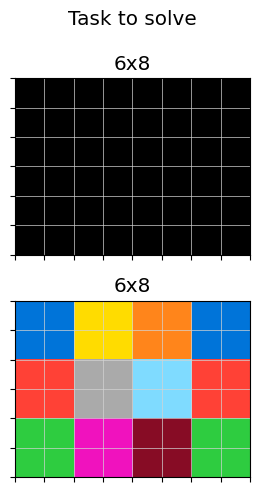

2025-05-06 18:57:52,217 - arc25.logging - INFO - wrapper - Executing load_model...
2025-05-06 18:57:52,217 - root - INFO - load_model - Loading model from /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct and LoRA from /mnt/hdd0/Kaggle/arc25/trainings/20250430_first_trainings/steps_400/checkpoint-400
loading configuration file /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct/config.json
Model config Qwen2Config {
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 896,
  "initializer_range": 0.02,
  "intermediate_size": 4864,
  "max_position_embeddings": 32768,
  "max_window_layers": 24,
  "model_type": "qwen2",
  "num_attention_heads": 14,
  "num_hidden_layers": 24,
  "num_key_value_heads": 2,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 1000000.0,
  "sliding_window": 32768,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "trans

  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 18:58:14,061 - root - INFO - inference - Number of unique outputs: 256/256
2025-05-06 18:58:14,063 - root - INFO - inference - Max pixel accuracy: 0.5416666666666666
2025-05-06 18:58:14,066 - arc25.logging - INFO - wrapper - Executed inference in 20.7567 seconds


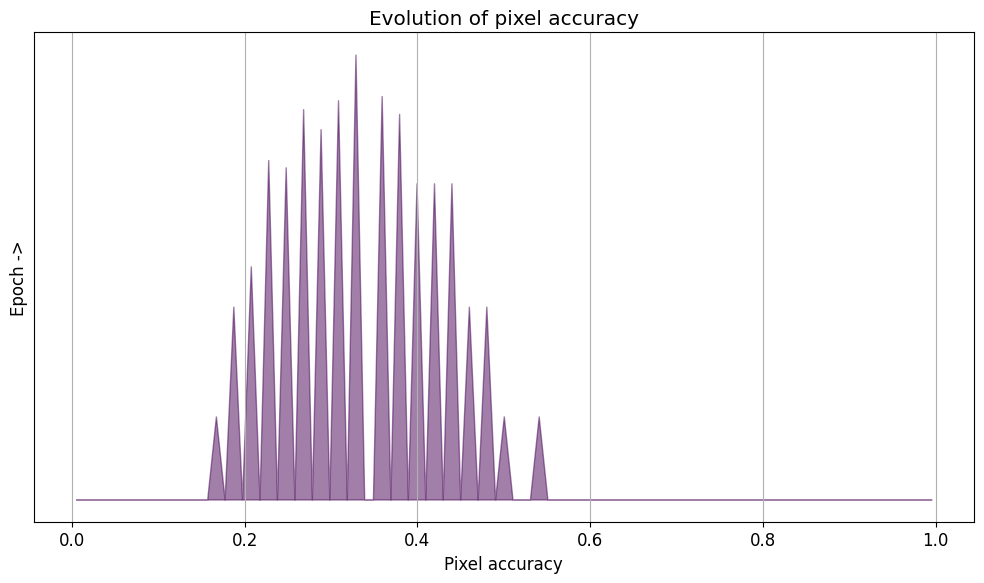

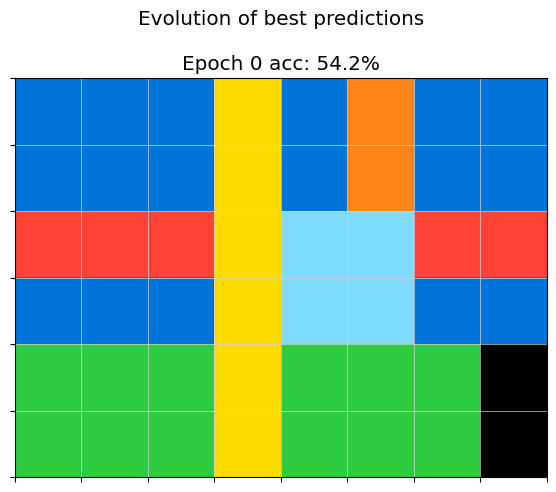

2025-05-06 18:58:14,224 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 18:58:14,339 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/256 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 256
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 256
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 18:59:02,888 - arc25.logging - INFO - wrapper - Executed finetuning in 48.6632 seconds
2025-05-06 18:59:02,889 - root - INFO - hindsight_experience_replay - Starting epoch 1...
2025-05-06 18:59:02,889 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 18:59:26,600 - root - INFO - inference - Number of unique outputs: 255/256
2025-05-06 18:59:26,601 - root - INFO - inference - Max pixel accuracy: 0.6041666666666666
2025-05-06 18:59:26,604 - arc25.logging - INFO - wrapper - Executed inference in 23.7150 seconds


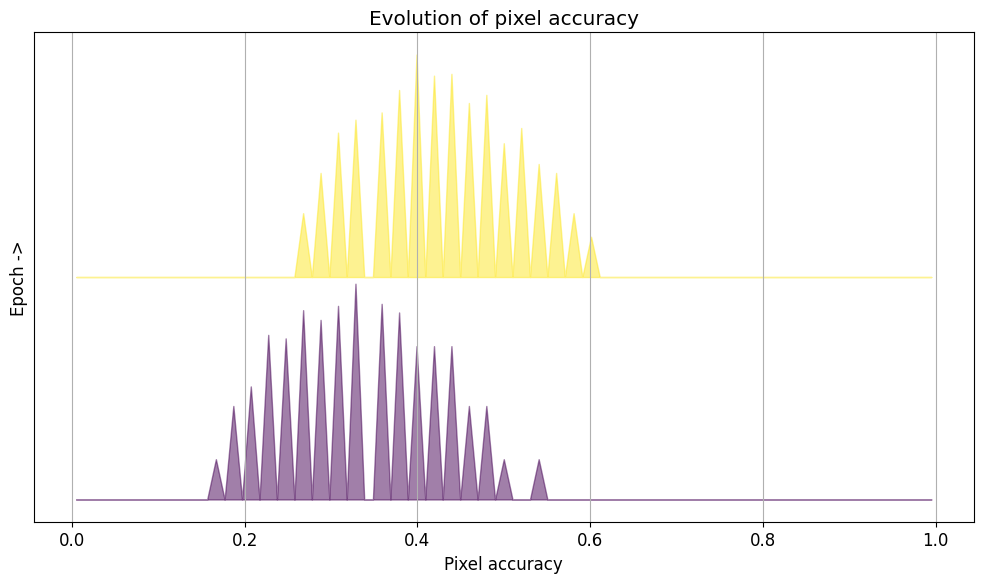

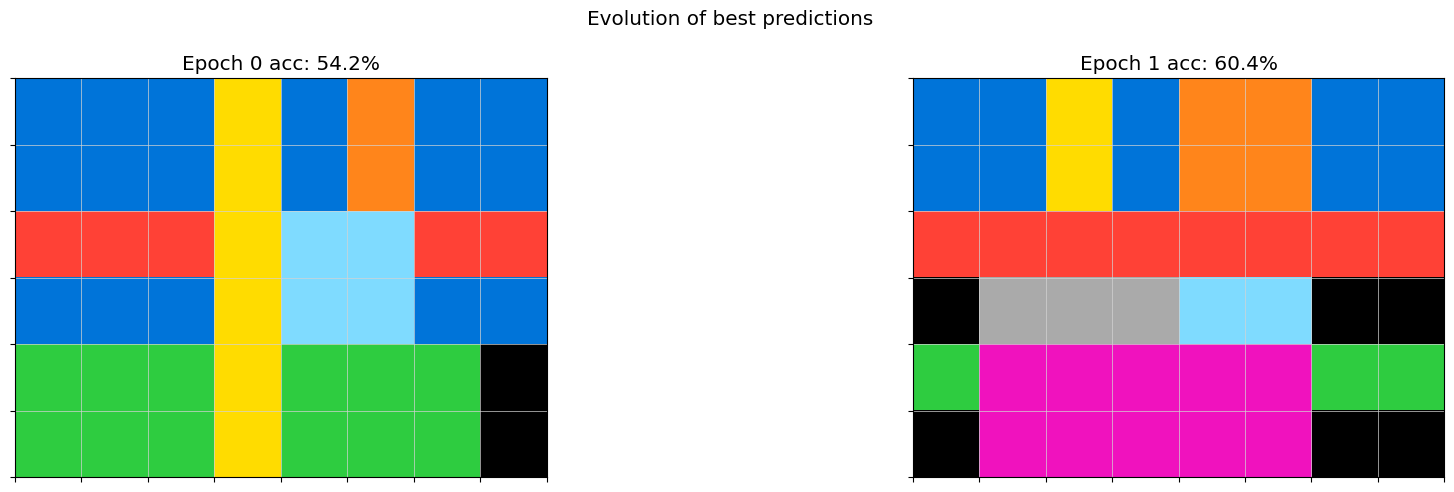

2025-05-06 18:59:26,941 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 18:59:27,056 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/255 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/255 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/255 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/255 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 255
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 255
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 19:00:15,650 - arc25.logging - INFO - wrapper - Executed finetuning in 48.7089 seconds
2025-05-06 19:00:15,652 - root - INFO - hindsight_experience_replay - Starting epoch 2...
2025-05-06 19:00:15,652 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 19:00:38,887 - root - INFO - inference - Number of unique outputs: 208/255
2025-05-06 19:00:38,889 - root - INFO - inference - Max pixel accuracy: 0.7083333333333334
2025-05-06 19:00:38,892 - arc25.logging - INFO - wrapper - Executed inference in 23.2385 seconds


Error executing code: def task(img):
    draw_rectangle(img, point1=(0, 0), point2=(1, 7), color=1)
    draw_horizontal_line(img, y=4, color=3)
    draw_vertical_line(img, x=4, color=9)
    draw_rectangle(img, point1=(2, 2), point2=(3, 4), color=5)
    draw_rectangle(img, point1=(0, 3), point2=(1, 5), color=4)
    draw_rectangle(img, point1=(2, 4), point2=(3, 5), color=8)
    draw_pixel(img, point=(2, 1), color=A)
    draw_rectangle(img, point1=(4, 1), point2=(5, 5), color=6)
    draw_vertical_line(img, x=5, color=7)
    draw_rectangle(img, point1=(2, 0), point2=(3, 1), color=2)
    return img
name 'A' is not defined


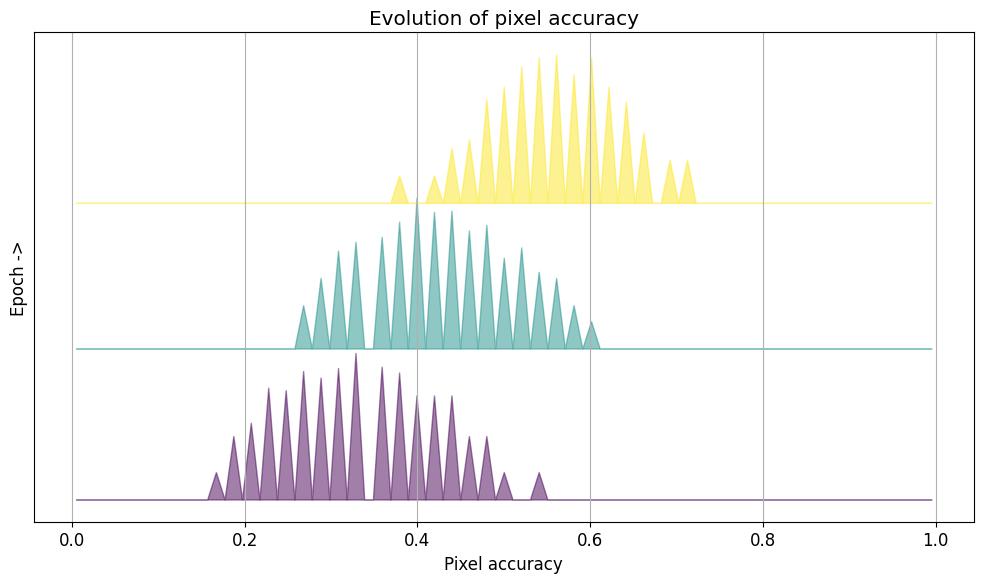

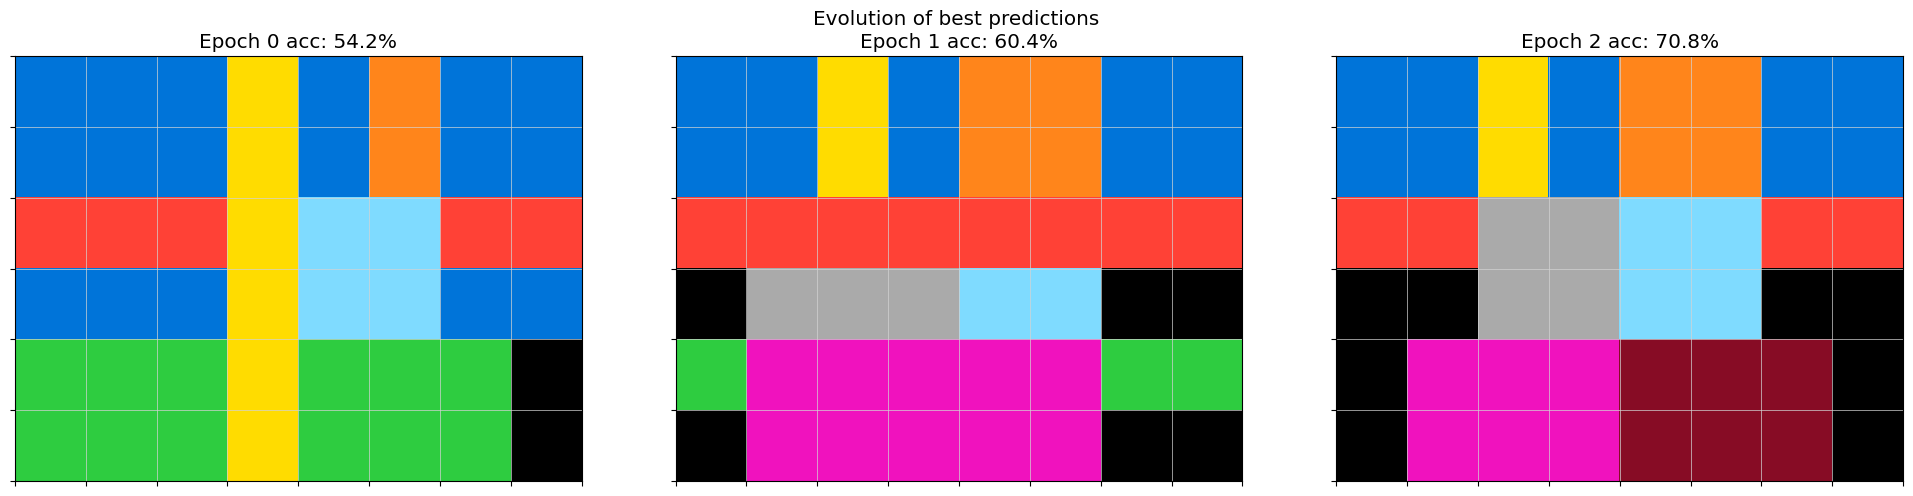

2025-05-06 19:00:39,299 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 19:00:39,399 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/208 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/208 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/208 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/208 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 208
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 208
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 19:01:19,338 - arc25.logging - INFO - wrapper - Executed finetuning in 40.0384 seconds
2025-05-06 19:01:19,339 - root - INFO - hindsight_experience_replay - Starting epoch 3...
2025-05-06 19:01:19,340 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 19:01:42,342 - root - INFO - inference - Number of unique outputs: 88/256
2025-05-06 19:01:42,344 - root - INFO - inference - Max pixel accuracy: 0.7291666666666666
2025-05-06 19:01:42,348 - arc25.logging - INFO - wrapper - Executed inference in 23.0071 seconds


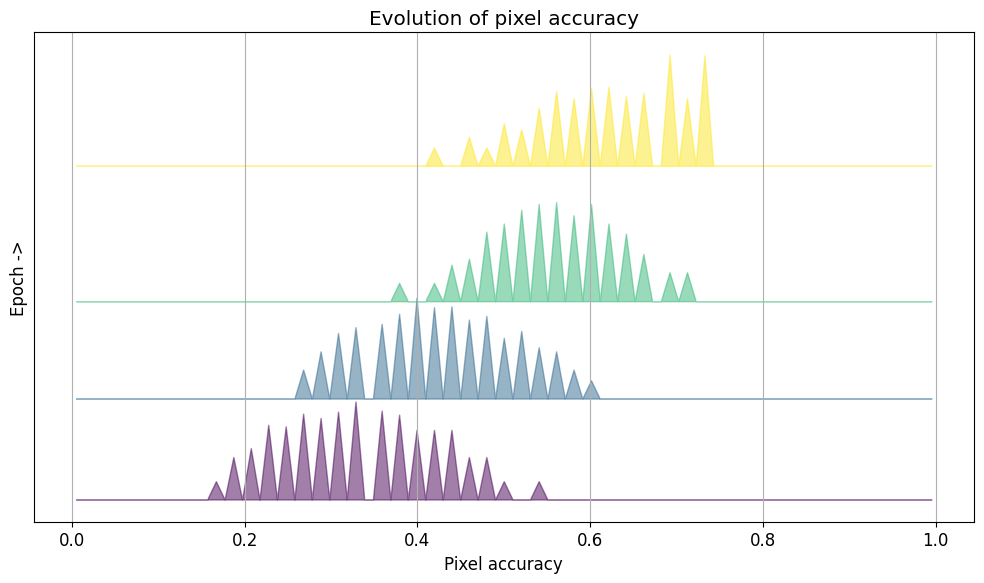

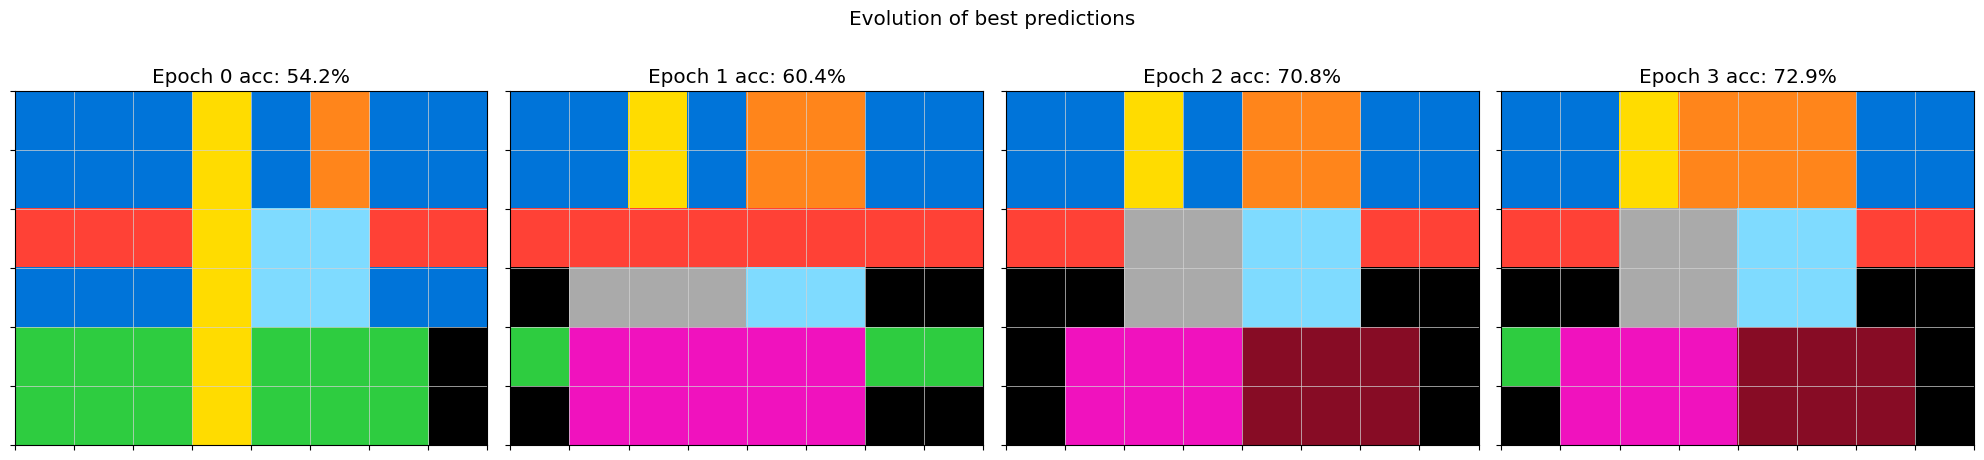

2025-05-06 19:01:42,721 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 19:01:42,795 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/88 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/88 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/88 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/88 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 88
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 88
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 19:02:01,039 - arc25.logging - INFO - wrapper - Executed finetuning in 18.3171 seconds
2025-05-06 19:02:01,040 - root - INFO - hindsight_experience_replay - Starting epoch 4...
2025-05-06 19:02:01,041 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 19:02:32,368 - root - INFO - inference - Number of unique outputs: 58/256
2025-05-06 19:02:32,369 - root - INFO - inference - Max pixel accuracy: 0.7708333333333334
2025-05-06 19:02:32,371 - arc25.logging - INFO - wrapper - Executed inference in 31.3291 seconds


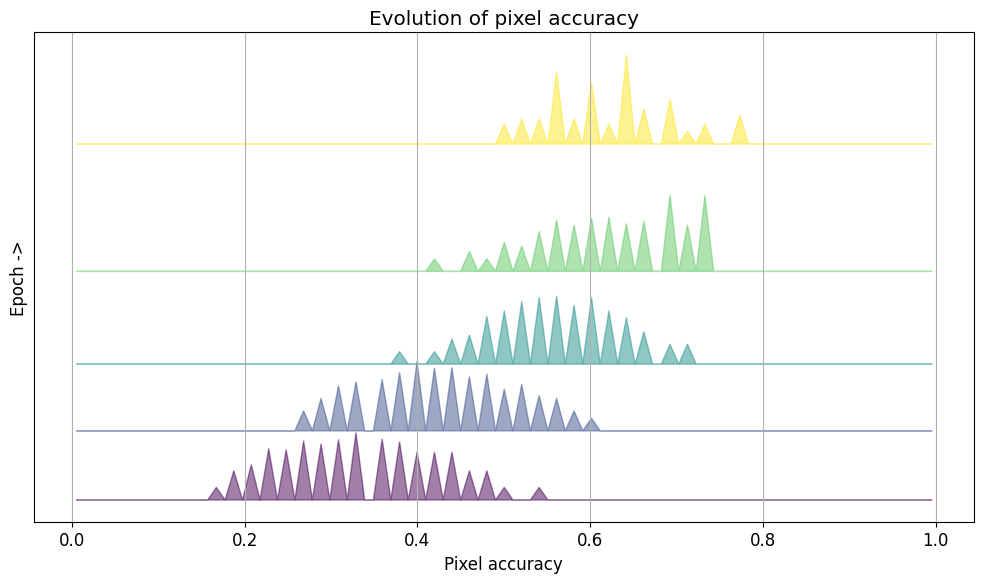

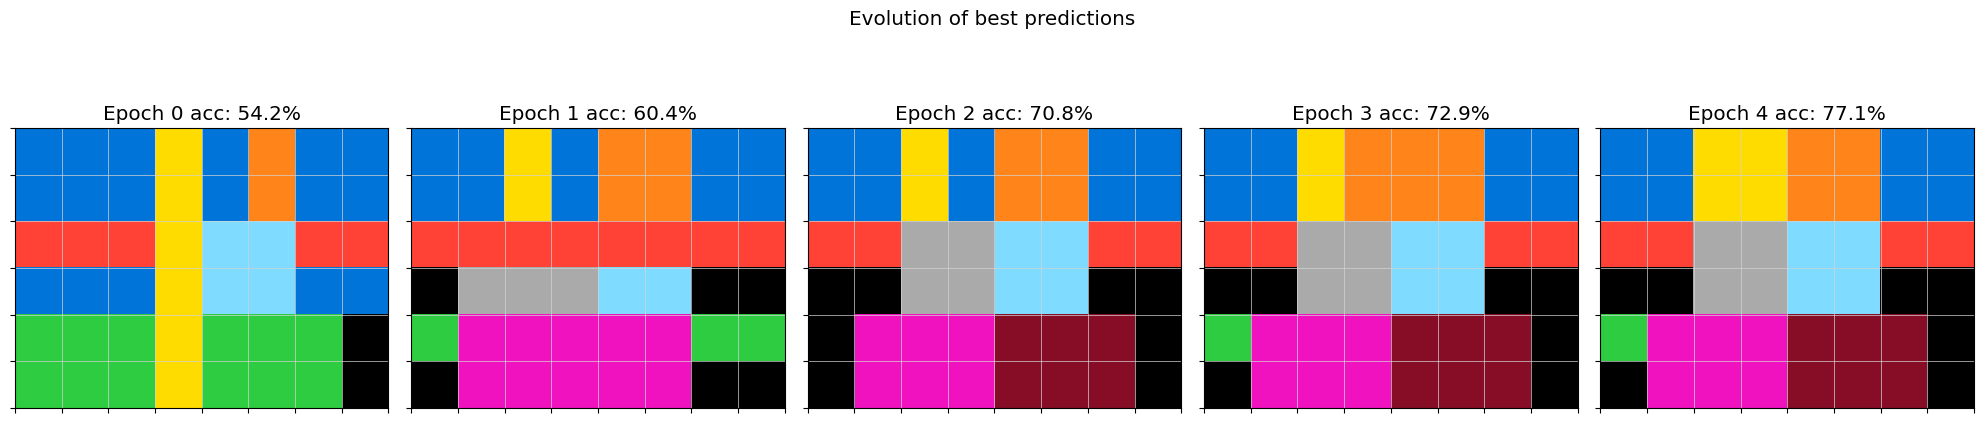

2025-05-06 19:02:32,750 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 19:02:32,808 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/58 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/58 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/58 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/58 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 58
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 58
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 19:02:44,994 - arc25.logging - INFO - wrapper - Executed finetuning in 12.2438 seconds
2025-05-06 19:02:44,996 - root - INFO - hindsight_experience_replay - Starting epoch 5...
2025-05-06 19:02:44,996 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 19:03:11,804 - root - INFO - inference - Number of unique outputs: 39/256
2025-05-06 19:03:11,805 - root - INFO - inference - Max pixel accuracy: 0.8125
2025-05-06 19:03:11,807 - arc25.logging - INFO - wrapper - Executed inference in 26.8099 seconds


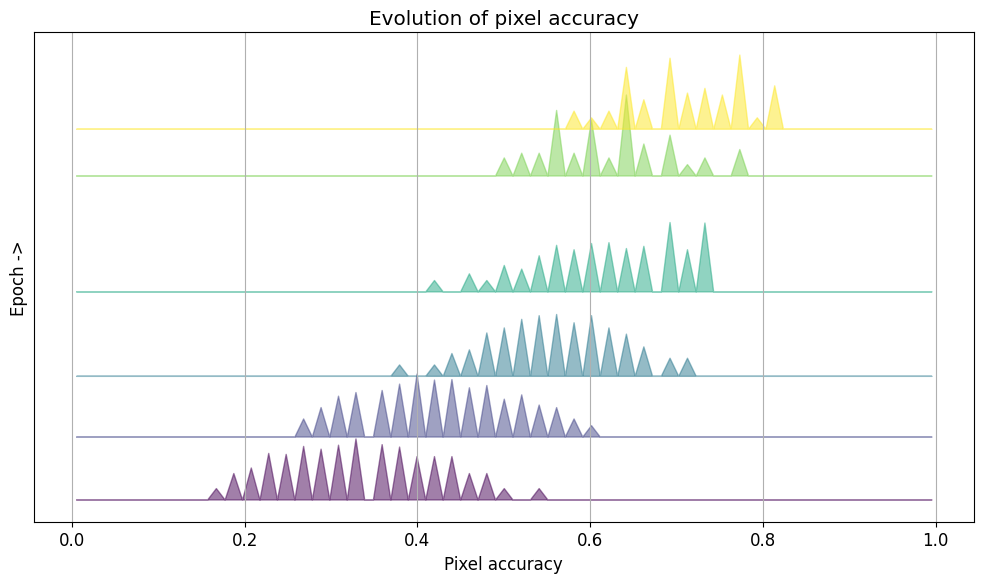

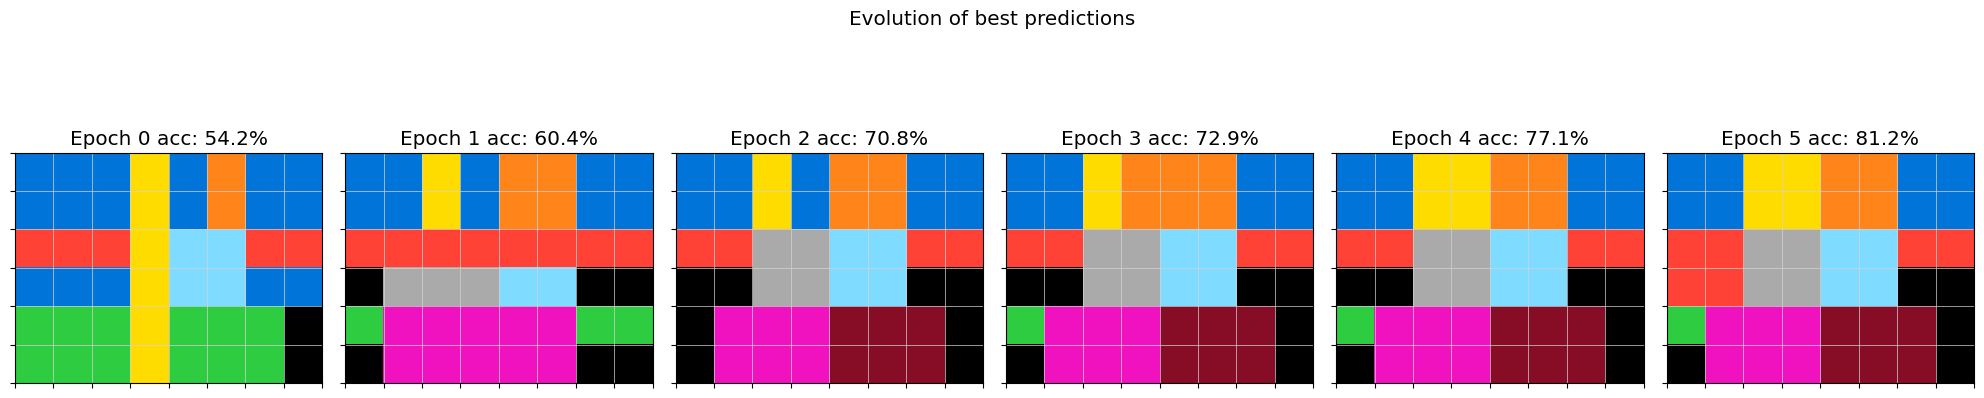

2025-05-06 19:03:12,218 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 19:03:12,270 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/39 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/39 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/39 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/39 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 39
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 39
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 19:03:20,568 - arc25.logging - INFO - wrapper - Executed finetuning in 8.3490 seconds
2025-05-06 19:03:20,569 - root - INFO - hindsight_experience_replay - Starting epoch 6...
2025-05-06 19:03:20,569 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 19:03:47,484 - root - INFO - inference - Number of unique outputs: 26/256
2025-05-06 19:03:47,487 - root - INFO - inference - Max pixel accuracy: 0.7916666666666666
2025-05-06 19:03:47,490 - arc25.logging - INFO - wrapper - Executed inference in 26.9209 seconds


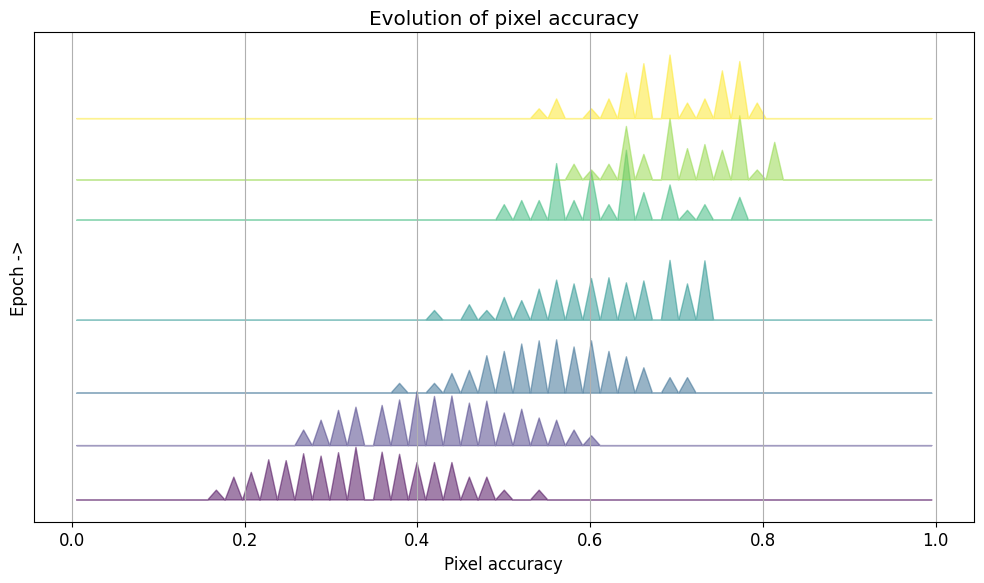

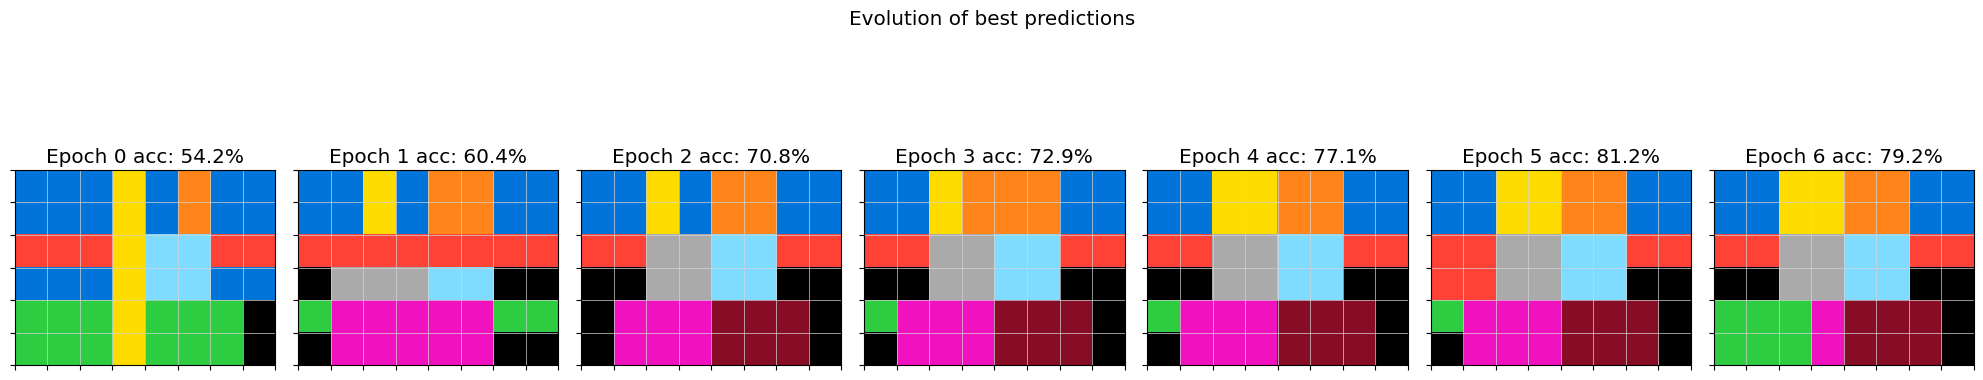

2025-05-06 19:03:47,965 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 19:03:48,019 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/26 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/26 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/26 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/26 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 26
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 26
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 19:03:53,529 - arc25.logging - INFO - wrapper - Executed finetuning in 5.5626 seconds
2025-05-06 19:03:53,530 - root - INFO - hindsight_experience_replay - Starting epoch 7...
2025-05-06 19:03:53,531 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 19:04:21,337 - root - INFO - inference - Number of unique outputs: 15/256
2025-05-06 19:04:21,339 - root - INFO - inference - Max pixel accuracy: 0.8125
2025-05-06 19:04:21,341 - arc25.logging - INFO - wrapper - Executed inference in 27.8096 seconds


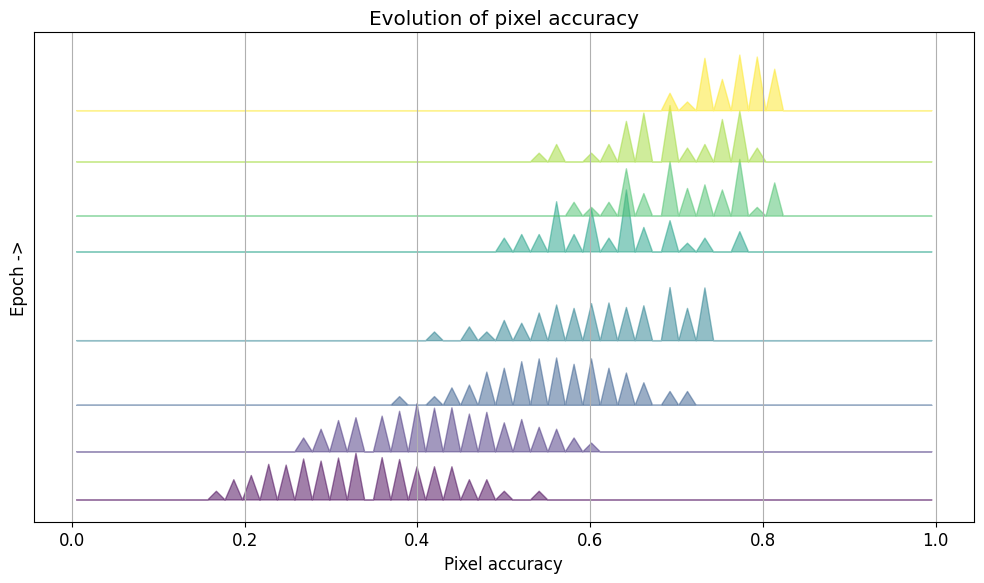

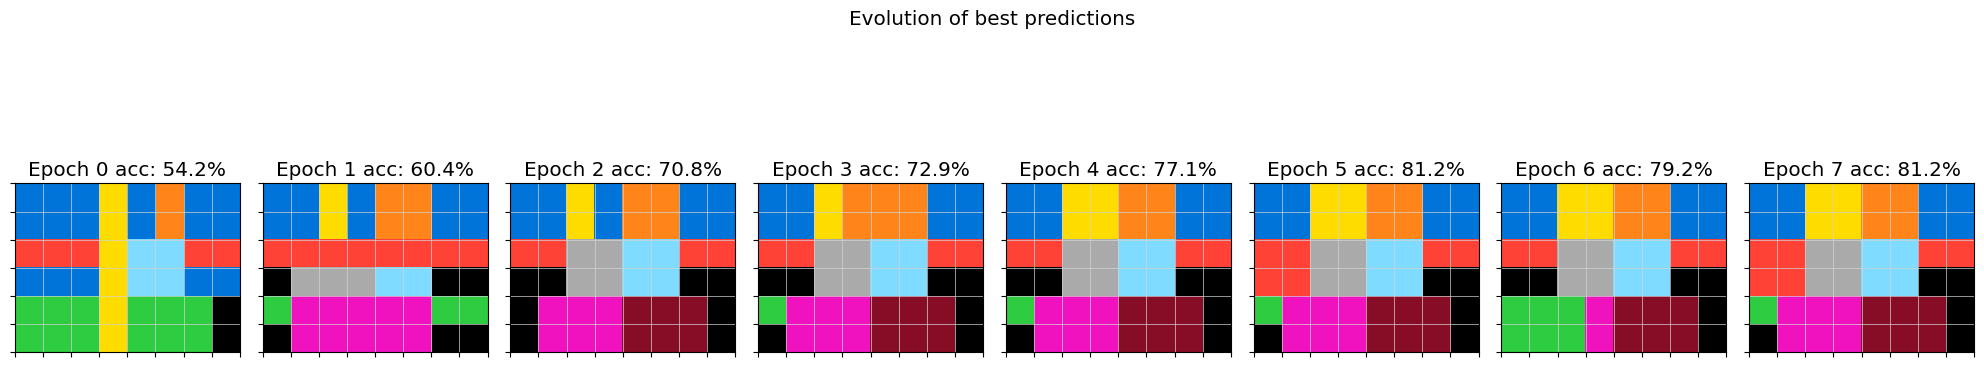

2025-05-06 19:04:21,902 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 19:04:21,954 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/15 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/15 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/15 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/15 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 15
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 15
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 19:04:25,559 - arc25.logging - INFO - wrapper - Executed finetuning in 3.6560 seconds
2025-05-06 19:04:25,560 - root - INFO - hindsight_experience_replay - Starting epoch 8...
2025-05-06 19:04:25,561 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 19:04:57,677 - root - INFO - inference - Number of unique outputs: 23/256
2025-05-06 19:04:57,679 - root - INFO - inference - Max pixel accuracy: 0.875
2025-05-06 19:04:57,682 - arc25.logging - INFO - wrapper - Executed inference in 32.1203 seconds


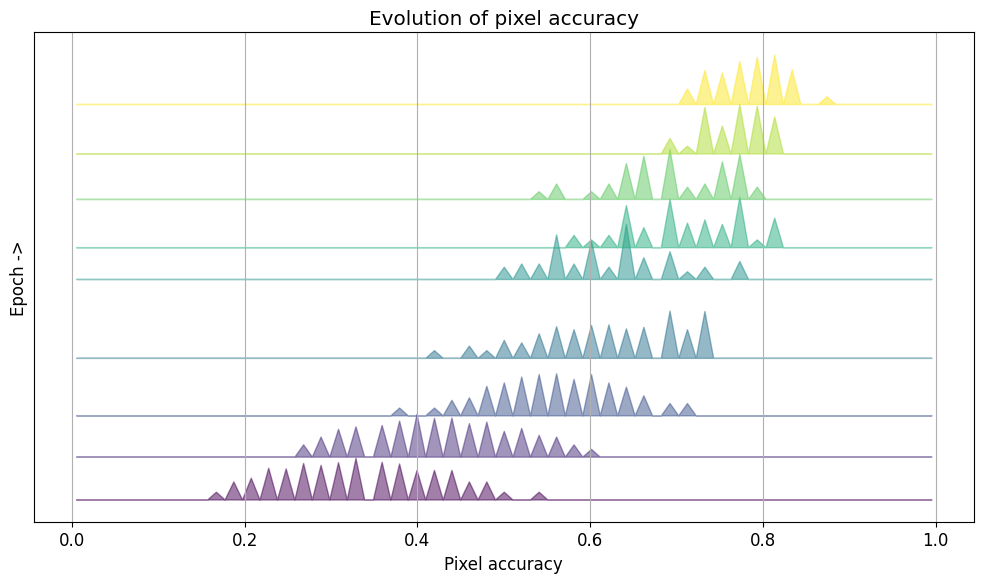

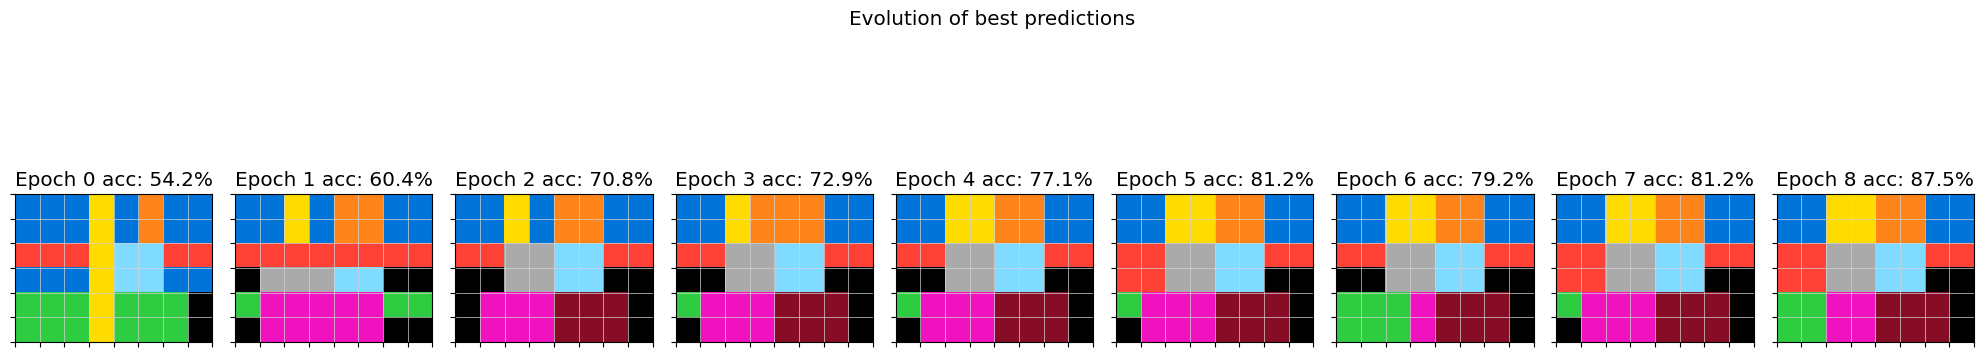

2025-05-06 19:04:58,232 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 19:04:58,288 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/23 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/23 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/23 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/23 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 23
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 19:05:03,822 - arc25.logging - INFO - wrapper - Executed finetuning in 5.5884 seconds
2025-05-06 19:05:03,823 - root - INFO - hindsight_experience_replay - Starting epoch 9...
2025-05-06 19:05:03,823 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 19:05:35,950 - root - INFO - inference - Number of unique outputs: 45/256
2025-05-06 19:05:35,951 - root - INFO - inference - Max pixel accuracy: 0.875
2025-05-06 19:05:35,953 - arc25.logging - INFO - wrapper - Executed inference in 32.1287 seconds


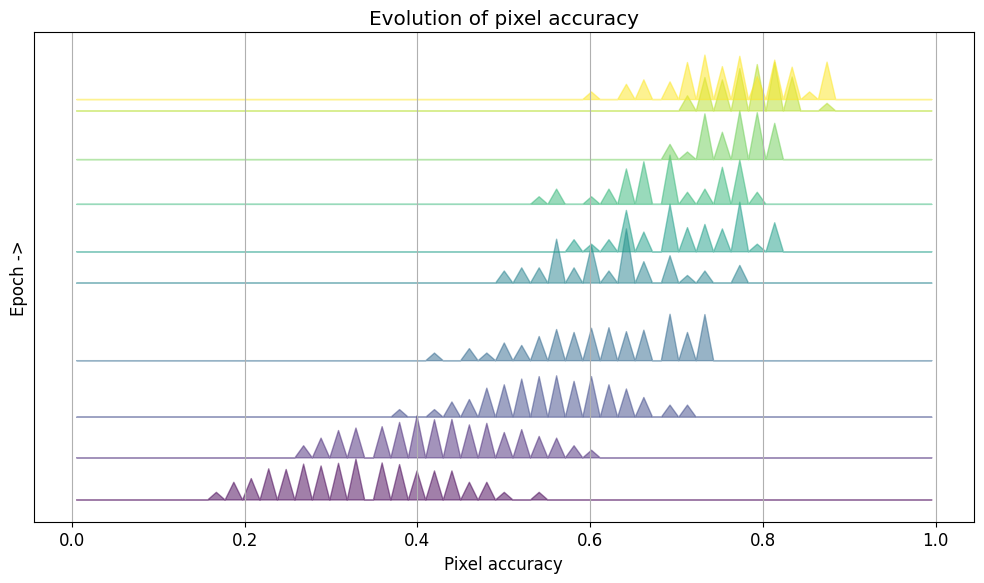

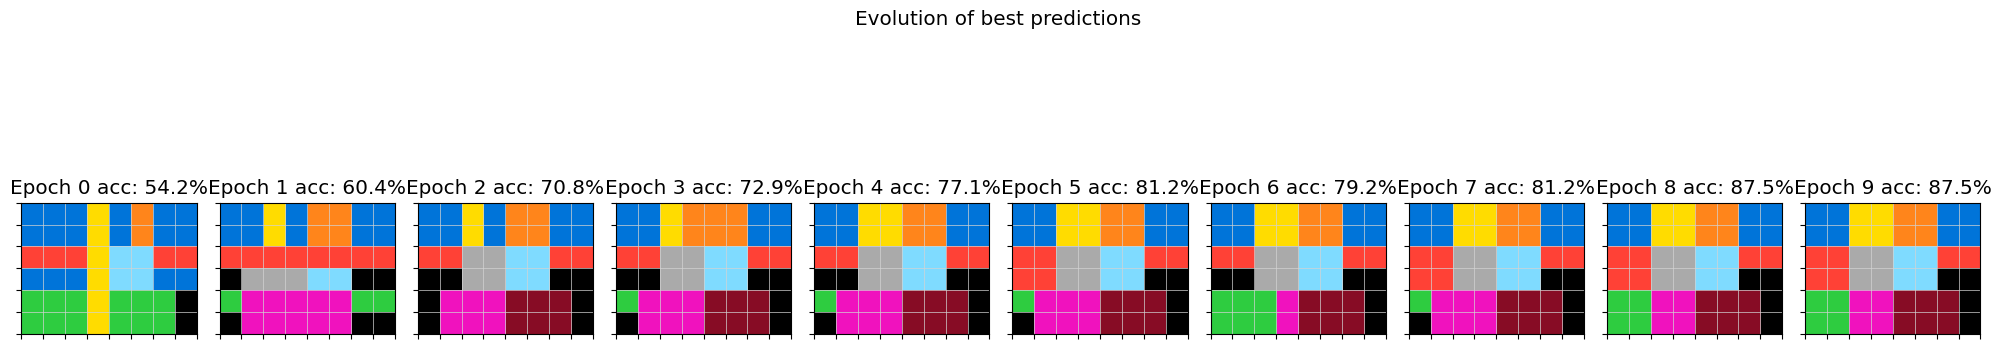

2025-05-06 19:05:36,536 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 19:05:36,589 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/45 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/45 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/45 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/45 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 45
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 45
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 19:05:46,096 - arc25.logging - INFO - wrapper - Executed finetuning in 9.5598 seconds


# Best prediction code

```python
def task(img):
    draw_rectangle(img, point1=(0, 0), point2=(1, 7), color=1)
    draw_horizontal_line(img, y=2, color=2)
    draw_vertical_line(img, x=4, color=7)
    draw_rectangle(img, point1=(4, 1), point2=(5, 5), color=6)
    draw_rectangle(img, point1=(0, 2), point2=(1, 4), color=4)
    draw_rectangle(img, point1=(4, 4), point2=(5, 6), color=9)
    draw_pixel(img, point=(4, 2), color=6)
    draw_rectangle(img, point1=(2, 2), point2=(3, 4), color=5)
    draw_rectangle(img, point1=(2, 4), point2=(3, 5), color=8)
    draw_rectangle(img, point1=(2, 0), point2=(3, 1), color=2)
    draw_rectangle(img, point1=(0, 4), point2=(1, 5), color=7)
    draw_rectangle(img, point1=(4, 0), point2=(5, 1), color=3)
    return img
```

2025-05-06 19:05:46,176 - arc25.logging - INFO - wrapper - Executed hindsight_experience_replay in 474.1018 seconds


In [18]:
input_img = create_img((6, 8), color=0)
output_img = input_img.copy()
color = 0
for x in range(0, input_img.shape[1], 2):
    for y in range(0, input_img.shape[0], 2):
        color = (color + 1) % 10
        if color == 0: color = 1
        draw_rectangle(output_img, (y, x), (y+1, x+1), color=color)
task = Task(inputs=[input_img], outputs=[output_img], code='', name='manual')
hindsight_experience_replay(task, Config(lora_path='/mnt/hdd0/Kaggle/arc25/trainings/20250430_first_trainings/steps_400/checkpoint-400'));

### 800 training steps

#### 12 squares

2025-05-06 19:17:25,583 - arc25.logging - INFO - wrapper - Executing hindsight_experience_replay...


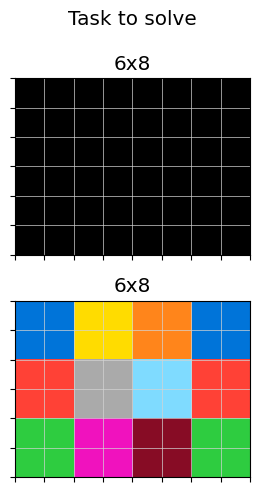

2025-05-06 19:17:25,785 - arc25.logging - INFO - wrapper - Executing load_model...
2025-05-06 19:17:25,786 - root - INFO - load_model - Loading model from /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct and LoRA from /mnt/hdd0/Kaggle/arc25/trainings/20250430_first_trainings/steps_800/checkpoint-800
loading configuration file /home/gbarbadillo/models/Qwen2.5-Coder-0.5B-Instruct/config.json
Model config Qwen2Config {
  "architectures": [
    "Qwen2ForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 896,
  "initializer_range": 0.02,
  "intermediate_size": 4864,
  "max_position_embeddings": 32768,
  "max_window_layers": 24,
  "model_type": "qwen2",
  "num_attention_heads": 14,
  "num_hidden_layers": 24,
  "num_key_value_heads": 2,
  "rms_norm_eps": 1e-06,
  "rope_scaling": null,
  "rope_theta": 1000000.0,
  "sliding_window": 32768,
  "tie_word_embeddings": true,
  "torch_dtype": "bfloat16",
  "trans

  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 19:17:47,796 - root - INFO - inference - Number of unique outputs: 256/256
2025-05-06 19:17:47,797 - root - INFO - inference - Max pixel accuracy: 0.5625
2025-05-06 19:17:47,808 - arc25.logging - INFO - wrapper - Executed inference in 20.7240 seconds


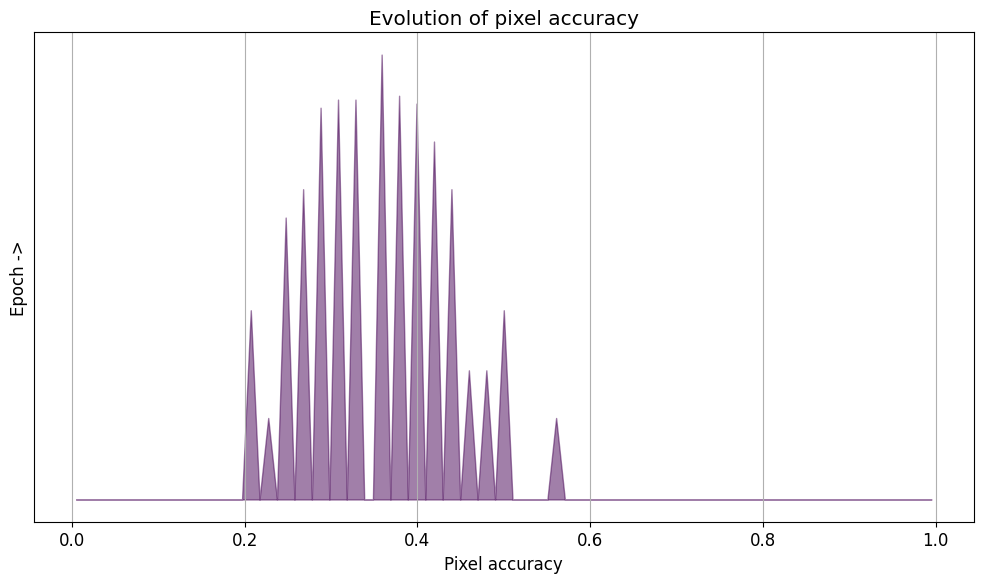

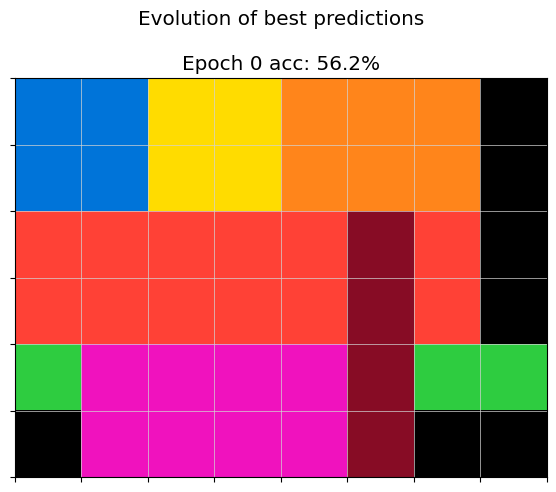

2025-05-06 19:17:47,996 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 19:17:48,104 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/256 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/256 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 256
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 256
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 19:18:36,828 - arc25.logging - INFO - wrapper - Executed finetuning in 48.8316 seconds
2025-05-06 19:18:36,830 - root - INFO - hindsight_experience_replay - Starting epoch 1...
2025-05-06 19:18:36,831 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 19:18:59,431 - root - INFO - inference - Number of unique outputs: 223/256
2025-05-06 19:18:59,432 - root - INFO - inference - Max pixel accuracy: 0.6666666666666666
2025-05-06 19:18:59,437 - arc25.logging - INFO - wrapper - Executed inference in 22.6055 seconds


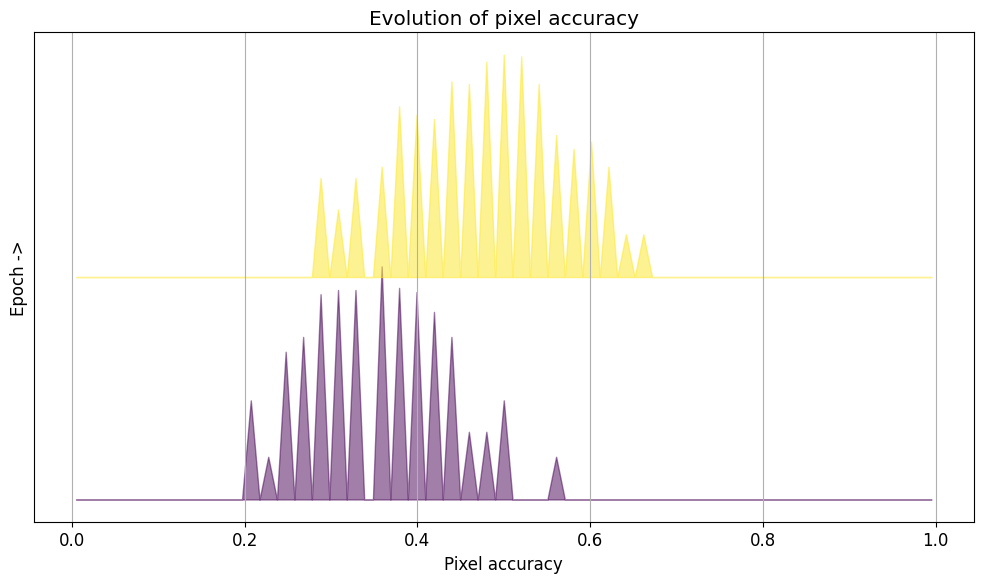

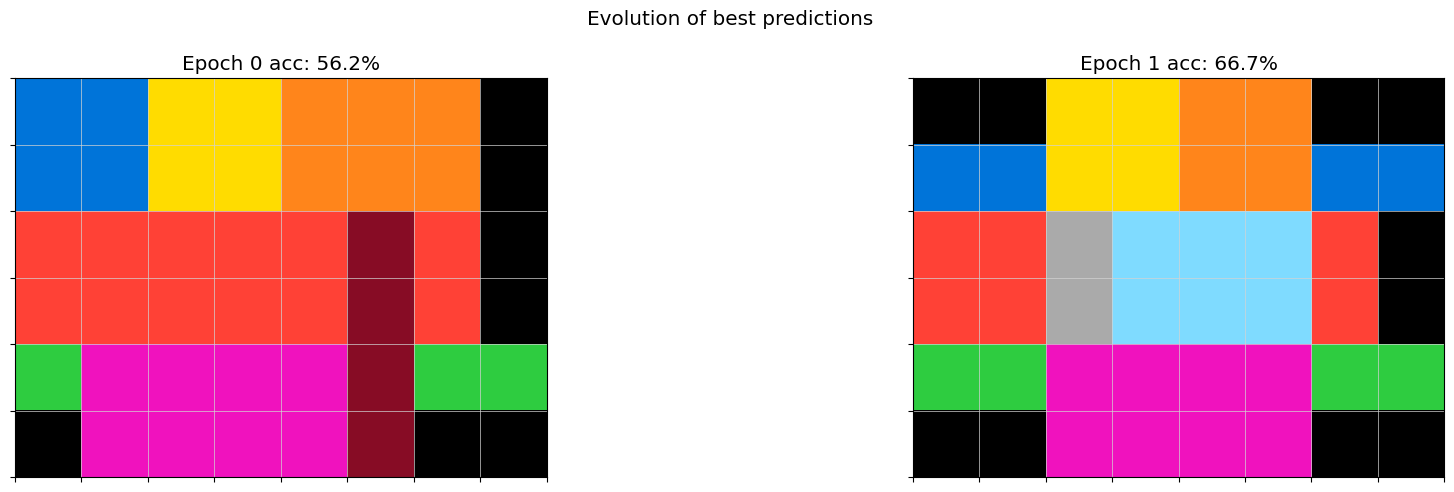

2025-05-06 19:18:59,719 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 19:18:59,788 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/223 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/223 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/223 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/223 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 223
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 19:19:41,987 - arc25.logging - INFO - wrapper - Executed finetuning in 42.2670 seconds
2025-05-06 19:19:41,988 - root - INFO - hindsight_experience_replay - Starting epoch 2...
2025-05-06 19:19:41,989 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 19:20:05,588 - root - INFO - inference - Number of unique outputs: 200/256
2025-05-06 19:20:05,590 - root - INFO - inference - Max pixel accuracy: 0.7291666666666666
2025-05-06 19:20:05,593 - arc25.logging - INFO - wrapper - Executed inference in 23.6046 seconds


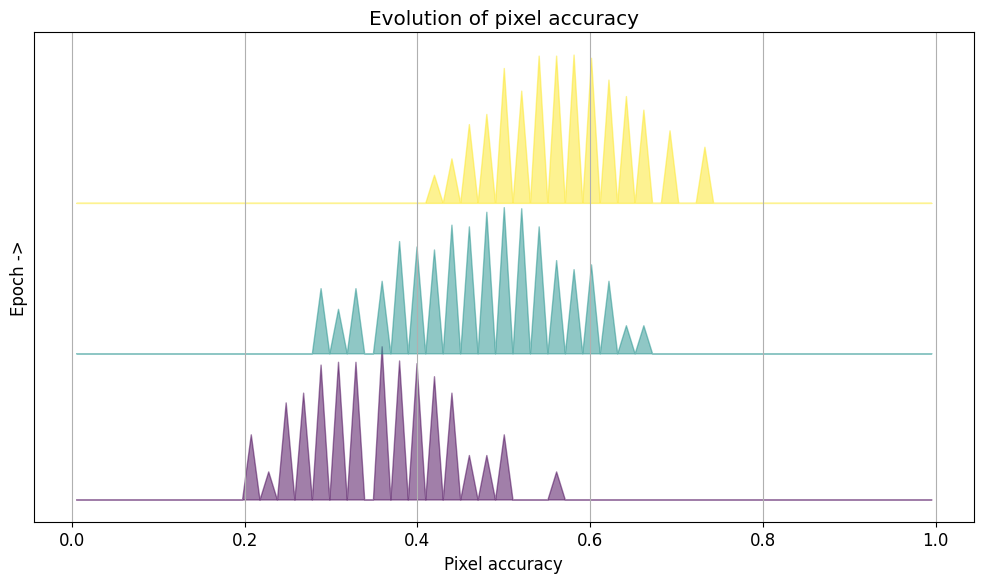

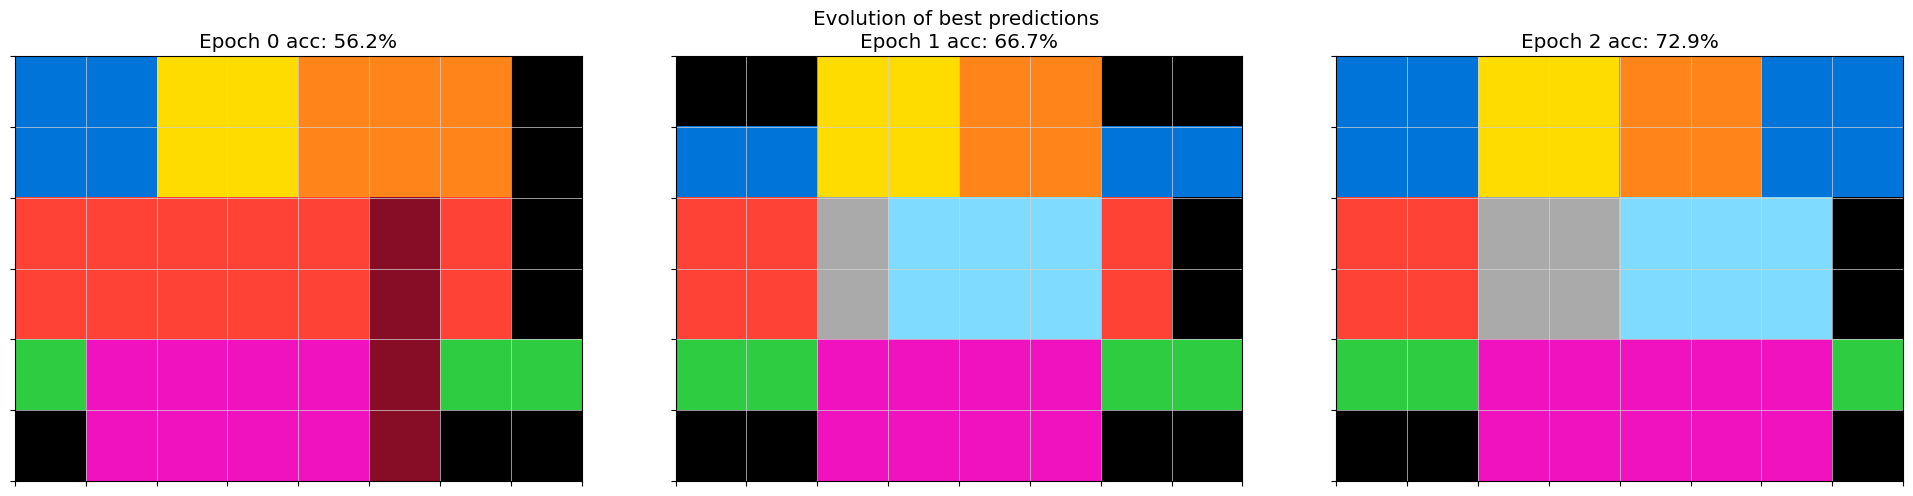

2025-05-06 19:20:05,890 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 19:20:05,961 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/200 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/200 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 200
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 200
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 19:20:42,888 - arc25.logging - INFO - wrapper - Executed finetuning in 36.9969 seconds
2025-05-06 19:20:42,889 - root - INFO - hindsight_experience_replay - Starting epoch 3...
2025-05-06 19:20:42,890 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 19:21:09,071 - root - INFO - inference - Number of unique outputs: 96/256
2025-05-06 19:21:09,073 - root - INFO - inference - Max pixel accuracy: 0.8541666666666666
2025-05-06 19:21:09,075 - arc25.logging - INFO - wrapper - Executed inference in 26.1843 seconds


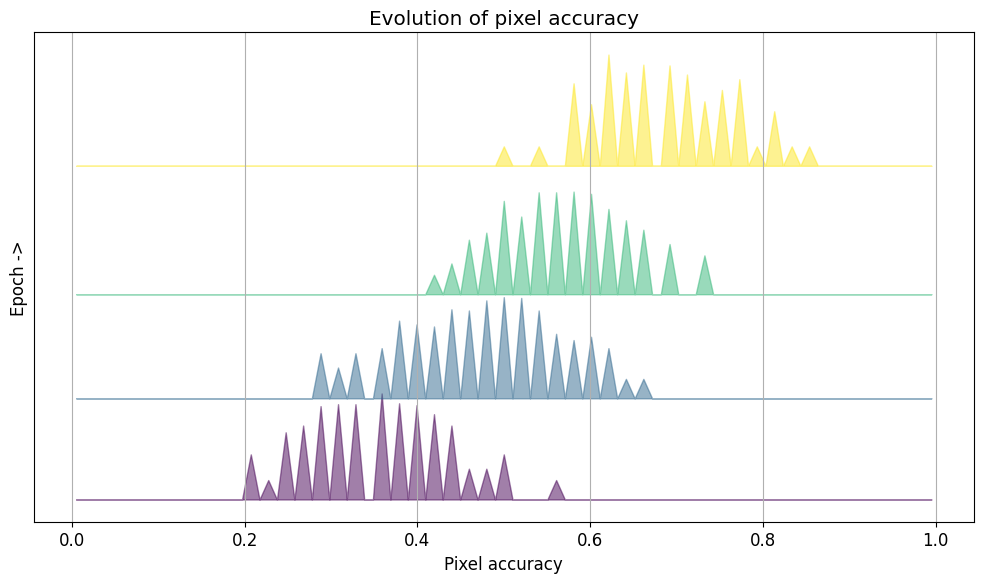

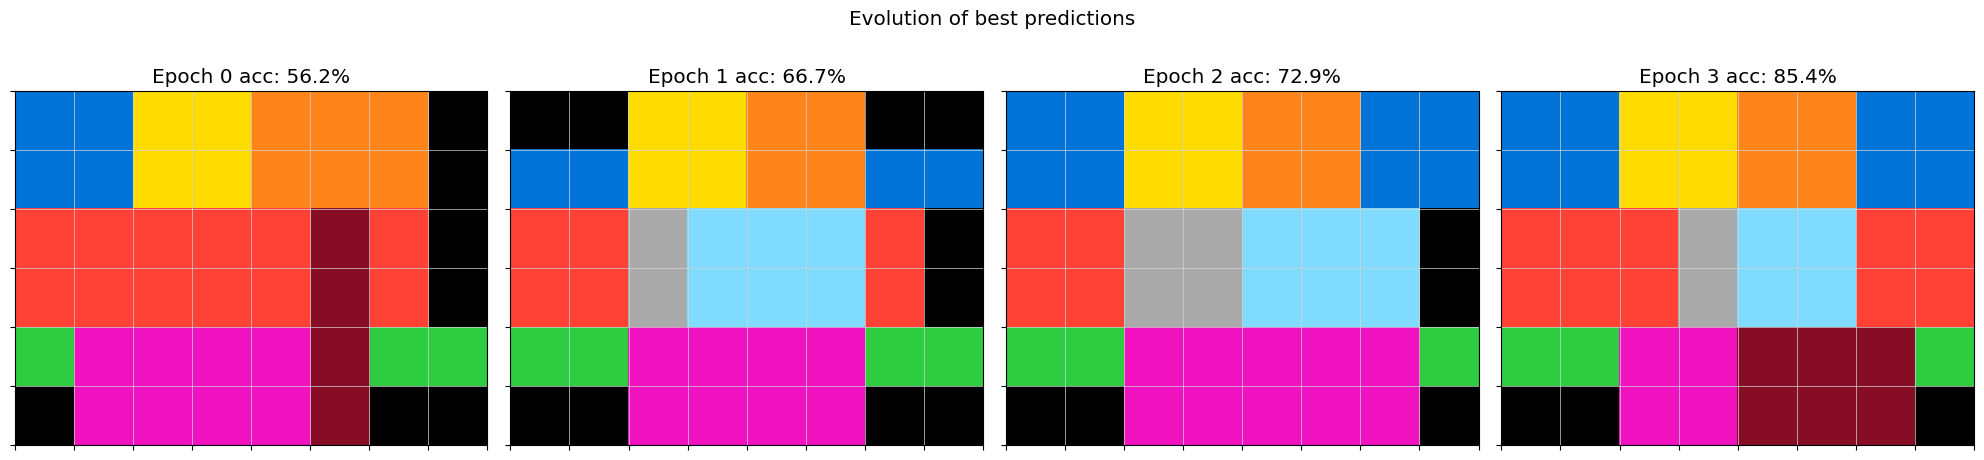

2025-05-06 19:21:09,415 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 19:21:09,475 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/96 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/96 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/96 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/96 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 96
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 96
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 19:21:27,536 - arc25.logging - INFO - wrapper - Executed finetuning in 18.1194 seconds
2025-05-06 19:21:27,537 - root - INFO - hindsight_experience_replay - Starting epoch 4...
2025-05-06 19:21:27,538 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 19:21:56,373 - root - INFO - inference - Number of unique outputs: 78/256
2025-05-06 19:21:56,374 - root - INFO - inference - Max pixel accuracy: 0.875
2025-05-06 19:21:56,378 - arc25.logging - INFO - wrapper - Executed inference in 28.8400 seconds


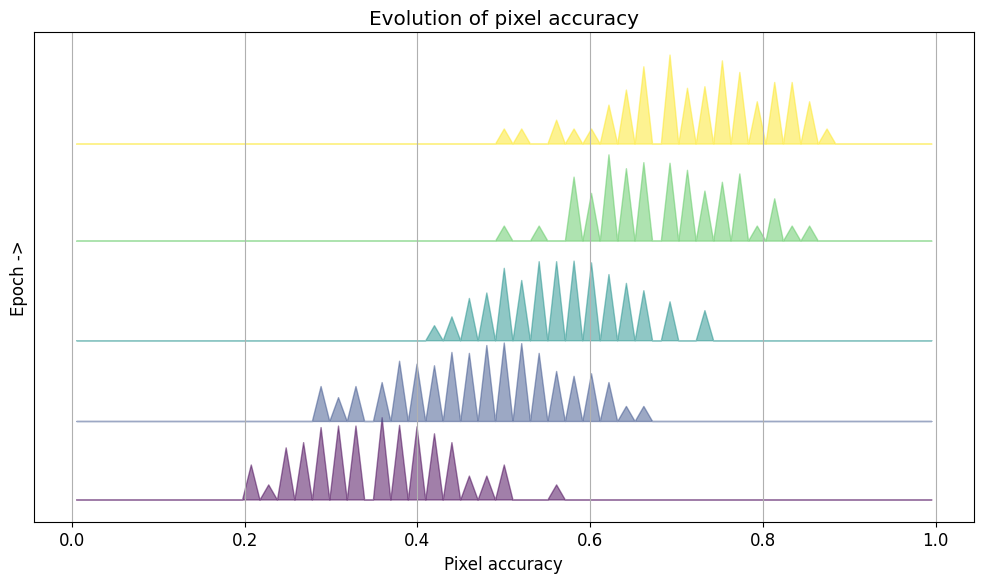

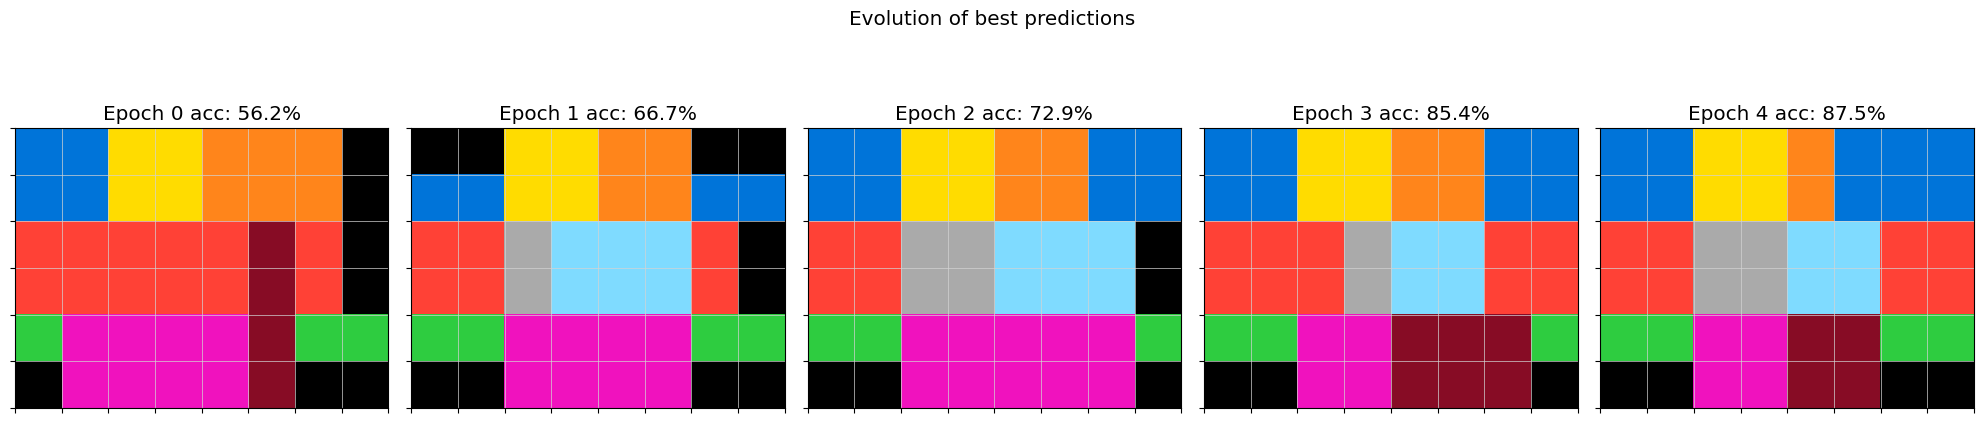

2025-05-06 19:21:56,830 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 19:21:56,902 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/78 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/78 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/78 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/78 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 78
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 78
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 19:22:12,035 - arc25.logging - INFO - wrapper - Executed finetuning in 15.2043 seconds
2025-05-06 19:22:12,037 - root - INFO - hindsight_experience_replay - Starting epoch 5...
2025-05-06 19:22:12,038 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 19:22:40,902 - root - INFO - inference - Number of unique outputs: 43/256
2025-05-06 19:22:40,903 - root - INFO - inference - Max pixel accuracy: 0.9166666666666666
2025-05-06 19:22:40,905 - arc25.logging - INFO - wrapper - Executed inference in 28.8659 seconds


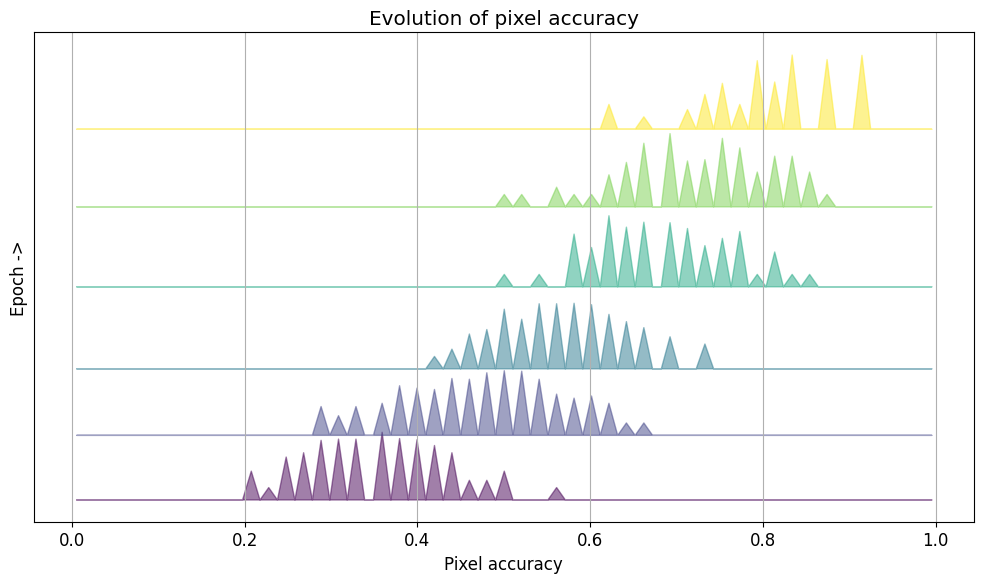

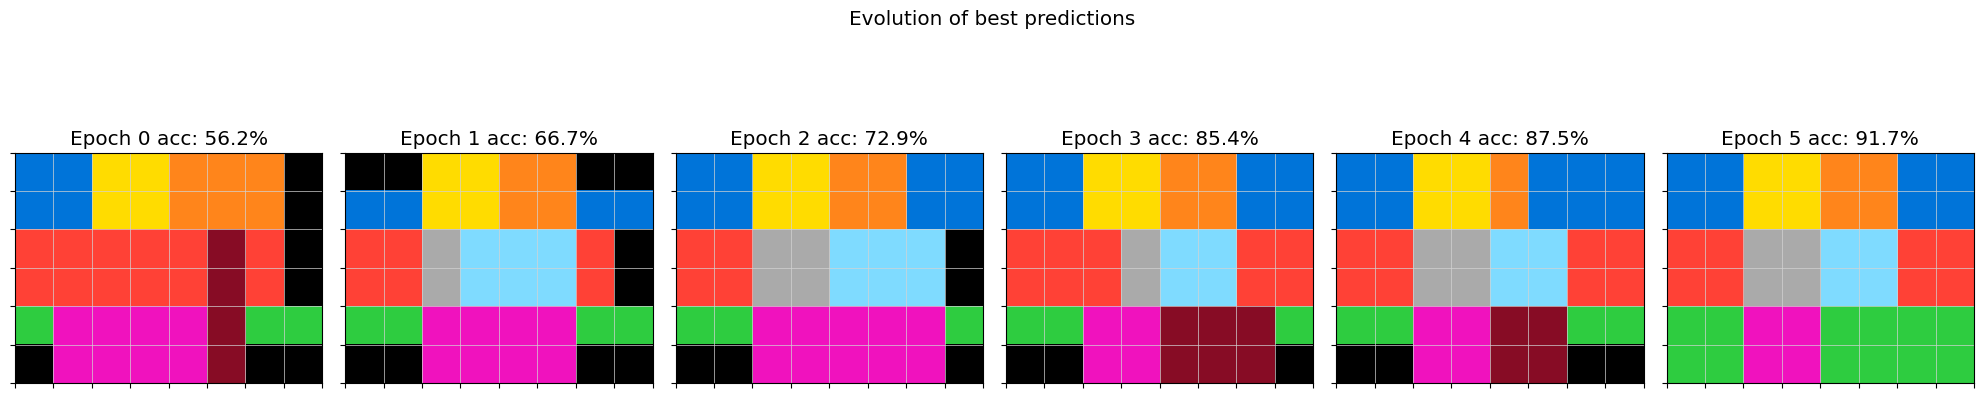

2025-05-06 19:22:41,411 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 19:22:41,467 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/43 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/43 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/43 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/43 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 43
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 19:22:50,549 - arc25.logging - INFO - wrapper - Executed finetuning in 9.1369 seconds
2025-05-06 19:22:50,551 - root - INFO - hindsight_experience_replay - Starting epoch 6...
2025-05-06 19:22:50,552 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 19:23:16,888 - root - INFO - inference - Number of unique outputs: 16/256
2025-05-06 19:23:16,889 - root - INFO - inference - Max pixel accuracy: 0.9166666666666666
2025-05-06 19:23:16,891 - arc25.logging - INFO - wrapper - Executed inference in 26.3378 seconds


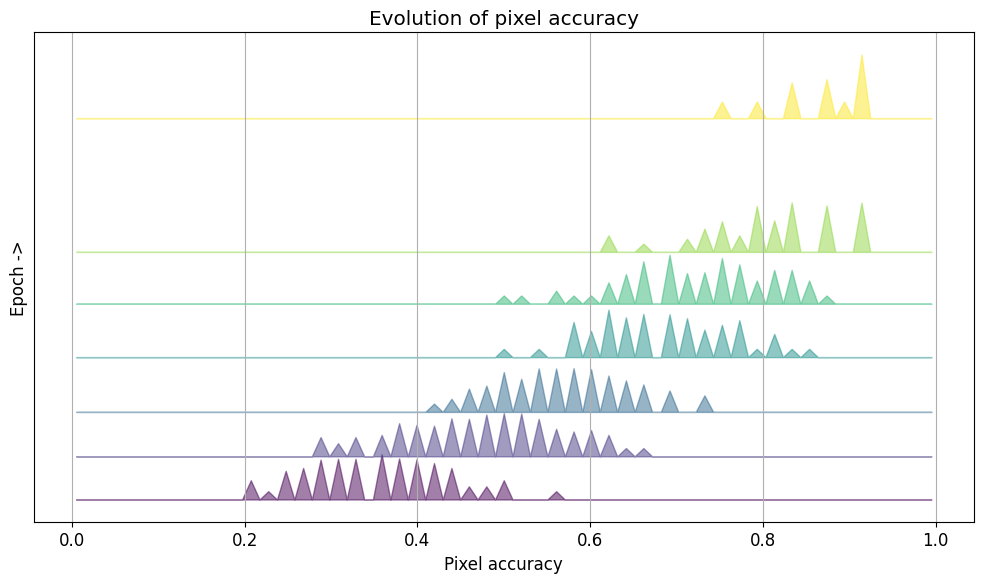

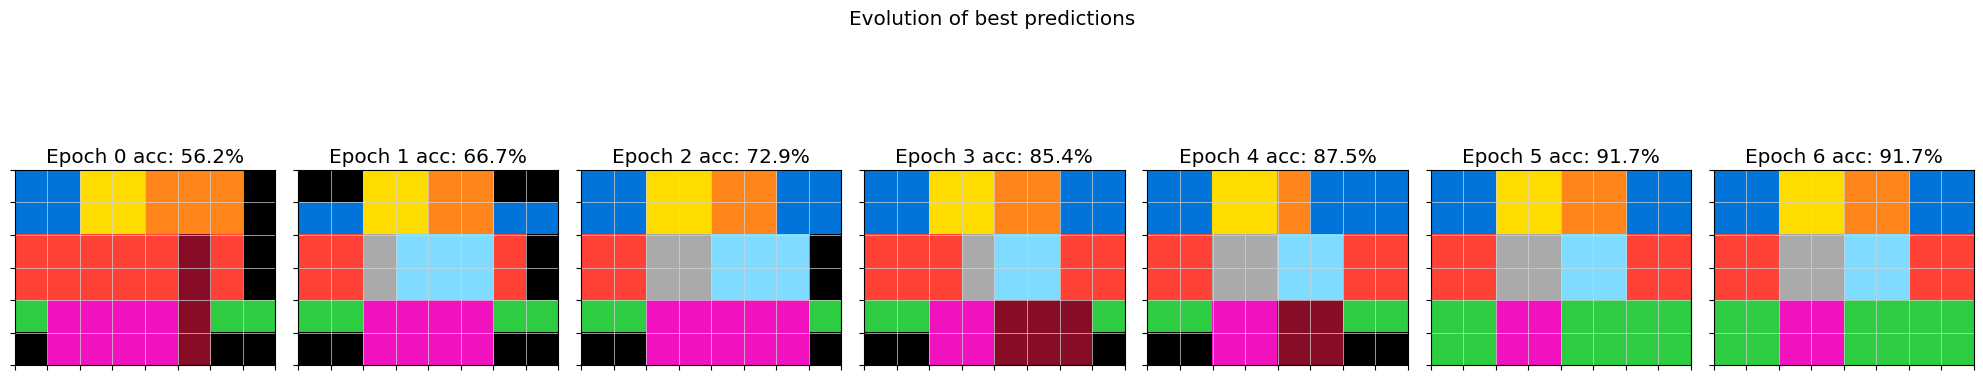

2025-05-06 19:23:17,382 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 19:23:17,438 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/16 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/16 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/16 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/16 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 16
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 16
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 19:23:21,571 - arc25.logging - INFO - wrapper - Executed finetuning in 4.1886 seconds
2025-05-06 19:23:21,573 - root - INFO - hindsight_experience_replay - Starting epoch 7...
2025-05-06 19:23:21,573 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 19:23:47,725 - root - INFO - inference - Number of unique outputs: 8/256
2025-05-06 19:23:47,727 - root - INFO - inference - Max pixel accuracy: 0.9166666666666666
2025-05-06 19:23:47,729 - arc25.logging - INFO - wrapper - Executed inference in 26.1547 seconds


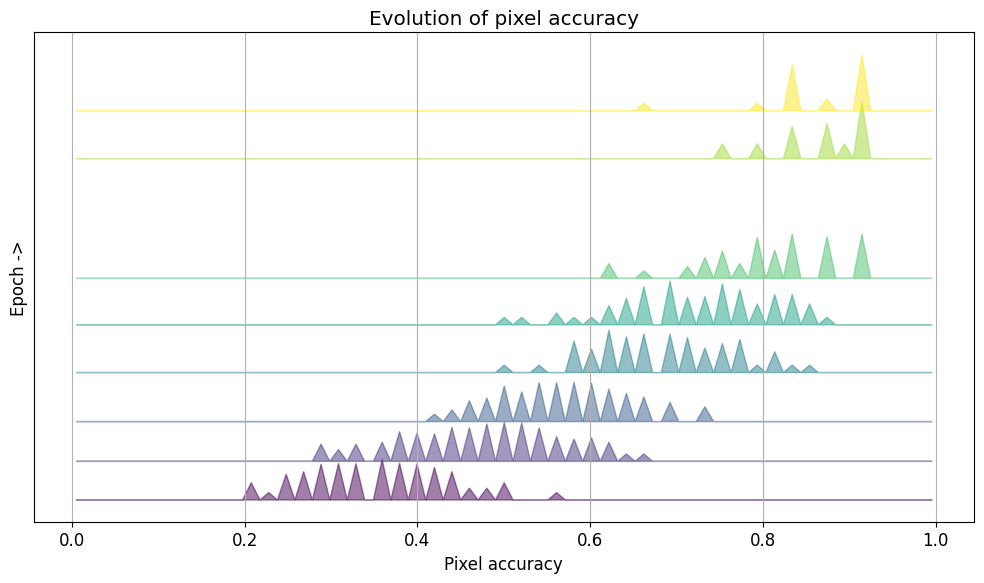

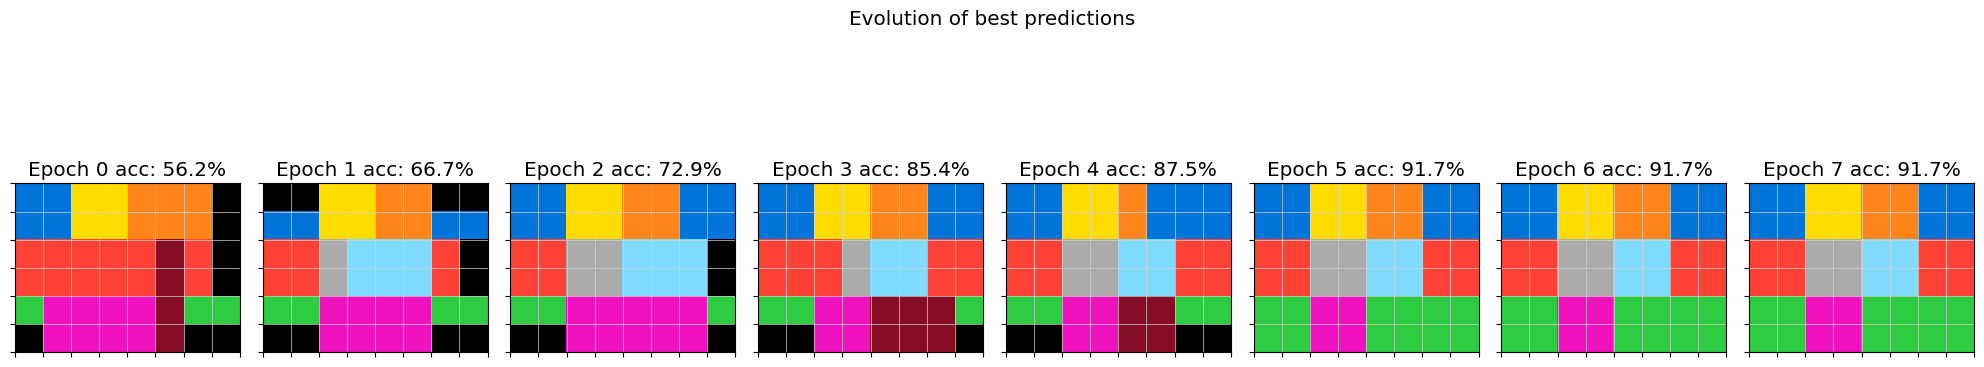

2025-05-06 19:23:48,325 - arc25.logging - INFO - wrapper - Executing finetuning...
No output directory specified, defaulting to 'trainer_output'. To change this behavior, specify --output_dir when creating TrainingArguments.
PyTorch: setting up devices
2025-05-06 19:23:48,371 - finetuning - INFO - get_data_collator - Using SmolLM\Qwen template for collator


Converting train dataset to ChatML:   0%|          | 0/8 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/8 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/8 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/8 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 8
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 8
  Number of trainable parameters = 4,374,528




Training completed. Do not forget to share your model on huggingface.co/models =)


2025-05-06 19:23:50,586 - arc25.logging - INFO - wrapper - Executed finetuning in 2.2604 seconds
2025-05-06 19:23:50,588 - root - INFO - hindsight_experience_replay - Starting epoch 8...
2025-05-06 19:23:50,588 - arc25.logging - INFO - wrapper - Executing inference...


  0%|          | 0/256 [00:00<?, ?it/s]

2025-05-06 19:24:19,623 - root - INFO - inference - Number of unique outputs: 27/256
2025-05-06 19:24:19,625 - root - INFO - inference - Max pixel accuracy: 1.0
2025-05-06 19:24:19,626 - arc25.logging - INFO - wrapper - Executed inference in 29.0371 seconds


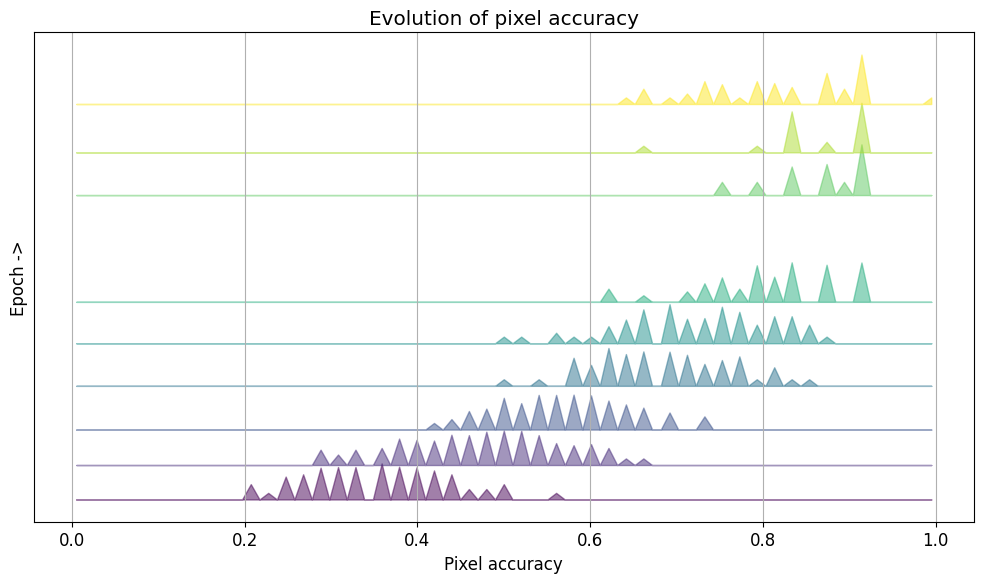

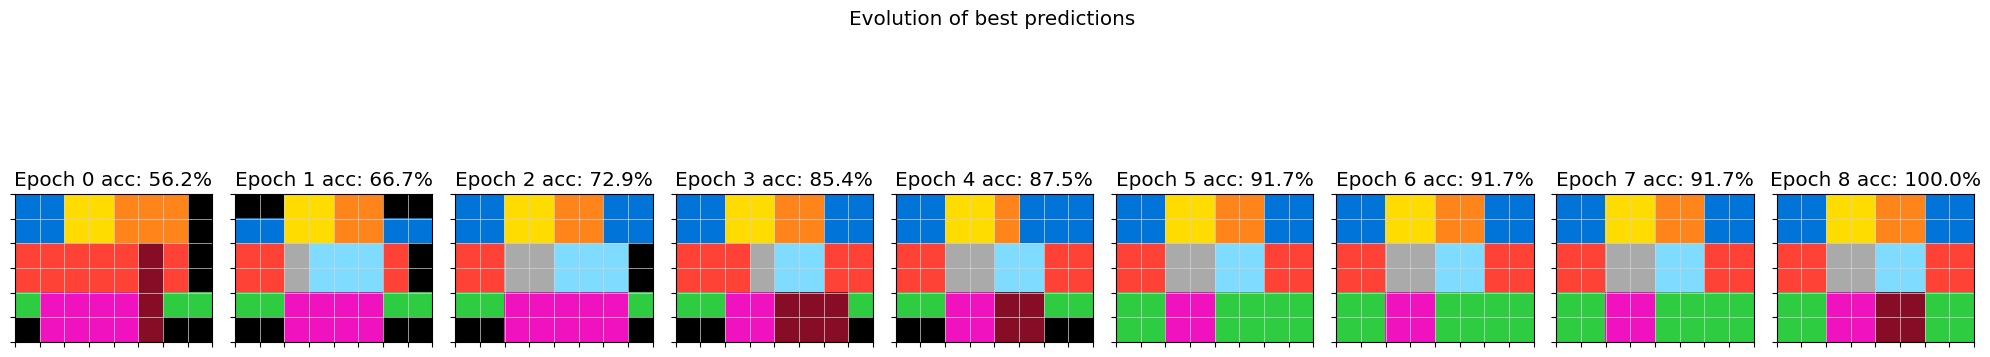

2025-05-06 19:24:20,205 - arc25.input_generation - INFO - hindsight_experience_replay - Found a perfect prediction at epoch 8!


# Best prediction code

```python
def task(img):
    draw_rectangle(img, point1=(2, 0), point2=(3, 7), color=2)
    draw_horizontal_line(img, y=4, color=9)
    draw_vertical_line(img, x=4, color=9)
    draw_rectangle(img, point1=(4, 0), point2=(5, 7), color=3)
    draw_rectangle(img, point1=(2, 2), point2=(3, 3), color=5)
    draw_rectangle(img, point1=(4, 2), point2=(5, 3), color=6)
    draw_rectangle(img, point1=(0, 2), point2=(1, 3), color=4)
    draw_rectangle(img, point1=(2, 4), point2=(3, 5), color=8)
    draw_rectangle(img, point1=(0, 5), point2=(1, 7), color=1)
    draw_rectangle(img, point1=(4, 4), point2=(5, 5), color=9)
    draw_rectangle(img, point1=(0, 4), point2=(1, 5), color=7)
    draw_rectangle(img, point1=(0, 0), point2=(1, 1), color=1)
    return img
```

2025-05-06 19:24:20,275 - arc25.logging - INFO - wrapper - Executed hindsight_experience_replay in 414.6907 seconds


In [19]:
input_img = create_img((6, 8), color=0)
output_img = input_img.copy()
color = 0
for x in range(0, input_img.shape[1], 2):
    for y in range(0, input_img.shape[0], 2):
        color = (color + 1) % 10
        if color == 0: color = 1
        draw_rectangle(output_img, (y, x), (y+1, x+1), color=color)
task = Task(inputs=[input_img], outputs=[output_img], code='', name='manual')
hindsight_experience_replay(task, Config(lora_path='/mnt/hdd0/Kaggle/arc25/trainings/20250430_first_trainings/steps_800/checkpoint-800'));

## Results

| batch size | inference time(s) | throughput (preds/s) |
|------------|-------------------|----------------------|
| 1          | 6.4               | 0.2                  |
| 4          | 7.4               | 0.5                  |
| 16         | 8.5               | 1.9                  |
| 64         | 9                 | 7.1                  |
| 128        | 10.9              | 11.7                 |
| 256        | 15.3              | 16.7                 |
| 512        | 30.1              | 17.0                 |

A batch size of 256 might be the sweet spot. It takes just twice as making two predictions with batch size 1.

## TODO

- Try weaker models
- Simplify predictions of the model
- Temperature sweep